# Earnings Call Sentiment Analysis

## 1. Data Wrangling and EDA

### 1.1 Data Wrangling

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import re
from tqdm import tqdm

import nltk
# nltk.download('punkt')
# nltk.download('words')


from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from tqdm import tqdm
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load S&P 500 List
spx_list = pd.read_csv("data/spx_list.csv")

In [3]:
spx_list.head()

Company Symbol
0                    Apple Inc.   AAPL
1                   Nvidia Corp   NVDA
2                Microsoft Corp   MSFT
3                Amazon.com Inc   AMZN
4  Meta Platforms, Inc. Class A   META

In [4]:
tickers = spx_list['Symbol'].tolist()

The original dataset struce is like this. Inside the sectors folder, there are subfolders named after each sector (e.g., tech, banks). Within each sector folder, there are subfolders named after stock tickers (e.g., AAPL, JPM). Inside each ticker folder, there are CSV files named with the format of the stock ticker followed by the year and quarter (e.g., AAPL20221.csv, AAPL20222.csv). These CSV files contain the earnings call data for the corresponding stock ticker and quarter. So, the total number of folders is 2,469, and the total number of files is 85,645.

We can see the structure using following code.

In [5]:
# Structure of data source

def print_directory_tree(root_dir, level=0):
    # Get list of directories and files
    items = sorted(os.listdir(root_dir))
    
    # Traverse the directory
    for item in items:
        item_path = os.path.join(root_dir, item)
        
        # Print the current item with indentation for tree structure
        print('   ' * level + '|-- ' + item)
        
        # If the current item is a directory, recursively print its contents
        if os.path.isdir(item_path):
            print_directory_tree(item_path, level + 1)

# Set the base directory (change this to your sectors folder)
base_dir = './data'

# Call the function to print the directory structure
print_directory_tree(base_dir)


|-- combined_earnings_calls.csv
|-- sectors
   |-- .DS_Store
   |-- automobiles
      |-- .DS_Store
      |-- ADNT
         |-- ADNT20172.csv
         |-- ADNT20173.csv
         |-- ADNT20174.csv
         |-- ADNT20181.csv
         |-- ADNT20182.csv
         |-- ADNT20183.csv
         |-- ADNT20184.csv
         |-- ADNT20191.csv
         |-- ADNT20192.csv
         |-- ADNT20193.csv
         |-- ADNT20194.csv
         |-- ADNT20201.csv
         |-- ADNT20202.csv
         |-- ADNT20203.csv
         |-- ADNT20204.csv
         |-- ADNT20211.csv
         |-- ADNT20212.csv
         |-- ADNT20213.csv
         |-- ADNT20214.csv
         |-- ADNT20221.csv
         |-- ADNT20222.csv
         |-- ADNT20223.csv
         |-- ADNT20224.csv
         |-- speaker names.csv
      |-- ALV
         |-- ALV20112.csv
         |-- ALV20113.csv
         |-- ALV20114.csv
         |-- ALV20121.csv
         |-- ALV20122.csv
         |-- ALV20123.csv
         |-- ALV20124.csv
         |-- ALV20131.csv
         |-

         |-- MPAA20163.csv
         |-- MPAA20164.csv
         |-- MPAA20171.csv
         |-- MPAA20172.csv
         |-- MPAA20173.csv
         |-- MPAA20174.csv
         |-- MPAA20181.csv
         |-- MPAA20182.csv
         |-- MPAA20183.csv
         |-- MPAA20184.csv
         |-- MPAA20191.csv
         |-- MPAA20192.csv
         |-- MPAA20193.csv
         |-- MPAA20194.csv
         |-- MPAA20201.csv
         |-- MPAA20202.csv
         |-- MPAA20203.csv
         |-- MPAA20204.csv
         |-- MPAA20211.csv
         |-- MPAA20213.csv
         |-- MPAA20214.csv
         |-- MPAA20221.csv
         |-- MPAA20222.csv
         |-- MPAA20223.csv
         |-- MPAA20224.csv
         |-- MPAA20231.csv
         |-- MPAA20232.csv
         |-- speaker names.csv
      |-- NIU
         |-- NIU20192.csv
         |-- NIU20193.csv
         |-- NIU20194.csv
         |-- NIU20202.csv
         |-- NIU20203.csv
         |-- NIU20211.csv
         |-- NIU20212.csv
         |-- NIU20213.csv
         |-- NIU20

         |-- BANC20204.csv
         |-- BANC20211.csv
         |-- BANC20212.csv
         |-- BANC20213.csv
         |-- BANC20214.csv
         |-- BANC20221.csv
         |-- BANC20222.csv
         |-- BANC20223.csv
         |-- speaker names.csv
      |-- BANR
         |-- BANR20131.csv
         |-- BANR20132.csv
         |-- BANR20133.csv
         |-- BANR20134.csv
         |-- BANR20141.csv
         |-- BANR20142.csv
         |-- BANR20143.csv
         |-- BANR20144.csv
         |-- BANR20151.csv
         |-- BANR20152.csv
         |-- BANR20153.csv
         |-- BANR20154.csv
         |-- BANR20161.csv
         |-- BANR20162.csv
         |-- BANR20163.csv
         |-- BANR20164.csv
         |-- BANR20171.csv
         |-- BANR20172.csv
         |-- BANR20173.csv
         |-- BANR20174.csv
         |-- BANR20181.csv
         |-- BANR20182.csv
         |-- BANR20183.csv
         |-- BANR20184.csv
         |-- BANR20191.csv
         |-- BANR20192.csv
         |-- BANR20194.csv
         

         |-- DCOM20194.csv
         |-- DCOM20201.csv
         |-- DCOM20211.csv
         |-- DCOM20212.csv
         |-- DCOM20213.csv
         |-- DCOM20214.csv
         |-- DCOM20221.csv
         |-- DCOM20222.csv
         |-- DCOM20223.csv
         |-- speaker names.csv
      |-- EBC
         |-- EBC20212.csv
         |-- EBC20213.csv
         |-- EBC20214.csv
         |-- EBC20221.csv
         |-- EBC20222.csv
         |-- EBC20223.csv
         |-- speaker names.csv
      |-- EFSC
         |-- EFSC20143.csv
         |-- EFSC20144.csv
         |-- EFSC20151.csv
         |-- EFSC20152.csv
         |-- EFSC20153.csv
         |-- EFSC20154.csv
         |-- EFSC20161.csv
         |-- EFSC20162.csv
         |-- EFSC20163.csv
         |-- EFSC20164.csv
         |-- EFSC20171.csv
         |-- EFSC20172.csv
         |-- EFSC20173.csv
         |-- EFSC20174.csv
         |-- EFSC20181.csv
         |-- EFSC20182.csv
         |-- EFSC20183.csv
         |-- EFSC20184.csv
         |-- EFSC20191.c

         |-- GBCI20163.csv
         |-- GBCI20164.csv
         |-- GBCI20171.csv
         |-- GBCI20172.csv
         |-- GBCI20173.csv
         |-- GBCI20174.csv
         |-- GBCI20181.csv
         |-- GBCI20182.csv
         |-- GBCI20183.csv
         |-- GBCI20184.csv
         |-- GBCI20191.csv
         |-- GBCI20192.csv
         |-- GBCI20193.csv
         |-- GBCI20194.csv
         |-- GBCI20201.csv
         |-- GBCI20202.csv
         |-- GBCI20204.csv
         |-- GBCI20211.csv
         |-- GBCI20212.csv
         |-- GBCI20213.csv
         |-- GBCI20214.csv
         |-- GBCI20221.csv
         |-- GBCI20222.csv
         |-- GBCI20223.csv
         |-- speaker names.csv
      |-- GSBC
         |-- GSBC20174.csv
         |-- GSBC20181.csv
         |-- GSBC20182.csv
         |-- GSBC20183.csv
         |-- GSBC20184.csv
         |-- GSBC20191.csv
         |-- GSBC20192.csv
         |-- GSBC20193.csv
         |-- GSBC20194.csv
         |-- GSBC20201.csv
         |-- GSBC20202.csv
         

         |-- NMIH20223.csv
         |-- speaker names.csv
      |-- NTB
         |-- NTB20172.csv
         |-- NTB20173.csv
         |-- NTB20174.csv
         |-- NTB20181.csv
         |-- NTB20182.csv
         |-- NTB20183.csv
         |-- NTB20184.csv
         |-- NTB20191.csv
         |-- NTB20192.csv
         |-- NTB20193.csv
         |-- NTB20194.csv
         |-- NTB20201.csv
         |-- NTB20202.csv
         |-- NTB20204.csv
         |-- NTB20211.csv
         |-- NTB20212.csv
         |-- NTB20213.csv
         |-- NTB20214.csv
         |-- NTB20222.csv
         |-- NTB20223.csv
         |-- speaker names.csv
      |-- NYCB
         |-- NYCB20094.csv
         |-- NYCB20112.csv
         |-- NYCB20113.csv
         |-- NYCB20114.csv
         |-- NYCB20121.csv
         |-- NYCB20122.csv
         |-- NYCB20123.csv
         |-- NYCB20124.csv
         |-- NYCB20131.csv
         |-- NYCB20132.csv
         |-- NYCB20133.csv
         |-- NYCB20134.csv
         |-- NYCB20141.csv
         |-

         |-- PFS20221.csv
         |-- PFS20222.csv
         |-- PFS20223.csv
         |-- speaker names.csv
      |-- PNC
         |-- PNC20073.csv
         |-- PNC20074.csv
         |-- PNC20081.csv
         |-- PNC20082.csv
         |-- PNC20083.csv
         |-- PNC20084.csv
         |-- PNC20091.csv
         |-- PNC20092.csv
         |-- PNC20093.csv
         |-- PNC20094.csv
         |-- PNC20101.csv
         |-- PNC20102.csv
         |-- PNC20104.csv
         |-- PNC20111.csv
         |-- PNC20112.csv
         |-- PNC20113.csv
         |-- PNC20114.csv
         |-- PNC20121.csv
         |-- PNC20122.csv
         |-- PNC20123.csv
         |-- PNC20124.csv
         |-- PNC20131.csv
         |-- PNC20132.csv
         |-- PNC20133.csv
         |-- PNC20134.csv
         |-- PNC20141.csv
         |-- PNC20142.csv
         |-- PNC20143.csv
         |-- PNC20144.csv
         |-- PNC20151.csv
         |-- PNC20152.csv
         |-- PNC20153.csv
         |-- PNC20154.csv
         |-- PNC201

         |-- STBA20151.csv
         |-- STBA20152.csv
         |-- STBA20153.csv
         |-- STBA20154.csv
         |-- STBA20161.csv
         |-- STBA20162.csv
         |-- STBA20163.csv
         |-- STBA20164.csv
         |-- STBA20171.csv
         |-- STBA20172.csv
         |-- STBA20173.csv
         |-- STBA20174.csv
         |-- STBA20181.csv
         |-- STBA20182.csv
         |-- STBA20183.csv
         |-- STBA20184.csv
         |-- STBA20191.csv
         |-- STBA20192.csv
         |-- STBA20193.csv
         |-- STBA20194.csv
         |-- STBA20201.csv
         |-- STBA20202.csv
         |-- STBA20203.csv
         |-- STBA20204.csv
         |-- STBA20211.csv
         |-- STBA20212.csv
         |-- STBA20213.csv
         |-- STBA20214.csv
         |-- STBA20221.csv
         |-- STBA20222.csv
         |-- STBA20223.csv
         |-- speaker names.csv
      |-- TBBK
         |-- TBBK20094.csv
         |-- TBBK20101.csv
         |-- TBBK20102.csv
         |-- TBBK20103.csv
         

         |-- WSFS20211.csv
         |-- WSFS20212.csv
         |-- WSFS20213.csv
         |-- WSFS20214.csv
         |-- WSFS20221.csv
         |-- WSFS20222.csv
         |-- WSFS20223.csv
         |-- speaker names.csv
      |-- WTFC
         |-- WTFC20131.csv
         |-- WTFC20132.csv
         |-- WTFC20133.csv
         |-- WTFC20134.csv
         |-- WTFC20141.csv
         |-- WTFC20142.csv
         |-- WTFC20143.csv
         |-- WTFC20144.csv
         |-- WTFC20151.csv
         |-- WTFC20152.csv
         |-- WTFC20153.csv
         |-- WTFC20154.csv
         |-- WTFC20161.csv
         |-- WTFC20162.csv
         |-- WTFC20163.csv
         |-- WTFC20164.csv
         |-- WTFC20171.csv
         |-- WTFC20172.csv
         |-- WTFC20173.csv
         |-- WTFC20174.csv
         |-- WTFC20181.csv
         |-- WTFC20182.csv
         |-- WTFC20183.csv
         |-- WTFC20184.csv
         |-- WTFC20191.csv
         |-- WTFC20192.csv
         |-- WTFC20193.csv
         |-- WTFC20194.csv
         

         |-- AWI20161.csv
         |-- AWI20162.csv
         |-- AWI20163.csv
         |-- AWI20164.csv
         |-- AWI20171.csv
         |-- AWI20172.csv
         |-- AWI20173.csv
         |-- AWI20174.csv
         |-- AWI20181.csv
         |-- AWI20182.csv
         |-- AWI20184.csv
         |-- AWI20191.csv
         |-- AWI20192.csv
         |-- AWI20193.csv
         |-- AWI20194.csv
         |-- AWI20201.csv
         |-- AWI20202.csv
         |-- AWI20204.csv
         |-- AWI20211.csv
         |-- AWI20212.csv
         |-- AWI20213.csv
         |-- AWI20214.csv
         |-- AWI20221.csv
         |-- AWI20222.csv
         |-- AWI20223.csv
         |-- speaker names.csv
      |-- AXON
         |-- AXON20204.csv
         |-- AXON20211.csv
         |-- AXON20212.csv
         |-- AXON20213.csv
         |-- AXON20214.csv
         |-- AXON20221.csv
         |-- AXON20222.csv
         |-- AXON20223.csv
         |-- speaker names.csv
      |-- AYI
         |-- AYI20131.csv
         |-- AYI2

         |-- CR20191.csv
         |-- CR20192.csv
         |-- CR20193.csv
         |-- CR20194.csv
         |-- CR20201.csv
         |-- CR20202.csv
         |-- CR20204.csv
         |-- CR20211.csv
         |-- CR20212.csv
         |-- CR20213.csv
         |-- CR20214.csv
         |-- CR20221.csv
         |-- CR20222.csv
         |-- CR20223.csv
         |-- speaker names.csv
      |-- CSL
         |-- CSL20094.csv
         |-- CSL20112.csv
         |-- CSL20113.csv
         |-- CSL20114.csv
         |-- CSL20121.csv
         |-- CSL20122.csv
         |-- CSL20123.csv
         |-- CSL20124.csv
         |-- CSL20131.csv
         |-- CSL20132.csv
         |-- CSL20133.csv
         |-- CSL20134.csv
         |-- CSL20141.csv
         |-- CSL20142.csv
         |-- CSL20143.csv
         |-- CSL20144.csv
         |-- CSL20151.csv
         |-- CSL20152.csv
         |-- CSL20153.csv
         |-- CSL20154.csv
         |-- CSL20161.csv
         |-- CSL20162.csv
         |-- CSL20163.csv
       

         |-- GATX20213.csv
         |-- GATX20214.csv
         |-- GATX20221.csv
         |-- GATX20222.csv
         |-- GATX20223.csv
         |-- speaker names.csv
      |-- GD
         |-- GD20081.csv
         |-- GD20082.csv
         |-- GD20083.csv
         |-- GD20084.csv
         |-- GD20091.csv
         |-- GD20092.csv
         |-- GD20093.csv
         |-- GD20094.csv
         |-- GD20101.csv
         |-- GD20102.csv
         |-- GD20103.csv
         |-- GD20104.csv
         |-- GD20111.csv
         |-- GD20112.csv
         |-- GD20113.csv
         |-- GD20114.csv
         |-- GD20121.csv
         |-- GD20122.csv
         |-- GD20123.csv
         |-- GD20124.csv
         |-- GD20131.csv
         |-- GD20132.csv
         |-- GD20133.csv
         |-- GD20134.csv
         |-- GD20141.csv
         |-- GD20142.csv
         |-- GD20143.csv
         |-- GD20144.csv
         |-- GD20151.csv
         |-- GD20152.csv
         |-- GD20153.csv
         |-- GD20154.csv
         |-- GD20161.

         |-- KMT20154.csv
         |-- KMT20161.csv
         |-- KMT20162.csv
         |-- KMT20163.csv
         |-- KMT20164.csv
         |-- KMT20171.csv
         |-- KMT20172.csv
         |-- KMT20173.csv
         |-- KMT20174.csv
         |-- KMT20181.csv
         |-- KMT20182.csv
         |-- KMT20183.csv
         |-- KMT20184.csv
         |-- KMT20191.csv
         |-- KMT20192.csv
         |-- KMT20193.csv
         |-- KMT20194.csv
         |-- KMT20201.csv
         |-- KMT20202.csv
         |-- KMT20203.csv
         |-- KMT20204.csv
         |-- KMT20212.csv
         |-- KMT20213.csv
         |-- KMT20221.csv
         |-- KMT20222.csv
         |-- KMT20223.csv
         |-- KMT20224.csv
         |-- KMT20231.csv
         |-- speaker names.csv
      |-- LECO
         |-- LECO20112.csv
         |-- LECO20113.csv
         |-- LECO20114.csv
         |-- LECO20121.csv
         |-- LECO20122.csv
         |-- LECO20123.csv
         |-- LECO20124.csv
         |-- LECO20131.csv
         |

         |-- NOC20074.csv
         |-- NOC20081.csv
         |-- NOC20082.csv
         |-- NOC20083.csv
         |-- NOC20084.csv
         |-- NOC20091.csv
         |-- NOC20092.csv
         |-- NOC20093.csv
         |-- NOC20094.csv
         |-- NOC20101.csv
         |-- NOC20102.csv
         |-- NOC20103.csv
         |-- NOC20104.csv
         |-- NOC20111.csv
         |-- NOC20112.csv
         |-- NOC20113.csv
         |-- NOC20114.csv
         |-- NOC20121.csv
         |-- NOC20122.csv
         |-- NOC20123.csv
         |-- NOC20124.csv
         |-- NOC20131.csv
         |-- NOC20132.csv
         |-- NOC20133.csv
         |-- NOC20134.csv
         |-- NOC20141.csv
         |-- NOC20142.csv
         |-- NOC20143.csv
         |-- NOC20144.csv
         |-- NOC20151.csv
         |-- NOC20152.csv
         |-- NOC20153.csv
         |-- NOC20154.csv
         |-- NOC20161.csv
         |-- NOC20162.csv
         |-- NOC20163.csv
         |-- NOC20164.csv
         |-- NOC20171.csv
         |--

         |-- RUN20194.csv
         |-- RUN20201.csv
         |-- RUN20202.csv
         |-- RUN20204.csv
         |-- RUN20211.csv
         |-- RUN20212.csv
         |-- RUN20213.csv
         |-- RUN20214.csv
         |-- RUN20221.csv
         |-- RUN20222.csv
         |-- RUN20223.csv
         |-- speaker names.csv
      |-- SHLS
         |-- SHLS20211.csv
         |-- SHLS20212.csv
         |-- SHLS20213.csv
         |-- SHLS20214.csv
         |-- SHLS20221.csv
         |-- SHLS20222.csv
         |-- speaker names.csv
      |-- SITE
         |-- SITE20171.csv
         |-- SITE20172.csv
         |-- SITE20173.csv
         |-- SITE20174.csv
         |-- SITE20181.csv
         |-- SITE20182.csv
         |-- SITE20183.csv
         |-- SITE20184.csv
         |-- SITE20191.csv
         |-- SITE20192.csv
         |-- SITE20193.csv
         |-- SITE20194.csv
         |-- SITE20201.csv
         |-- SITE20202.csv
         |-- SITE20204.csv
         |-- SITE20211.csv
         |-- SITE20212.csv
 

         |-- TRTN20171.csv
         |-- TRTN20172.csv
         |-- TRTN20173.csv
         |-- TRTN20174.csv
         |-- TRTN20181.csv
         |-- TRTN20182.csv
         |-- TRTN20183.csv
         |-- TRTN20184.csv
         |-- TRTN20191.csv
         |-- TRTN20192.csv
         |-- TRTN20193.csv
         |-- TRTN20194.csv
         |-- TRTN20201.csv
         |-- TRTN20202.csv
         |-- TRTN20204.csv
         |-- TRTN20211.csv
         |-- TRTN20212.csv
         |-- TRTN20213.csv
         |-- TRTN20214.csv
         |-- TRTN20221.csv
         |-- TRTN20222.csv
         |-- TRTN20223.csv
         |-- speaker names.csv
      |-- TT
         |-- TT20202.csv
         |-- TT20203.csv
         |-- TT20204.csv
         |-- TT20211.csv
         |-- TT20212.csv
         |-- TT20213.csv
         |-- TT20222.csv
         |-- TT20223.csv
         |-- speaker names.csv
      |-- TTC
         |-- TTC20113.csv
         |-- TTC20121.csv
         |-- TTC20122.csv
         |-- TTC20123.csv
         |-- 

         |-- ACCO20191.csv
         |-- ACCO20192.csv
         |-- ACCO20193.csv
         |-- ACCO20194.csv
         |-- ACCO20201.csv
         |-- ACCO20202.csv
         |-- ACCO20204.csv
         |-- ACCO20211.csv
         |-- ACCO20212.csv
         |-- ACCO20213.csv
         |-- ACCO20214.csv
         |-- ACCO20222.csv
         |-- ACCO20223.csv
         |-- speaker names.csv
      |-- ACU
         |-- ACU20132.csv
         |-- ACU20133.csv
         |-- ACU20134.csv
         |-- ACU20142.csv
         |-- ACU20143.csv
         |-- ACU20144.csv
         |-- ACU20151.csv
         |-- ACU20152.csv
         |-- ACU20153.csv
         |-- ACU20154.csv
         |-- ACU20161.csv
         |-- ACU20162.csv
         |-- ACU20163.csv
         |-- ACU20164.csv
         |-- ACU20171.csv
         |-- ACU20172.csv
         |-- ACU20173.csv
         |-- ACU20174.csv
         |-- ACU20181.csv
         |-- ACU20182.csv
         |-- ACU20183.csv
         |-- ACU20184.csv
         |-- ACU20191.csv
      

         |-- DLHC20184.csv
         |-- DLHC20191.csv
         |-- DLHC20192.csv
         |-- DLHC20193.csv
         |-- DLHC20194.csv
         |-- DLHC20201.csv
         |-- DLHC20202.csv
         |-- DLHC20203.csv
         |-- DLHC20204.csv
         |-- DLHC20211.csv
         |-- DLHC20212.csv
         |-- DLHC20213.csv
         |-- DLHC20214.csv
         |-- DLHC20221.csv
         |-- DLHC20222.csv
         |-- DLHC20223.csv
         |-- speaker names.csv
      |-- DLX
         |-- DLX20082.csv
         |-- DLX20083.csv
         |-- DLX20084.csv
         |-- DLX20091.csv
         |-- DLX20092.csv
         |-- DLX20093.csv
         |-- DLX20094.csv
         |-- DLX20101.csv
         |-- DLX20102.csv
         |-- DLX20103.csv
         |-- DLX20104.csv
         |-- DLX20111.csv
         |-- DLX20112.csv
         |-- DLX20113.csv
         |-- DLX20114.csv
         |-- DLX20121.csv
         |-- DLX20122.csv
         |-- DLX20123.csv
         |-- DLX20124.csv
         |-- DLX20131.csv
   

         |-- speaker names.csv
      |-- HNI
         |-- HNI20074.csv
         |-- HNI20081.csv
         |-- HNI20082.csv
         |-- HNI20083.csv
         |-- HNI20084.csv
         |-- HNI20091.csv
         |-- HNI20092.csv
         |-- HNI20093.csv
         |-- HNI20094.csv
         |-- HNI20101.csv
         |-- HNI20102.csv
         |-- HNI20103.csv
         |-- HNI20104.csv
         |-- HNI20111.csv
         |-- HNI20112.csv
         |-- HNI20113.csv
         |-- HNI20114.csv
         |-- HNI20121.csv
         |-- HNI20122.csv
         |-- HNI20123.csv
         |-- HNI20124.csv
         |-- HNI20131.csv
         |-- HNI20132.csv
         |-- HNI20133.csv
         |-- HNI20134.csv
         |-- HNI20141.csv
         |-- HNI20142.csv
         |-- HNI20143.csv
         |-- HNI20144.csv
         |-- HNI20151.csv
         |-- HNI20152.csv
         |-- HNI20153.csv
         |-- HNI20154.csv
         |-- HNI20161.csv
         |-- HNI20162.csv
         |-- HNI20163.csv
         |-- HNI201

      |-- MG
         |-- MG20132.csv
         |-- MG20133.csv
         |-- MG20134.csv
         |-- MG20141.csv
         |-- MG20142.csv
         |-- MG20143.csv
         |-- MG20144.csv
         |-- MG20151.csv
         |-- MG20152.csv
         |-- MG20153.csv
         |-- MG20154.csv
         |-- MG20161.csv
         |-- MG20162.csv
         |-- MG20163.csv
         |-- MG20164.csv
         |-- MG20171.csv
         |-- MG20172.csv
         |-- MG20173.csv
         |-- MG20174.csv
         |-- MG20181.csv
         |-- MG20182.csv
         |-- MG20183.csv
         |-- MG20184.csv
         |-- MG20191.csv
         |-- MG20192.csv
         |-- MG20193.csv
         |-- MG20194.csv
         |-- MG20201.csv
         |-- MG20202.csv
         |-- MG20203.csv
         |-- MG20204.csv
         |-- MG20211.csv
         |-- MG20212.csv
         |-- MG20213.csv
         |-- MG20214.csv
         |-- MG20221.csv
         |-- MG20222.csv
         |-- MG20223.csv
         |-- speaker names.csv
      

         |-- SP20191.csv
         |-- SP20192.csv
         |-- SP20193.csv
         |-- SP20194.csv
         |-- SP20201.csv
         |-- SP20202.csv
         |-- SP20204.csv
         |-- SP20211.csv
         |-- SP20212.csv
         |-- SP20213.csv
         |-- SP20214.csv
         |-- SP20221.csv
         |-- SP20222.csv
         |-- speaker names.csv
      |-- SPIR
         |-- SPIR20213.csv
         |-- SPIR20214.csv
         |-- SPIR20221.csv
         |-- SPIR20222.csv
         |-- SPIR20223.csv
         |-- speaker names.csv
      |-- SRCL
         |-- SRCL20074.csv
         |-- SRCL20081.csv
         |-- SRCL20082.csv
         |-- SRCL20083.csv
         |-- SRCL20084.csv
         |-- SRCL20091.csv
         |-- SRCL20092.csv
         |-- SRCL20093.csv
         |-- SRCL20094.csv
         |-- SRCL20101.csv
         |-- SRCL20102.csv
         |-- SRCL20103.csv
         |-- SRCL20104.csv
         |-- SRCL20111.csv
         |-- SRCL20112.csv
         |-- SRCL20113.csv
         |-- SRC

         |-- BC20074.csv
         |-- BC20081.csv
         |-- BC20082.csv
         |-- BC20083.csv
         |-- BC20084.csv
         |-- BC20091.csv
         |-- BC20092.csv
         |-- BC20093.csv
         |-- BC20094.csv
         |-- BC20101.csv
         |-- BC20102.csv
         |-- BC20103.csv
         |-- BC20104.csv
         |-- BC20111.csv
         |-- BC20112.csv
         |-- BC20113.csv
         |-- BC20114.csv
         |-- BC20121.csv
         |-- BC20122.csv
         |-- BC20123.csv
         |-- BC20124.csv
         |-- BC20131.csv
         |-- BC20132.csv
         |-- BC20133.csv
         |-- BC20134.csv
         |-- BC20141.csv
         |-- BC20142.csv
         |-- BC20143.csv
         |-- BC20144.csv
         |-- BC20151.csv
         |-- BC20152.csv
         |-- BC20153.csv
         |-- BC20154.csv
         |-- BC20161.csv
         |-- BC20162.csv
         |-- BC20163.csv
         |-- BC20164.csv
         |-- BC20171.csv
         |-- BC20172.csv
         |-- BC20173.csv


         |-- FOSL20151.csv
         |-- FOSL20152.csv
         |-- FOSL20153.csv
         |-- FOSL20154.csv
         |-- FOSL20161.csv
         |-- FOSL20162.csv
         |-- FOSL20163.csv
         |-- FOSL20164.csv
         |-- FOSL20171.csv
         |-- FOSL20172.csv
         |-- FOSL20173.csv
         |-- FOSL20174.csv
         |-- FOSL20181.csv
         |-- FOSL20182.csv
         |-- FOSL20183.csv
         |-- FOSL20184.csv
         |-- FOSL20191.csv
         |-- FOSL20192.csv
         |-- FOSL20193.csv
         |-- FOSL20194.csv
         |-- FOSL20201.csv
         |-- FOSL20202.csv
         |-- FOSL20204.csv
         |-- FOSL20211.csv
         |-- FOSL20212.csv
         |-- FOSL20213.csv
         |-- FOSL20214.csv
         |-- FOSL20221.csv
         |-- FOSL20222.csv
         |-- FOSL20223.csv
         |-- speaker names.csv
      |-- GOLF
         |-- GOLF20171.csv
         |-- GOLF20172.csv
         |-- GOLF20173.csv
         |-- GOLF20174.csv
         |-- GOLF20181.csv
         

         |-- speaker names.csv
      |-- MDC
         |-- MDC20123.csv
         |-- MDC20124.csv
         |-- MDC20131.csv
         |-- MDC20132.csv
         |-- MDC20133.csv
         |-- MDC20134.csv
         |-- MDC20141.csv
         |-- MDC20142.csv
         |-- MDC20143.csv
         |-- MDC20144.csv
         |-- MDC20151.csv
         |-- MDC20152.csv
         |-- MDC20153.csv
         |-- MDC20154.csv
         |-- MDC20161.csv
         |-- MDC20162.csv
         |-- MDC20163.csv
         |-- MDC20164.csv
         |-- MDC20171.csv
         |-- MDC20172.csv
         |-- MDC20173.csv
         |-- MDC20174.csv
         |-- MDC20181.csv
         |-- MDC20182.csv
         |-- MDC20183.csv
         |-- MDC20184.csv
         |-- MDC20191.csv
         |-- MDC20192.csv
         |-- MDC20193.csv
         |-- MDC20194.csv
         |-- MDC20201.csv
         |-- MDC20202.csv
         |-- MDC20204.csv
         |-- MDC20211.csv
         |-- MDC20212.csv
         |-- MDC20213.csv
         |-- MDC202

         |-- SNPO20213.csv
         |-- SNPO20214.csv
         |-- SNPO20221.csv
         |-- SNPO20222.csv
         |-- SNPO20223.csv
         |-- speaker names.csv
      |-- SONO
         |-- SONO20183.csv
         |-- SONO20184.csv
         |-- SONO20191.csv
         |-- SONO20192.csv
         |-- SONO20193.csv
         |-- SONO20194.csv
         |-- SONO20201.csv
         |-- SONO20202.csv
         |-- SONO20203.csv
         |-- SONO20204.csv
         |-- SONO20211.csv
         |-- SONO20212.csv
         |-- SONO20213.csv
         |-- SONO20214.csv
         |-- SONO20221.csv
         |-- SONO20222.csv
         |-- SONO20223.csv
         |-- speaker names.csv
      |-- SWBI
         |-- SWBI20204.csv
         |-- SWBI20211.csv
         |-- SWBI20212.csv
         |-- SWBI20213.csv
         |-- SWBI20214.csv
         |-- SWBI20221.csv
         |-- SWBI20222.csv
         |-- SWBI20223.csv
         |-- SWBI20224.csv
         |-- SWBI20231.csv
         |-- speaker names.csv
      |-- SWI

         |-- CHEF20202.csv
         |-- CHEF20204.csv
         |-- CHEF20211.csv
         |-- CHEF20212.csv
         |-- CHEF20213.csv
         |-- CHEF20214.csv
         |-- CHEF20222.csv
         |-- CHEF20223.csv
         |-- speaker names.csv
      |-- COST
         |-- COST20062.csv
         |-- COST20063.csv
         |-- COST20064.csv
         |-- COST20071.csv
         |-- COST20072.csv
         |-- COST20073.csv
         |-- COST20074.csv
         |-- COST20081.csv
         |-- COST20082.csv
         |-- COST20083.csv
         |-- COST20084.csv
         |-- COST20091.csv
         |-- COST20092.csv
         |-- COST20093.csv
         |-- COST20094.csv
         |-- COST20101.csv
         |-- COST20102.csv
         |-- COST20103.csv
         |-- COST20111.csv
         |-- COST20112.csv
         |-- COST20113.csv
         |-- COST20114.csv
         |-- COST20121.csv
         |-- COST20122.csv
         |-- COST20123.csv
         |-- COST20124.csv
         |-- COST20131.csv
         

         |-- BJRI20123.csv
         |-- BJRI20124.csv
         |-- BJRI20131.csv
         |-- BJRI20132.csv
         |-- BJRI20133.csv
         |-- BJRI20134.csv
         |-- BJRI20141.csv
         |-- BJRI20142.csv
         |-- BJRI20143.csv
         |-- BJRI20144.csv
         |-- BJRI20151.csv
         |-- BJRI20152.csv
         |-- BJRI20153.csv
         |-- BJRI20154.csv
         |-- BJRI20161.csv
         |-- BJRI20162.csv
         |-- BJRI20163.csv
         |-- BJRI20164.csv
         |-- BJRI20171.csv
         |-- BJRI20172.csv
         |-- BJRI20173.csv
         |-- BJRI20174.csv
         |-- BJRI20181.csv
         |-- BJRI20182.csv
         |-- BJRI20183.csv
         |-- BJRI20184.csv
         |-- BJRI20191.csv
         |-- BJRI20192.csv
         |-- BJRI20193.csv
         |-- BJRI20194.csv
         |-- BJRI20201.csv
         |-- BJRI20202.csv
         |-- BJRI20204.csv
         |-- BJRI20211.csv
         |-- BJRI20212.csv
         |-- BJRI20213.csv
         |-- BJRI20214.csv
 

         |-- DIN20154.csv
         |-- DIN20161.csv
         |-- DIN20162.csv
         |-- DIN20163.csv
         |-- DIN20164.csv
         |-- DIN20171.csv
         |-- DIN20172.csv
         |-- DIN20173.csv
         |-- DIN20174.csv
         |-- DIN20181.csv
         |-- DIN20182.csv
         |-- DIN20183.csv
         |-- DIN20184.csv
         |-- DIN20191.csv
         |-- DIN20192.csv
         |-- DIN20193.csv
         |-- DIN20194.csv
         |-- DIN20201.csv
         |-- DIN20202.csv
         |-- DIN20204.csv
         |-- DIN20211.csv
         |-- DIN20212.csv
         |-- DIN20213.csv
         |-- DIN20214.csv
         |-- DIN20221.csv
         |-- DIN20222.csv
         |-- DIN20223.csv
         |-- speaker names.csv
      |-- DKNG
         |-- DKNG20201.csv
         |-- DKNG20202.csv
         |-- DKNG20203.csv
         |-- DKNG20204.csv
         |-- DKNG20211.csv
         |-- DKNG20212.csv
         |-- DKNG20213.csv
         |-- DKNG20214.csv
         |-- DKNG20221.csv
         

         |-- LOCO20144.csv
         |-- LOCO20151.csv
         |-- LOCO20152.csv
         |-- LOCO20153.csv
         |-- LOCO20154.csv
         |-- LOCO20161.csv
         |-- LOCO20162.csv
         |-- LOCO20163.csv
         |-- LOCO20164.csv
         |-- LOCO20171.csv
         |-- LOCO20172.csv
         |-- LOCO20173.csv
         |-- LOCO20174.csv
         |-- LOCO20181.csv
         |-- LOCO20182.csv
         |-- LOCO20183.csv
         |-- LOCO20184.csv
         |-- LOCO20191.csv
         |-- LOCO20192.csv
         |-- LOCO20193.csv
         |-- LOCO20194.csv
         |-- LOCO20201.csv
         |-- LOCO20202.csv
         |-- LOCO20204.csv
         |-- LOCO20211.csv
         |-- LOCO20212.csv
         |-- LOCO20213.csv
         |-- LOCO20214.csv
         |-- LOCO20221.csv
         |-- LOCO20222.csv
         |-- LOCO20223.csv
         |-- speaker names.csv
      |-- LOPE
         |-- LOPE20131.csv
         |-- LOPE20132.csv
         |-- LOPE20133.csv
         |-- LOPE20134.csv
         

         |-- PZZA20163.csv
         |-- PZZA20164.csv
         |-- PZZA20171.csv
         |-- PZZA20172.csv
         |-- PZZA20173.csv
         |-- PZZA20174.csv
         |-- PZZA20181.csv
         |-- PZZA20182.csv
         |-- PZZA20183.csv
         |-- PZZA20184.csv
         |-- PZZA20191.csv
         |-- PZZA20192.csv
         |-- PZZA20193.csv
         |-- PZZA20194.csv
         |-- PZZA20201.csv
         |-- PZZA20202.csv
         |-- PZZA20204.csv
         |-- PZZA20212.csv
         |-- PZZA20213.csv
         |-- PZZA20214.csv
         |-- PZZA20221.csv
         |-- PZZA20222.csv
         |-- PZZA20223.csv
         |-- speaker names.csv
      |-- QSR
         |-- QSR20153.csv
         |-- QSR20154.csv
         |-- QSR20161.csv
         |-- QSR20162.csv
         |-- QSR20163.csv
         |-- QSR20164.csv
         |-- QSR20171.csv
         |-- QSR20172.csv
         |-- QSR20173.csv
         |-- QSR20174.csv
         |-- QSR20181.csv
         |-- QSR20182.csv
         |-- QSR20183.

         |-- WING20154.csv
         |-- WING20161.csv
         |-- WING20162.csv
         |-- WING20163.csv
         |-- WING20164.csv
         |-- WING20171.csv
         |-- WING20172.csv
         |-- WING20173.csv
         |-- WING20174.csv
         |-- WING20181.csv
         |-- WING20182.csv
         |-- WING20183.csv
         |-- WING20184.csv
         |-- WING20191.csv
         |-- WING20192.csv
         |-- WING20193.csv
         |-- WING20194.csv
         |-- WING20201.csv
         |-- WING20202.csv
         |-- WING20204.csv
         |-- WING20211.csv
         |-- WING20212.csv
         |-- WING20213.csv
         |-- WING20214.csv
         |-- WING20221.csv
         |-- WING20222.csv
         |-- WING20223.csv
         |-- speaker names.csv
      |-- WW
         |-- WW20081.csv
         |-- WW20082.csv
         |-- WW20083.csv
         |-- WW20084.csv
         |-- WW20091.csv
         |-- WW20092.csv
         |-- WW20093.csv
         |-- WW20094.csv
         |-- WW20101.csv
  

         |-- BSIG20191.csv
         |-- BSIG20192.csv
         |-- BSIG20193.csv
         |-- BSIG20194.csv
         |-- BSIG20201.csv
         |-- BSIG20202.csv
         |-- BSIG20204.csv
         |-- BSIG20211.csv
         |-- BSIG20212.csv
         |-- BSIG20213.csv
         |-- BSIG20214.csv
         |-- BSIG20221.csv
         |-- BSIG20222.csv
         |-- BSIG20223.csv
         |-- speaker names.csv
      |-- BX
         |-- BX20122.csv
         |-- BX20123.csv
         |-- BX20124.csv
         |-- BX20131.csv
         |-- BX20132.csv
         |-- BX20133.csv
         |-- BX20141.csv
         |-- BX20142.csv
         |-- BX20143.csv
         |-- BX20144.csv
         |-- BX20151.csv
         |-- BX20152.csv
         |-- BX20153.csv
         |-- BX20154.csv
         |-- BX20161.csv
         |-- BX20162.csv
         |-- BX20163.csv
         |-- BX20164.csv
         |-- BX20171.csv
         |-- BX20172.csv
         |-- BX20173.csv
         |-- BX20174.csv
         |-- BX20181.csv
   

         |-- EVR20181.csv
         |-- EVR20182.csv
         |-- EVR20183.csv
         |-- EVR20184.csv
         |-- EVR20191.csv
         |-- EVR20192.csv
         |-- EVR20193.csv
         |-- EVR20194.csv
         |-- EVR20201.csv
         |-- EVR20202.csv
         |-- EVR20203.csv
         |-- EVR20204.csv
         |-- EVR20211.csv
         |-- EVR20212.csv
         |-- EVR20214.csv
         |-- EVR20222.csv
         |-- EVR20223.csv
         |-- speaker names.csv
      |-- FDS
         |-- FDS20094.csv
         |-- FDS20101.csv
         |-- FDS20114.csv
         |-- FDS20121.csv
         |-- FDS20122.csv
         |-- FDS20123.csv
         |-- FDS20124.csv
         |-- FDS20131.csv
         |-- FDS20132.csv
         |-- FDS20133.csv
         |-- FDS20134.csv
         |-- FDS20141.csv
         |-- FDS20142.csv
         |-- FDS20143.csv
         |-- FDS20144.csv
         |-- FDS20151.csv
         |-- FDS20152.csv
         |-- FDS20153.csv
         |-- FDS20154.csv
         |-- FDS201

         |-- MKTX20144.csv
         |-- MKTX20151.csv
         |-- MKTX20152.csv
         |-- MKTX20153.csv
         |-- MKTX20154.csv
         |-- MKTX20161.csv
         |-- MKTX20162.csv
         |-- MKTX20163.csv
         |-- MKTX20164.csv
         |-- MKTX20171.csv
         |-- MKTX20172.csv
         |-- MKTX20173.csv
         |-- MKTX20174.csv
         |-- MKTX20181.csv
         |-- MKTX20182.csv
         |-- MKTX20183.csv
         |-- MKTX20184.csv
         |-- MKTX20191.csv
         |-- MKTX20192.csv
         |-- MKTX20193.csv
         |-- MKTX20194.csv
         |-- MKTX20201.csv
         |-- MKTX20202.csv
         |-- MKTX20203.csv
         |-- MKTX20204.csv
         |-- MKTX20211.csv
         |-- MKTX20212.csv
         |-- MKTX20213.csv
         |-- MKTX20214.csv
         |-- MKTX20221.csv
         |-- MKTX20222.csv
         |-- MKTX20223.csv
         |-- speaker names.csv
      |-- MS
         |-- MS20071.csv
         |-- MS20072.csv
         |-- MS20073.csv
         |-- MS20

         |-- SF20122.csv
         |-- SF20123.csv
         |-- SF20124.csv
         |-- SF20131.csv
         |-- SF20132.csv
         |-- SF20133.csv
         |-- SF20134.csv
         |-- SF20141.csv
         |-- SF20142.csv
         |-- SF20143.csv
         |-- SF20144.csv
         |-- SF20151.csv
         |-- SF20152.csv
         |-- SF20153.csv
         |-- SF20154.csv
         |-- SF20161.csv
         |-- SF20162.csv
         |-- SF20163.csv
         |-- SF20164.csv
         |-- SF20171.csv
         |-- SF20172.csv
         |-- SF20173.csv
         |-- SF20174.csv
         |-- SF20181.csv
         |-- SF20182.csv
         |-- SF20183.csv
         |-- SF20184.csv
         |-- SF20191.csv
         |-- SF20192.csv
         |-- SF20193.csv
         |-- SF20194.csv
         |-- SF20201.csv
         |-- SF20202.csv
         |-- SF20204.csv
         |-- SF20211.csv
         |-- SF20212.csv
         |-- SF20213.csv
         |-- SF20214.csv
         |-- SF20221.csv
         |-- SF20223.csv


         |-- CEIX20223.csv
         |-- speaker names.csv
      |-- CHK
         |-- CHK20211.csv
         |-- CHK20212.csv
         |-- CHK20213.csv
         |-- CHK20214.csv
         |-- CHK20221.csv
         |-- CHK20222.csv
         |-- CHK20223.csv
         |-- speaker names.csv
      |-- CHRD
         |-- CHRD20122.csv
         |-- CHRD20123.csv
         |-- CHRD20124.csv
         |-- CHRD20131.csv
         |-- CHRD20132.csv
         |-- CHRD20133.csv
         |-- CHRD20141.csv
         |-- CHRD20142.csv
         |-- CHRD20143.csv
         |-- CHRD20144.csv
         |-- CHRD20151.csv
         |-- CHRD20152.csv
         |-- CHRD20153.csv
         |-- CHRD20154.csv
         |-- CHRD20161.csv
         |-- CHRD20162.csv
         |-- CHRD20163.csv
         |-- CHRD20164.csv
         |-- CHRD20171.csv
         |-- CHRD20172.csv
         |-- CHRD20173.csv
         |-- CHRD20174.csv
         |-- CHRD20181.csv
         |-- CHRD20182.csv
         |-- CHRD20183.csv
         |-- CHRD20184.cs

         |-- KMI20141.csv
         |-- KMI20142.csv
         |-- KMI20143.csv
         |-- KMI20144.csv
         |-- KMI20151.csv
         |-- KMI20152.csv
         |-- KMI20153.csv
         |-- KMI20154.csv
         |-- KMI20161.csv
         |-- KMI20162.csv
         |-- KMI20163.csv
         |-- KMI20164.csv
         |-- KMI20171.csv
         |-- KMI20172.csv
         |-- KMI20173.csv
         |-- KMI20174.csv
         |-- KMI20181.csv
         |-- KMI20182.csv
         |-- KMI20183.csv
         |-- KMI20184.csv
         |-- KMI20191.csv
         |-- KMI20192.csv
         |-- KMI20193.csv
         |-- KMI20194.csv
         |-- KMI20201.csv
         |-- KMI20202.csv
         |-- KMI20203.csv
         |-- KMI20204.csv
         |-- KMI20211.csv
         |-- KMI20212.csv
         |-- KMI20213.csv
         |-- KMI20214.csv
         |-- KMI20221.csv
         |-- KMI20222.csv
         |-- KMI20223.csv
         |-- speaker names.csv
      |-- KOS
         |-- KOS20113.csv
         |-- KOS201

         |-- RRC20082.csv
         |-- RRC20083.csv
         |-- RRC20084.csv
         |-- RRC20091.csv
         |-- RRC20092.csv
         |-- RRC20093.csv
         |-- RRC20094.csv
         |-- RRC20101.csv
         |-- RRC20102.csv
         |-- RRC20103.csv
         |-- RRC20104.csv
         |-- RRC20111.csv
         |-- RRC20112.csv
         |-- RRC20113.csv
         |-- RRC20114.csv
         |-- RRC20121.csv
         |-- RRC20122.csv
         |-- RRC20123.csv
         |-- RRC20124.csv
         |-- RRC20131.csv
         |-- RRC20132.csv
         |-- RRC20133.csv
         |-- RRC20134.csv
         |-- RRC20141.csv
         |-- RRC20142.csv
         |-- RRC20143.csv
         |-- RRC20144.csv
         |-- RRC20151.csv
         |-- RRC20152.csv
         |-- RRC20153.csv
         |-- RRC20154.csv
         |-- RRC20161.csv
         |-- RRC20162.csv
         |-- RRC20163.csv
         |-- RRC20164.csv
         |-- RRC20171.csv
         |-- RRC20172.csv
         |-- RRC20173.csv
         |--

         |-- CAG20084.csv
         |-- CAG20091.csv
         |-- CAG20092.csv
         |-- CAG20094.csv
         |-- CAG20101.csv
         |-- CAG20102.csv
         |-- CAG20103.csv
         |-- CAG20104.csv
         |-- CAG20111.csv
         |-- CAG20112.csv
         |-- CAG20113.csv
         |-- CAG20114.csv
         |-- CAG20121.csv
         |-- CAG20122.csv
         |-- CAG20123.csv
         |-- CAG20124.csv
         |-- CAG20131.csv
         |-- CAG20132.csv
         |-- CAG20133.csv
         |-- CAG20134.csv
         |-- CAG20141.csv
         |-- CAG20142.csv
         |-- CAG20143.csv
         |-- CAG20144.csv
         |-- CAG20151.csv
         |-- CAG20152.csv
         |-- CAG20153.csv
         |-- CAG20161.csv
         |-- CAG20162.csv
         |-- CAG20163.csv
         |-- CAG20164.csv
         |-- CAG20171.csv
         |-- CAG20172.csv
         |-- CAG20173.csv
         |-- CAG20174.csv
         |-- CAG20181.csv
         |-- CAG20182.csv
         |-- CAG20183.csv
         |--

         |-- INGR20143.csv
         |-- INGR20144.csv
         |-- INGR20151.csv
         |-- INGR20152.csv
         |-- INGR20153.csv
         |-- INGR20154.csv
         |-- INGR20161.csv
         |-- INGR20162.csv
         |-- INGR20163.csv
         |-- INGR20164.csv
         |-- INGR20171.csv
         |-- INGR20172.csv
         |-- INGR20173.csv
         |-- INGR20174.csv
         |-- INGR20181.csv
         |-- INGR20182.csv
         |-- INGR20183.csv
         |-- INGR20184.csv
         |-- INGR20191.csv
         |-- INGR20192.csv
         |-- INGR20193.csv
         |-- INGR20194.csv
         |-- INGR20201.csv
         |-- INGR20202.csv
         |-- INGR20204.csv
         |-- INGR20211.csv
         |-- INGR20212.csv
         |-- INGR20213.csv
         |-- INGR20214.csv
         |-- INGR20222.csv
         |-- INGR20223.csv
         |-- speaker names.csv
      |-- JBSS
         |-- JBSS20132.csv
         |-- JBSS20133.csv
         |-- JBSS20134.csv
         |-- JBSS20141.csv
         

         |-- NOMD20201.csv
         |-- NOMD20202.csv
         |-- NOMD20204.csv
         |-- NOMD20211.csv
         |-- NOMD20212.csv
         |-- NOMD20214.csv
         |-- NOMD20221.csv
         |-- NOMD20222.csv
         |-- NOMD20223.csv
         |-- speaker names.csv
      |-- OTLY
         |-- OTLY20212.csv
         |-- OTLY20213.csv
         |-- OTLY20214.csv
         |-- OTLY20221.csv
         |-- OTLY20222.csv
         |-- OTLY20223.csv
         |-- speaker names.csv
      |-- PEP
         |-- PEP20071.csv
         |-- PEP20072.csv
         |-- PEP20073.csv
         |-- PEP20074.csv
         |-- PEP20081.csv
         |-- PEP20082.csv
         |-- PEP20083.csv
         |-- PEP20084.csv
         |-- PEP20091.csv
         |-- PEP20092.csv
         |-- PEP20093.csv
         |-- PEP20094.csv
         |-- PEP20101.csv
         |-- PEP20102.csv
         |-- PEP20103.csv
         |-- PEP20104.csv
         |-- PEP20111.csv
         |-- PEP20112.csv
         |-- PEP20113.csv
         |

      |-- TAP
         |-- TAP20081.csv
         |-- TAP20082.csv
         |-- TAP20083.csv
         |-- TAP20084.csv
         |-- TAP20091.csv
         |-- TAP20092.csv
         |-- TAP20093.csv
         |-- TAP20094.csv
         |-- TAP20101.csv
         |-- TAP20104.csv
         |-- TAP20111.csv
         |-- TAP20112.csv
         |-- TAP20113.csv
         |-- TAP20114.csv
         |-- TAP20121.csv
         |-- TAP20122.csv
         |-- TAP20123.csv
         |-- TAP20124.csv
         |-- TAP20131.csv
         |-- TAP20132.csv
         |-- TAP20133.csv
         |-- TAP20134.csv
         |-- TAP20141.csv
         |-- TAP20142.csv
         |-- TAP20143.csv
         |-- TAP20144.csv
         |-- TAP20151.csv
         |-- TAP20152.csv
         |-- TAP20153.csv
         |-- TAP20154.csv
         |-- TAP20161.csv
         |-- TAP20162.csv
         |-- TAP20163.csv
         |-- TAP20164.csv
         |-- TAP20171.csv
         |-- TAP20172.csv
         |-- TAP20173.csv
         |-- TAP20174.cs

         |-- BAX20203.csv
         |-- BAX20204.csv
         |-- BAX20211.csv
         |-- BAX20212.csv
         |-- BAX20213.csv
         |-- BAX20214.csv
         |-- BAX20221.csv
         |-- BAX20222.csv
         |-- BAX20223.csv
         |-- speaker names.csv
      |-- BDX
         |-- BDX20074.csv
         |-- BDX20081.csv
         |-- BDX20082.csv
         |-- BDX20083.csv
         |-- BDX20084.csv
         |-- BDX20091.csv
         |-- BDX20092.csv
         |-- BDX20093.csv
         |-- BDX20094.csv
         |-- BDX20101.csv
         |-- BDX20102.csv
         |-- BDX20103.csv
         |-- BDX20104.csv
         |-- BDX20111.csv
         |-- BDX20112.csv
         |-- BDX20113.csv
         |-- BDX20114.csv
         |-- BDX20121.csv
         |-- BDX20122.csv
         |-- BDX20123.csv
         |-- BDX20124.csv
         |-- BDX20131.csv
         |-- BDX20132.csv
         |-- BDX20133.csv
         |-- BDX20134.csv
         |-- BDX20141.csv
         |-- BDX20142.csv
         |-- BDX201

         |-- EVH20162.csv
         |-- EVH20163.csv
         |-- EVH20164.csv
         |-- EVH20171.csv
         |-- EVH20172.csv
         |-- EVH20173.csv
         |-- EVH20174.csv
         |-- EVH20181.csv
         |-- EVH20182.csv
         |-- EVH20183.csv
         |-- EVH20184.csv
         |-- EVH20191.csv
         |-- EVH20192.csv
         |-- EVH20194.csv
         |-- EVH20201.csv
         |-- EVH20202.csv
         |-- EVH20204.csv
         |-- EVH20211.csv
         |-- EVH20212.csv
         |-- EVH20213.csv
         |-- EVH20214.csv
         |-- EVH20221.csv
         |-- EVH20222.csv
         |-- EVH20223.csv
         |-- speaker names.csv
      |-- EW
         |-- EW20091.csv
         |-- EW20092.csv
         |-- EW20093.csv
         |-- EW20094.csv
         |-- EW20112.csv
         |-- EW20113.csv
         |-- EW20121.csv
         |-- EW20122.csv
         |-- EW20123.csv
         |-- EW20124.csv
         |-- EW20131.csv
         |-- EW20132.csv
         |-- EW20133.csv
       

         |-- ITGR20124.csv
         |-- ITGR20131.csv
         |-- ITGR20132.csv
         |-- ITGR20133.csv
         |-- ITGR20134.csv
         |-- ITGR20141.csv
         |-- ITGR20142.csv
         |-- ITGR20143.csv
         |-- ITGR20144.csv
         |-- ITGR20151.csv
         |-- ITGR20152.csv
         |-- ITGR20153.csv
         |-- ITGR20154.csv
         |-- ITGR20161.csv
         |-- ITGR20162.csv
         |-- ITGR20163.csv
         |-- ITGR20171.csv
         |-- ITGR20172.csv
         |-- ITGR20173.csv
         |-- ITGR20174.csv
         |-- ITGR20181.csv
         |-- ITGR20182.csv
         |-- ITGR20183.csv
         |-- ITGR20184.csv
         |-- ITGR20191.csv
         |-- ITGR20192.csv
         |-- ITGR20193.csv
         |-- ITGR20194.csv
         |-- ITGR20201.csv
         |-- ITGR20202.csv
         |-- ITGR20204.csv
         |-- ITGR20211.csv
         |-- ITGR20212.csv
         |-- ITGR20213.csv
         |-- ITGR20214.csv
         |-- ITGR20221.csv
         |-- ITGR20222.csv
 

         |-- NRC20164.csv
         |-- NRC20171.csv
         |-- NRC20172.csv
         |-- NRC20173.csv
         |-- NRC20174.csv
         |-- NRC20181.csv
         |-- NRC20182.csv
         |-- NRC20183.csv
         |-- NRC20184.csv
         |-- NRC20191.csv
         |-- NRC20192.csv
         |-- NRC20193.csv
         |-- NRC20194.csv
         |-- NRC20201.csv
         |-- NRC20202.csv
         |-- NRC20214.csv
         |-- NRC20221.csv
         |-- NRC20222.csv
         |-- NRC20223.csv
         |-- speaker names.csv
      |-- NUVA
         |-- NUVA20122.csv
         |-- NUVA20123.csv
         |-- NUVA20124.csv
         |-- NUVA20131.csv
         |-- NUVA20132.csv
         |-- NUVA20133.csv
         |-- NUVA20134.csv
         |-- NUVA20141.csv
         |-- NUVA20142.csv
         |-- NUVA20143.csv
         |-- NUVA20144.csv
         |-- NUVA20151.csv
         |-- NUVA20152.csv
         |-- NUVA20153.csv
         |-- NUVA20154.csv
         |-- NUVA20161.csv
         |-- NUVA20162.csv
 

         |-- SEM20181.csv
         |-- SEM20182.csv
         |-- SEM20183.csv
         |-- SEM20184.csv
         |-- SEM20191.csv
         |-- SEM20192.csv
         |-- SEM20193.csv
         |-- SEM20194.csv
         |-- SEM20201.csv
         |-- SEM20202.csv
         |-- SEM20211.csv
         |-- SEM20212.csv
         |-- SEM20213.csv
         |-- SEM20214.csv
         |-- SEM20221.csv
         |-- SEM20222.csv
         |-- SEM20223.csv
         |-- speaker names.csv
      |-- SENS
         |-- SENS20163.csv
         |-- SENS20164.csv
         |-- SENS20171.csv
         |-- SENS20172.csv
         |-- SENS20173.csv
         |-- SENS20174.csv
         |-- SENS20181.csv
         |-- SENS20182.csv
         |-- SENS20183.csv
         |-- SENS20184.csv
         |-- SENS20191.csv
         |-- SENS20192.csv
         |-- SENS20193.csv
         |-- SENS20194.csv
         |-- SENS20201.csv
         |-- SENS20202.csv
         |-- SENS20204.csv
         |-- SENS20211.csv
         |-- SENS20212.csv

         |-- ZBH20211.csv
         |-- ZBH20212.csv
         |-- ZBH20213.csv
         |-- ZBH20214.csv
         |-- ZBH20221.csv
         |-- ZBH20222.csv
         |-- ZBH20223.csv
         |-- speaker names.csv
   |-- household
      |-- .DS_Store
      |-- BRBR
         |-- BRBR20194.csv
         |-- BRBR20201.csv
         |-- BRBR20202.csv
         |-- BRBR20203.csv
         |-- BRBR20204.csv
         |-- BRBR20211.csv
         |-- BRBR20212.csv
         |-- BRBR20213.csv
         |-- BRBR20214.csv
         |-- BRBR20221.csv
         |-- BRBR20222.csv
         |-- BRBR20223.csv
         |-- speaker names.csv
      |-- CENT
         |-- CENT20132.csv
         |-- CENT20133.csv
         |-- CENT20134.csv
         |-- CENT20141.csv
         |-- CENT20142.csv
         |-- CENT20152.csv
         |-- CENT20153.csv
         |-- CENT20154.csv
         |-- CENT20161.csv
         |-- CENT20162.csv
         |-- CENT20163.csv
         |-- CENT20164.csv
         |-- CENT20171.csv
         |-- C

         |-- SPB20103.csv
         |-- SPB20111.csv
         |-- SPB20112.csv
         |-- SPB20113.csv
         |-- SPB20114.csv
         |-- SPB20121.csv
         |-- SPB20122.csv
         |-- SPB20123.csv
         |-- SPB20124.csv
         |-- SPB20131.csv
         |-- SPB20132.csv
         |-- SPB20133.csv
         |-- SPB20134.csv
         |-- SPB20141.csv
         |-- SPB20142.csv
         |-- SPB20143.csv
         |-- SPB20144.csv
         |-- SPB20151.csv
         |-- SPB20152.csv
         |-- SPB20153.csv
         |-- SPB20154.csv
         |-- SPB20161.csv
         |-- SPB20162.csv
         |-- SPB20163.csv
         |-- SPB20164.csv
         |-- SPB20171.csv
         |-- SPB20172.csv
         |-- SPB20173.csv
         |-- SPB20174.csv
         |-- SPB20181.csv
         |-- SPB20182.csv
         |-- SPB20183.csv
         |-- SPB20184.csv
         |-- SPB20191.csv
         |-- SPB20192.csv
         |-- SPB20193.csv
         |-- SPB20194.csv
         |-- SPB20201.csv
         |--

         |-- CB20223.csv
         |-- speaker names.csv
      |-- CINF
         |-- CINF20083.csv
         |-- CINF20084.csv
         |-- CINF20091.csv
         |-- CINF20092.csv
         |-- CINF20094.csv
         |-- CINF20101.csv
         |-- CINF20104.csv
         |-- CINF20111.csv
         |-- CINF20112.csv
         |-- CINF20113.csv
         |-- CINF20114.csv
         |-- CINF20121.csv
         |-- CINF20122.csv
         |-- CINF20123.csv
         |-- CINF20124.csv
         |-- CINF20131.csv
         |-- CINF20132.csv
         |-- CINF20133.csv
         |-- CINF20134.csv
         |-- CINF20141.csv
         |-- CINF20142.csv
         |-- CINF20143.csv
         |-- CINF20144.csv
         |-- CINF20151.csv
         |-- CINF20152.csv
         |-- CINF20153.csv
         |-- CINF20154.csv
         |-- CINF20161.csv
         |-- CINF20162.csv
         |-- CINF20163.csv
         |-- CINF20164.csv
         |-- CINF20171.csv
         |-- CINF20172.csv
         |-- CINF20173.csv
         |-

         |-- KMPR20223.csv
         |-- speaker names.csv
      |-- KNSL
         |-- KNSL20173.csv
         |-- KNSL20174.csv
         |-- KNSL20181.csv
         |-- KNSL20182.csv
         |-- KNSL20183.csv
         |-- KNSL20184.csv
         |-- KNSL20191.csv
         |-- KNSL20192.csv
         |-- KNSL20193.csv
         |-- KNSL20194.csv
         |-- KNSL20201.csv
         |-- KNSL20202.csv
         |-- KNSL20204.csv
         |-- KNSL20211.csv
         |-- KNSL20212.csv
         |-- KNSL20213.csv
         |-- KNSL20214.csv
         |-- KNSL20221.csv
         |-- KNSL20222.csv
         |-- KNSL20223.csv
         |-- speaker names.csv
      |-- L
         |-- L20081.csv
         |-- L20083.csv
         |-- L20084.csv
         |-- L20091.csv
         |-- L20092.csv
         |-- L20093.csv
         |-- L20094.csv
         |-- L20101.csv
         |-- L20102.csv
         |-- L20104.csv
         |-- L20111.csv
         |-- L20112.csv
         |-- L20113.csv
         |-- L20114.csv
        

         |-- STC20222.csv
         |-- STC20223.csv
         |-- speaker names.csv
      |-- THG
         |-- THG20091.csv
         |-- THG20093.csv
         |-- THG20101.csv
         |-- THG20102.csv
         |-- THG20103.csv
         |-- THG20112.csv
         |-- THG20113.csv
         |-- THG20114.csv
         |-- THG20121.csv
         |-- THG20122.csv
         |-- THG20123.csv
         |-- THG20124.csv
         |-- THG20131.csv
         |-- THG20132.csv
         |-- THG20133.csv
         |-- THG20134.csv
         |-- THG20141.csv
         |-- THG20142.csv
         |-- THG20143.csv
         |-- THG20144.csv
         |-- THG20151.csv
         |-- THG20152.csv
         |-- THG20153.csv
         |-- THG20154.csv
         |-- THG20161.csv
         |-- THG20162.csv
         |-- THG20163.csv
         |-- THG20164.csv
         |-- THG20171.csv
         |-- THG20172.csv
         |-- THG20173.csv
         |-- THG20174.csv
         |-- THG20181.csv
         |-- THG20182.csv
         |-- THG201

         |-- AVD20194.csv
         |-- AVD20201.csv
         |-- AVD20202.csv
         |-- AVD20204.csv
         |-- AVD20211.csv
         |-- AVD20212.csv
         |-- AVD20213.csv
         |-- AVD20214.csv
         |-- AVD20221.csv
         |-- AVD20223.csv
         |-- speaker names.csv
      |-- AVNT
         |-- AVNT20204.csv
         |-- AVNT20211.csv
         |-- AVNT20212.csv
         |-- AVNT20213.csv
         |-- AVNT20214.csv
         |-- AVNT20221.csv
         |-- AVNT20222.csv
         |-- AVNT20223.csv
         |-- speaker names.csv
      |-- AVY
         |-- AVY20083.csv
         |-- AVY20084.csv
         |-- AVY20091.csv
         |-- AVY20092.csv
         |-- AVY20093.csv
         |-- AVY20094.csv
         |-- AVY20101.csv
         |-- AVY20104.csv
         |-- AVY20111.csv
         |-- AVY20112.csv
         |-- AVY20113.csv
         |-- AVY20114.csv
         |-- AVY20121.csv
         |-- AVY20122.csv
         |-- AVY20123.csv
         |-- AVY20124.csv
         |-- AVY2

         |-- CMP20112.csv
         |-- CMP20113.csv
         |-- CMP20114.csv
         |-- CMP20121.csv
         |-- CMP20122.csv
         |-- CMP20123.csv
         |-- CMP20124.csv
         |-- CMP20131.csv
         |-- CMP20132.csv
         |-- CMP20133.csv
         |-- CMP20134.csv
         |-- CMP20141.csv
         |-- CMP20142.csv
         |-- CMP20143.csv
         |-- CMP20144.csv
         |-- CMP20151.csv
         |-- CMP20152.csv
         |-- CMP20153.csv
         |-- CMP20154.csv
         |-- CMP20161.csv
         |-- CMP20162.csv
         |-- CMP20163.csv
         |-- CMP20164.csv
         |-- CMP20171.csv
         |-- CMP20172.csv
         |-- CMP20173.csv
         |-- CMP20174.csv
         |-- CMP20181.csv
         |-- CMP20182.csv
         |-- CMP20183.csv
         |-- CMP20184.csv
         |-- CMP20191.csv
         |-- CMP20192.csv
         |-- CMP20193.csv
         |-- CMP20194.csv
         |-- CMP20202.csv
         |-- CMP20204.csv
         |-- CMP20211.csv
         |--

         |-- GORO20221.csv
         |-- GORO20222.csv
         |-- GORO20223.csv
         |-- speaker names.csv
      |-- GPK
         |-- GPK20082.csv
         |-- GPK20083.csv
         |-- GPK20084.csv
         |-- GPK20091.csv
         |-- GPK20092.csv
         |-- GPK20093.csv
         |-- GPK20094.csv
         |-- GPK20101.csv
         |-- GPK20102.csv
         |-- GPK20103.csv
         |-- GPK20104.csv
         |-- GPK20111.csv
         |-- GPK20112.csv
         |-- GPK20113.csv
         |-- GPK20114.csv
         |-- GPK20121.csv
         |-- GPK20122.csv
         |-- GPK20123.csv
         |-- GPK20124.csv
         |-- GPK20131.csv
         |-- GPK20132.csv
         |-- GPK20133.csv
         |-- GPK20134.csv
         |-- GPK20141.csv
         |-- GPK20142.csv
         |-- GPK20143.csv
         |-- GPK20144.csv
         |-- GPK20151.csv
         |-- GPK20152.csv
         |-- GPK20153.csv
         |-- GPK20154.csv
         |-- GPK20161.csv
         |-- GPK20162.csv
         |-- GPK

         |-- speaker names.csv
      |-- LYB
         |-- LYB20113.csv
         |-- LYB20114.csv
         |-- LYB20121.csv
         |-- LYB20122.csv
         |-- LYB20123.csv
         |-- LYB20124.csv
         |-- LYB20131.csv
         |-- LYB20132.csv
         |-- LYB20133.csv
         |-- LYB20134.csv
         |-- LYB20141.csv
         |-- LYB20142.csv
         |-- LYB20143.csv
         |-- LYB20144.csv
         |-- LYB20151.csv
         |-- LYB20152.csv
         |-- LYB20153.csv
         |-- LYB20154.csv
         |-- LYB20161.csv
         |-- LYB20162.csv
         |-- LYB20163.csv
         |-- LYB20164.csv
         |-- LYB20171.csv
         |-- LYB20172.csv
         |-- LYB20173.csv
         |-- LYB20174.csv
         |-- LYB20181.csv
         |-- LYB20182.csv
         |-- LYB20183.csv
         |-- LYB20184.csv
         |-- LYB20191.csv
         |-- LYB20192.csv
         |-- LYB20193.csv
         |-- LYB20194.csv
         |-- LYB20201.csv
         |-- LYB20202.csv
         |-- LYB202

         |-- RFP20204.csv
         |-- RFP20211.csv
         |-- RFP20212.csv
         |-- RFP20213.csv
         |-- RFP20214.csv
         |-- RFP20221.csv
         |-- speaker names.csv
      |-- RGLD
         |-- RGLD20103.csv
         |-- RGLD20111.csv
         |-- RGLD20114.csv
         |-- RGLD20121.csv
         |-- RGLD20122.csv
         |-- RGLD20123.csv
         |-- RGLD20131.csv
         |-- RGLD20132.csv
         |-- RGLD20133.csv
         |-- RGLD20134.csv
         |-- RGLD20141.csv
         |-- RGLD20142.csv
         |-- RGLD20144.csv
         |-- RGLD20151.csv
         |-- RGLD20152.csv
         |-- RGLD20153.csv
         |-- RGLD20154.csv
         |-- RGLD20161.csv
         |-- RGLD20162.csv
         |-- RGLD20163.csv
         |-- RGLD20164.csv
         |-- RGLD20171.csv
         |-- RGLD20172.csv
         |-- RGLD20173.csv
         |-- RGLD20174.csv
         |-- RGLD20181.csv
         |-- RGLD20182.csv
         |-- RGLD20183.csv
         |-- RGLD20184.csv
         |-- RG

         |-- SXC20182.csv
         |-- SXC20183.csv
         |-- SXC20184.csv
         |-- SXC20192.csv
         |-- SXC20193.csv
         |-- SXC20194.csv
         |-- SXC20201.csv
         |-- SXC20202.csv
         |-- SXC20204.csv
         |-- SXC20211.csv
         |-- SXC20212.csv
         |-- SXC20213.csv
         |-- SXC20214.csv
         |-- SXC20221.csv
         |-- SXC20222.csv
         |-- SXC20223.csv
         |-- speaker names.csv
      |-- SXT
         |-- SXT20124.csv
         |-- SXT20131.csv
         |-- SXT20132.csv
         |-- SXT20133.csv
         |-- SXT20134.csv
         |-- SXT20141.csv
         |-- SXT20142.csv
         |-- SXT20143.csv
         |-- SXT20144.csv
         |-- SXT20151.csv
         |-- SXT20152.csv
         |-- SXT20153.csv
         |-- SXT20154.csv
         |-- SXT20161.csv
         |-- SXT20162.csv
         |-- SXT20163.csv
         |-- SXT20164.csv
         |-- SXT20171.csv
         |-- SXT20172.csv
         |-- SXT20173.csv
         |-- SXT201

         |-- ZEUS20083.csv
         |-- ZEUS20084.csv
         |-- ZEUS20091.csv
         |-- ZEUS20092.csv
         |-- ZEUS20093.csv
         |-- ZEUS20094.csv
         |-- ZEUS20101.csv
         |-- ZEUS20102.csv
         |-- ZEUS20103.csv
         |-- ZEUS20104.csv
         |-- ZEUS20111.csv
         |-- ZEUS20112.csv
         |-- ZEUS20113.csv
         |-- ZEUS20114.csv
         |-- ZEUS20121.csv
         |-- ZEUS20122.csv
         |-- ZEUS20123.csv
         |-- ZEUS20124.csv
         |-- ZEUS20131.csv
         |-- ZEUS20132.csv
         |-- ZEUS20133.csv
         |-- ZEUS20134.csv
         |-- ZEUS20141.csv
         |-- ZEUS20142.csv
         |-- ZEUS20143.csv
         |-- ZEUS20144.csv
         |-- ZEUS20151.csv
         |-- ZEUS20152.csv
         |-- ZEUS20153.csv
         |-- ZEUS20154.csv
         |-- ZEUS20161.csv
         |-- ZEUS20162.csv
         |-- ZEUS20163.csv
         |-- ZEUS20164.csv
         |-- ZEUS20171.csv
         |-- ZEUS20172.csv
         |-- ZEUS20173.csv
 

         |-- EVC20141.csv
         |-- EVC20142.csv
         |-- EVC20143.csv
         |-- EVC20144.csv
         |-- EVC20151.csv
         |-- EVC20152.csv
         |-- EVC20153.csv
         |-- EVC20154.csv
         |-- EVC20161.csv
         |-- EVC20162.csv
         |-- EVC20163.csv
         |-- EVC20164.csv
         |-- EVC20171.csv
         |-- EVC20172.csv
         |-- EVC20173.csv
         |-- EVC20174.csv
         |-- EVC20181.csv
         |-- EVC20182.csv
         |-- EVC20183.csv
         |-- EVC20184.csv
         |-- EVC20191.csv
         |-- EVC20192.csv
         |-- EVC20193.csv
         |-- EVC20194.csv
         |-- EVC20201.csv
         |-- EVC20202.csv
         |-- EVC20204.csv
         |-- EVC20211.csv
         |-- EVC20212.csv
         |-- EVC20213.csv
         |-- EVC20221.csv
         |-- EVC20222.csv
         |-- EVC20223.csv
         |-- speaker names.csv
      |-- EVER
         |-- EVER20153.csv
         |-- EVER20154.csv
         |-- EVER20161.csv
         |-- EV

         |-- NFLX20221.csv
         |-- NFLX20222.csv
         |-- NFLX20223.csv
         |-- speaker names.csv
      |-- NTES
         |-- NTES20092.csv
         |-- NTES20093.csv
         |-- NTES20122.csv
         |-- NTES20123.csv
         |-- NTES20124.csv
         |-- NTES20131.csv
         |-- NTES20132.csv
         |-- NTES20133.csv
         |-- NTES20134.csv
         |-- NTES20141.csv
         |-- NTES20142.csv
         |-- NTES20143.csv
         |-- NTES20144.csv
         |-- NTES20151.csv
         |-- NTES20152.csv
         |-- NTES20153.csv
         |-- NTES20154.csv
         |-- NTES20161.csv
         |-- NTES20162.csv
         |-- NTES20163.csv
         |-- NTES20164.csv
         |-- NTES20171.csv
         |-- NTES20172.csv
         |-- NTES20173.csv
         |-- NTES20174.csv
         |-- NTES20181.csv
         |-- NTES20182.csv
         |-- NTES20183.csv
         |-- NTES20184.csv
         |-- NTES20191.csv
         |-- NTES20192.csv
         |-- NTES20193.csv
         

         |-- SNAP20171.csv
         |-- SNAP20172.csv
         |-- SNAP20173.csv
         |-- SNAP20174.csv
         |-- SNAP20181.csv
         |-- SNAP20182.csv
         |-- SNAP20183.csv
         |-- SNAP20184.csv
         |-- SNAP20191.csv
         |-- SNAP20192.csv
         |-- SNAP20193.csv
         |-- SNAP20194.csv
         |-- SNAP20201.csv
         |-- SNAP20202.csv
         |-- SNAP20203.csv
         |-- SNAP20204.csv
         |-- SNAP20211.csv
         |-- SNAP20212.csv
         |-- SNAP20213.csv
         |-- SNAP20214.csv
         |-- SNAP20221.csv
         |-- SNAP20222.csv
         |-- SNAP20223.csv
         |-- speaker names.csv
      |-- SOHU
         |-- SOHU20054.csv
         |-- SOHU20061.csv
         |-- SOHU20062.csv
         |-- SOHU20063.csv
         |-- SOHU20064.csv
         |-- SOHU20071.csv
         |-- SOHU20072.csv
         |-- SOHU20073.csv
         |-- SOHU20074.csv
         |-- SOHU20081.csv
         |-- SOHU20082.csv
         |-- SOHU20083.csv
         

         |-- ZIP20212.csv
         |-- ZIP20213.csv
         |-- ZIP20214.csv
         |-- ZIP20221.csv
         |-- ZIP20222.csv
         |-- ZIP20223.csv
         |-- speaker names.csv
   |-- pharmaceuticals-biotech
      |-- .DS_Store
      |-- A
         |-- A20073.csv
         |-- A20081.csv
         |-- A20082.csv
         |-- A20083.csv
         |-- A20084.csv
         |-- A20091.csv
         |-- A20092.csv
         |-- A20093.csv
         |-- A20094.csv
         |-- A20101.csv
         |-- A20102.csv
         |-- A20111.csv
         |-- A20112.csv
         |-- A20113.csv
         |-- A20114.csv
         |-- A20121.csv
         |-- A20122.csv
         |-- A20123.csv
         |-- A20124.csv
         |-- A20131.csv
         |-- A20132.csv
         |-- A20133.csv
         |-- A20134.csv
         |-- A20141.csv
         |-- A20142.csv
         |-- A20143.csv
         |-- A20144.csv
         |-- A20151.csv
         |-- A20152.csv
         |-- A20154.csv
         |-- A20161.csv
      

         |-- CRL20153.csv
         |-- CRL20154.csv
         |-- CRL20161.csv
         |-- CRL20162.csv
         |-- CRL20163.csv
         |-- CRL20164.csv
         |-- CRL20171.csv
         |-- CRL20172.csv
         |-- CRL20173.csv
         |-- CRL20174.csv
         |-- CRL20181.csv
         |-- CRL20182.csv
         |-- CRL20183.csv
         |-- CRL20184.csv
         |-- CRL20191.csv
         |-- CRL20192.csv
         |-- CRL20193.csv
         |-- CRL20194.csv
         |-- CRL20201.csv
         |-- CRL20202.csv
         |-- CRL20204.csv
         |-- CRL20211.csv
         |-- CRL20212.csv
         |-- CRL20213.csv
         |-- CRL20214.csv
         |-- CRL20221.csv
         |-- CRL20222.csv
         |-- CRL20223.csv
         |-- speaker names.csv
      |-- CTKB
         |-- CTKB20213.csv
         |-- CTKB20214.csv
         |-- CTKB20221.csv
         |-- CTKB20222.csv
         |-- CTKB20223.csv
         |-- speaker names.csv
      |-- CTLT
         |-- CTLT20154.csv
         |-- CTLT2

         |-- IOVA20171.csv
         |-- IOVA20172.csv
         |-- IOVA20173.csv
         |-- IOVA20174.csv
         |-- IOVA20181.csv
         |-- IOVA20182.csv
         |-- IOVA20183.csv
         |-- IOVA20184.csv
         |-- IOVA20191.csv
         |-- IOVA20192.csv
         |-- IOVA20193.csv
         |-- IOVA20194.csv
         |-- IOVA20201.csv
         |-- IOVA20202.csv
         |-- IOVA20204.csv
         |-- IOVA20211.csv
         |-- IOVA20212.csv
         |-- IOVA20213.csv
         |-- IOVA20214.csv
         |-- IOVA20221.csv
         |-- IOVA20222.csv
         |-- IOVA20223.csv
         |-- speaker names.csv
      |-- IQV
         |-- IQV20163.csv
         |-- IQV20164.csv
         |-- IQV20171.csv
         |-- IQV20172.csv
         |-- IQV20173.csv
         |-- IQV20174.csv
         |-- IQV20181.csv
         |-- IQV20182.csv
         |-- IQV20183.csv
         |-- IQV20184.csv
         |-- IQV20191.csv
         |-- IQV20192.csv
         |-- IQV20193.csv
         |-- IQV20194.c

         |-- PFE20143.csv
         |-- PFE20144.csv
         |-- PFE20151.csv
         |-- PFE20152.csv
         |-- PFE20153.csv
         |-- PFE20154.csv
         |-- PFE20161.csv
         |-- PFE20162.csv
         |-- PFE20163.csv
         |-- PFE20164.csv
         |-- PFE20171.csv
         |-- PFE20172.csv
         |-- PFE20173.csv
         |-- PFE20174.csv
         |-- PFE20181.csv
         |-- PFE20182.csv
         |-- PFE20183.csv
         |-- PFE20184.csv
         |-- PFE20191.csv
         |-- PFE20192.csv
         |-- PFE20193.csv
         |-- PFE20194.csv
         |-- PFE20201.csv
         |-- PFE20202.csv
         |-- PFE20203.csv
         |-- PFE20204.csv
         |-- PFE20211.csv
         |-- PFE20212.csv
         |-- PFE20213.csv
         |-- PFE20214.csv
         |-- PFE20221.csv
         |-- PFE20222.csv
         |-- PFE20223.csv
         |-- speaker names.csv
      |-- PKI
         |-- PKI20074.csv
         |-- PKI20081.csv
         |-- PKI20082.csv
         |-- PKI200

         |-- ZTS20133.csv
         |-- ZTS20134.csv
         |-- ZTS20141.csv
         |-- ZTS20142.csv
         |-- ZTS20143.csv
         |-- ZTS20144.csv
         |-- ZTS20151.csv
         |-- ZTS20152.csv
         |-- ZTS20153.csv
         |-- ZTS20154.csv
         |-- ZTS20161.csv
         |-- ZTS20162.csv
         |-- ZTS20163.csv
         |-- ZTS20164.csv
         |-- ZTS20171.csv
         |-- ZTS20172.csv
         |-- ZTS20173.csv
         |-- ZTS20181.csv
         |-- ZTS20182.csv
         |-- ZTS20183.csv
         |-- ZTS20184.csv
         |-- ZTS20191.csv
         |-- ZTS20192.csv
         |-- ZTS20193.csv
         |-- ZTS20194.csv
         |-- ZTS20201.csv
         |-- ZTS20202.csv
         |-- ZTS20203.csv
         |-- ZTS20204.csv
         |-- ZTS20212.csv
         |-- ZTS20213.csv
         |-- ZTS20214.csv
         |-- ZTS20221.csv
         |-- ZTS20222.csv
         |-- ZTS20223.csv
         |-- speaker names.csv
   |-- real-estate
      |-- .DS_Store
      |-- AAT
      

         |-- COLD20182.csv
         |-- COLD20183.csv
         |-- COLD20184.csv
         |-- COLD20191.csv
         |-- COLD20192.csv
         |-- COLD20193.csv
         |-- COLD20194.csv
         |-- COLD20201.csv
         |-- COLD20202.csv
         |-- COLD20204.csv
         |-- COLD20211.csv
         |-- COLD20212.csv
         |-- COLD20213.csv
         |-- COLD20214.csv
         |-- COLD20221.csv
         |-- COLD20222.csv
         |-- speaker names.csv
      |-- COMP
         |-- COMP20211.csv
         |-- COMP20212.csv
         |-- COMP20213.csv
         |-- COMP20214.csv
         |-- COMP20221.csv
         |-- COMP20222.csv
         |-- COMP20223.csv
         |-- speaker names.csv
      |-- CPT
         |-- CPT20093.csv
         |-- CPT20094.csv
         |-- CPT20112.csv
         |-- CPT20113.csv
         |-- CPT20114.csv
         |-- CPT20121.csv
         |-- CPT20122.csv
         |-- CPT20123.csv
         |-- CPT20124.csv
         |-- CPT20131.csv
         |-- CPT20132.csv
  

         |-- ESRT20213.csv
         |-- ESRT20214.csv
         |-- ESRT20221.csv
         |-- ESRT20222.csv
         |-- ESRT20223.csv
         |-- speaker names.csv
      |-- EXPI
         |-- EXPI20211.csv
         |-- EXPI20213.csv
         |-- EXPI20214.csv
         |-- EXPI20221.csv
         |-- EXPI20222.csv
         |-- EXPI20223.csv
         |-- speaker names.csv
      |-- EXR
         |-- EXR20102.csv
         |-- EXR20103.csv
         |-- EXR20122.csv
         |-- EXR20123.csv
         |-- EXR20124.csv
         |-- EXR20131.csv
         |-- EXR20132.csv
         |-- EXR20133.csv
         |-- EXR20134.csv
         |-- EXR20141.csv
         |-- EXR20142.csv
         |-- EXR20143.csv
         |-- EXR20144.csv
         |-- EXR20151.csv
         |-- EXR20152.csv
         |-- EXR20153.csv
         |-- EXR20154.csv
         |-- EXR20161.csv
         |-- EXR20162.csv
         |-- EXR20163.csv
         |-- EXR20164.csv
         |-- EXR20171.csv
         |-- EXR20172.csv
         |-- E

         |-- IRT20222.csv
         |-- IRT20223.csv
         |-- speaker names.csv
      |-- JLL
         |-- JLL20074.csv
         |-- JLL20081.csv
         |-- JLL20082.csv
         |-- JLL20083.csv
         |-- JLL20084.csv
         |-- JLL20091.csv
         |-- JLL20092.csv
         |-- JLL20093.csv
         |-- JLL20094.csv
         |-- JLL20101.csv
         |-- JLL20102.csv
         |-- JLL20103.csv
         |-- JLL20104.csv
         |-- JLL20111.csv
         |-- JLL20112.csv
         |-- JLL20113.csv
         |-- JLL20114.csv
         |-- JLL20121.csv
         |-- JLL20122.csv
         |-- JLL20123.csv
         |-- JLL20124.csv
         |-- JLL20131.csv
         |-- JLL20132.csv
         |-- JLL20133.csv
         |-- JLL20134.csv
         |-- JLL20141.csv
         |-- JLL20142.csv
         |-- JLL20143.csv
         |-- JLL20144.csv
         |-- JLL20151.csv
         |-- JLL20152.csv
         |-- JLL20153.csv
         |-- JLL20154.csv
         |-- JLL20161.csv
         |-- JLL201

         |-- PCH20204.csv
         |-- PCH20211.csv
         |-- PCH20212.csv
         |-- PCH20213.csv
         |-- PCH20214.csv
         |-- PCH20221.csv
         |-- PCH20222.csv
         |-- PCH20223.csv
         |-- speaker names.csv
      |-- PDM
         |-- PDM20113.csv
         |-- PDM20114.csv
         |-- PDM20121.csv
         |-- PDM20122.csv
         |-- PDM20123.csv
         |-- PDM20124.csv
         |-- PDM20131.csv
         |-- PDM20132.csv
         |-- PDM20133.csv
         |-- PDM20134.csv
         |-- PDM20141.csv
         |-- PDM20142.csv
         |-- PDM20143.csv
         |-- PDM20144.csv
         |-- PDM20151.csv
         |-- PDM20152.csv
         |-- PDM20153.csv
         |-- PDM20154.csv
         |-- PDM20161.csv
         |-- PDM20162.csv
         |-- PDM20163.csv
         |-- PDM20164.csv
         |-- PDM20171.csv
         |-- PDM20172.csv
         |-- PDM20173.csv
         |-- PDM20174.csv
         |-- PDM20181.csv
         |-- PDM20182.csv
         |-- PDM201

         |-- SITC20192.csv
         |-- SITC20193.csv
         |-- SITC20194.csv
         |-- SITC20201.csv
         |-- SITC20202.csv
         |-- SITC20204.csv
         |-- SITC20211.csv
         |-- SITC20212.csv
         |-- SITC20213.csv
         |-- SITC20214.csv
         |-- SITC20221.csv
         |-- SITC20222.csv
         |-- SITC20223.csv
         |-- speaker names.csv
      |-- SKT
         |-- SKT20103.csv
         |-- SKT20122.csv
         |-- SKT20123.csv
         |-- SKT20124.csv
         |-- SKT20131.csv
         |-- SKT20132.csv
         |-- SKT20133.csv
         |-- SKT20134.csv
         |-- SKT20141.csv
         |-- SKT20142.csv
         |-- SKT20143.csv
         |-- SKT20144.csv
         |-- SKT20151.csv
         |-- SKT20152.csv
         |-- SKT20153.csv
         |-- SKT20154.csv
         |-- SKT20161.csv
         |-- SKT20162.csv
         |-- SKT20163.csv
         |-- SKT20164.csv
         |-- SKT20171.csv
         |-- SKT20172.csv
         |-- SKT20173.csv
      

         |-- WY20082.csv
         |-- WY20083.csv
         |-- WY20084.csv
         |-- WY20091.csv
         |-- WY20092.csv
         |-- WY20093.csv
         |-- WY20094.csv
         |-- WY20101.csv
         |-- WY20102.csv
         |-- WY20103.csv
         |-- WY20104.csv
         |-- WY20111.csv
         |-- WY20112.csv
         |-- WY20113.csv
         |-- WY20114.csv
         |-- WY20121.csv
         |-- WY20122.csv
         |-- WY20123.csv
         |-- WY20124.csv
         |-- WY20131.csv
         |-- WY20132.csv
         |-- WY20133.csv
         |-- WY20134.csv
         |-- WY20141.csv
         |-- WY20142.csv
         |-- WY20143.csv
         |-- WY20144.csv
         |-- WY20151.csv
         |-- WY20152.csv
         |-- WY20153.csv
         |-- WY20154.csv
         |-- WY20161.csv
         |-- WY20162.csv
         |-- WY20163.csv
         |-- WY20164.csv
         |-- WY20171.csv
         |-- WY20172.csv
         |-- WY20173.csv
         |-- WY20174.csv
         |-- WY20181.csv


         |-- BGFV20222.csv
         |-- BGFV20223.csv
         |-- speaker names.csv
      |-- BIG
         |-- BIG20084.csv
         |-- BIG20091.csv
         |-- BIG20092.csv
         |-- BIG20094.csv
         |-- BIG20101.csv
         |-- BIG20102.csv
         |-- BIG20111.csv
         |-- BIG20112.csv
         |-- BIG20113.csv
         |-- BIG20114.csv
         |-- BIG20121.csv
         |-- BIG20122.csv
         |-- BIG20123.csv
         |-- BIG20124.csv
         |-- BIG20131.csv
         |-- BIG20132.csv
         |-- BIG20133.csv
         |-- BIG20134.csv
         |-- BIG20141.csv
         |-- BIG20142.csv
         |-- BIG20143.csv
         |-- BIG20144.csv
         |-- BIG20151.csv
         |-- BIG20153.csv
         |-- BIG20154.csv
         |-- BIG20161.csv
         |-- BIG20162.csv
         |-- BIG20163.csv
         |-- BIG20164.csv
         |-- BIG20171.csv
         |-- BIG20172.csv
         |-- BIG20173.csv
         |-- BIG20174.csv
         |-- BIG20181.csv
         |-- BIG2

         |-- EYE20192.csv
         |-- EYE20193.csv
         |-- EYE20194.csv
         |-- EYE20201.csv
         |-- EYE20202.csv
         |-- EYE20204.csv
         |-- EYE20211.csv
         |-- EYE20212.csv
         |-- EYE20213.csv
         |-- EYE20214.csv
         |-- EYE20221.csv
         |-- EYE20222.csv
         |-- EYE20223.csv
         |-- speaker names.csv
      |-- FIVE
         |-- FIVE20132.csv
         |-- FIVE20133.csv
         |-- FIVE20134.csv
         |-- FIVE20141.csv
         |-- FIVE20142.csv
         |-- FIVE20143.csv
         |-- FIVE20144.csv
         |-- FIVE20152.csv
         |-- FIVE20153.csv
         |-- FIVE20154.csv
         |-- FIVE20161.csv
         |-- FIVE20162.csv
         |-- FIVE20163.csv
         |-- FIVE20164.csv
         |-- FIVE20171.csv
         |-- FIVE20172.csv
         |-- FIVE20173.csv
         |-- FIVE20174.csv
         |-- FIVE20181.csv
         |-- FIVE20182.csv
         |-- FIVE20183.csv
         |-- FIVE20184.csv
         |-- FIVE20191

         |-- KSS20132.csv
         |-- KSS20133.csv
         |-- KSS20134.csv
         |-- KSS20141.csv
         |-- KSS20142.csv
         |-- KSS20144.csv
         |-- KSS20151.csv
         |-- KSS20152.csv
         |-- KSS20153.csv
         |-- KSS20154.csv
         |-- KSS20161.csv
         |-- KSS20162.csv
         |-- KSS20163.csv
         |-- KSS20164.csv
         |-- KSS20171.csv
         |-- KSS20172.csv
         |-- KSS20173.csv
         |-- KSS20174.csv
         |-- KSS20181.csv
         |-- KSS20182.csv
         |-- KSS20183.csv
         |-- KSS20184.csv
         |-- KSS20191.csv
         |-- KSS20192.csv
         |-- KSS20193.csv
         |-- KSS20194.csv
         |-- KSS20201.csv
         |-- KSS20202.csv
         |-- KSS20203.csv
         |-- KSS20204.csv
         |-- KSS20211.csv
         |-- KSS20212.csv
         |-- KSS20213.csv
         |-- KSS20214.csv
         |-- KSS20221.csv
         |-- KSS20222.csv
         |-- speaker names.csv
      |-- LAD
         |-- LAD201

         |-- SFIX20202.csv
         |-- SFIX20203.csv
         |-- SFIX20204.csv
         |-- SFIX20211.csv
         |-- SFIX20212.csv
         |-- SFIX20213.csv
         |-- SFIX20214.csv
         |-- SFIX20221.csv
         |-- SFIX20222.csv
         |-- SFIX20223.csv
         |-- SFIX20224.csv
         |-- speaker names.csv
      |-- SIG
         |-- SIG20122.csv
         |-- SIG20124.csv
         |-- SIG20131.csv
         |-- SIG20132.csv
         |-- SIG20133.csv
         |-- SIG20134.csv
         |-- SIG20141.csv
         |-- SIG20142.csv
         |-- SIG20143.csv
         |-- SIG20144.csv
         |-- SIG20151.csv
         |-- SIG20152.csv
         |-- SIG20153.csv
         |-- SIG20154.csv
         |-- SIG20161.csv
         |-- SIG20162.csv
         |-- SIG20163.csv
         |-- SIG20164.csv
         |-- SIG20171.csv
         |-- SIG20172.csv
         |-- SIG20173.csv
         |-- SIG20174.csv
         |-- SIG20181.csv
         |-- SIG20182.csv
         |-- SIG20183.csv
        

         |-- ZUMZ20221.csv
         |-- ZUMZ20222.csv
         |-- speaker names.csv
   |-- semiconductors
      |-- .DS_Store
      |-- ACLS
         |-- ACLS20122.csv
         |-- ACLS20123.csv
         |-- ACLS20124.csv
         |-- ACLS20131.csv
         |-- ACLS20132.csv
         |-- ACLS20133.csv
         |-- ACLS20134.csv
         |-- ACLS20141.csv
         |-- ACLS20142.csv
         |-- ACLS20143.csv
         |-- ACLS20144.csv
         |-- ACLS20151.csv
         |-- ACLS20152.csv
         |-- ACLS20153.csv
         |-- ACLS20154.csv
         |-- ACLS20161.csv
         |-- ACLS20162.csv
         |-- ACLS20163.csv
         |-- ACLS20164.csv
         |-- ACLS20171.csv
         |-- ACLS20172.csv
         |-- ACLS20173.csv
         |-- ACLS20174.csv
         |-- ACLS20181.csv
         |-- ACLS20182.csv
         |-- ACLS20183.csv
         |-- ACLS20184.csv
         |-- ACLS20191.csv
         |-- ACLS20192.csv
         |-- ACLS20193.csv
         |-- ACLS20194.csv
         |-- ACLS2020

         |-- CSIQ20144.csv
         |-- CSIQ20151.csv
         |-- CSIQ20152.csv
         |-- CSIQ20153.csv
         |-- CSIQ20154.csv
         |-- CSIQ20161.csv
         |-- CSIQ20162.csv
         |-- CSIQ20163.csv
         |-- CSIQ20164.csv
         |-- CSIQ20171.csv
         |-- CSIQ20172.csv
         |-- CSIQ20173.csv
         |-- CSIQ20174.csv
         |-- CSIQ20181.csv
         |-- CSIQ20182.csv
         |-- CSIQ20183.csv
         |-- CSIQ20184.csv
         |-- CSIQ20191.csv
         |-- CSIQ20192.csv
         |-- CSIQ20193.csv
         |-- CSIQ20194.csv
         |-- CSIQ20201.csv
         |-- CSIQ20202.csv
         |-- CSIQ20203.csv
         |-- CSIQ20204.csv
         |-- CSIQ20211.csv
         |-- CSIQ20212.csv
         |-- CSIQ20213.csv
         |-- CSIQ20214.csv
         |-- CSIQ20221.csv
         |-- CSIQ20222.csv
         |-- speaker names.csv
      |-- CVV
         |-- CVV20171.csv
         |-- CVV20172.csv
         |-- CVV20173.csv
         |-- CVV20181.csv
         |-- C

         |-- MKSI20153.csv
         |-- MKSI20154.csv
         |-- MKSI20161.csv
         |-- MKSI20162.csv
         |-- MKSI20163.csv
         |-- MKSI20164.csv
         |-- MKSI20171.csv
         |-- MKSI20172.csv
         |-- MKSI20173.csv
         |-- MKSI20174.csv
         |-- MKSI20181.csv
         |-- MKSI20182.csv
         |-- MKSI20183.csv
         |-- MKSI20184.csv
         |-- MKSI20191.csv
         |-- MKSI20192.csv
         |-- MKSI20193.csv
         |-- MKSI20194.csv
         |-- MKSI20201.csv
         |-- MKSI20202.csv
         |-- MKSI20204.csv
         |-- MKSI20211.csv
         |-- MKSI20212.csv
         |-- MKSI20213.csv
         |-- MKSI20214.csv
         |-- MKSI20222.csv
         |-- MKSI20223.csv
         |-- speaker names.csv
      |-- MPWR
         |-- MPWR20103.csv
         |-- MPWR20124.csv
         |-- MPWR20131.csv
         |-- MPWR20132.csv
         |-- MPWR20133.csv
         |-- MPWR20134.csv
         |-- MPWR20142.csv
         |-- MPWR20143.csv
         

         |-- POWI20211.csv
         |-- POWI20212.csv
         |-- POWI20213.csv
         |-- POWI20214.csv
         |-- POWI20221.csv
         |-- POWI20222.csv
         |-- POWI20223.csv
         |-- speaker names.csv
      |-- PXLW
         |-- PXLW20114.csv
         |-- PXLW20121.csv
         |-- PXLW20122.csv
         |-- PXLW20123.csv
         |-- PXLW20124.csv
         |-- PXLW20131.csv
         |-- PXLW20132.csv
         |-- PXLW20133.csv
         |-- PXLW20134.csv
         |-- PXLW20141.csv
         |-- PXLW20142.csv
         |-- PXLW20143.csv
         |-- PXLW20144.csv
         |-- PXLW20151.csv
         |-- PXLW20152.csv
         |-- PXLW20153.csv
         |-- PXLW20154.csv
         |-- PXLW20161.csv
         |-- PXLW20162.csv
         |-- PXLW20163.csv
         |-- PXLW20164.csv
         |-- PXLW20171.csv
         |-- PXLW20172.csv
         |-- PXLW20173.csv
         |-- PXLW20174.csv
         |-- PXLW20181.csv
         |-- PXLW20182.csv
         |-- PXLW20183.csv
         

         |-- ANSS20193.csv
         |-- ANSS20194.csv
         |-- ANSS20201.csv
         |-- ANSS20202.csv
         |-- ANSS20204.csv
         |-- ANSS20211.csv
         |-- ANSS20212.csv
         |-- ANSS20213.csv
         |-- ANSS20214.csv
         |-- ANSS20221.csv
         |-- ANSS20222.csv
         |-- ANSS20223.csv
         |-- speaker names.csv
      |-- APP
         |-- APP20211.csv
         |-- APP20212.csv
         |-- APP20213.csv
         |-- APP20214.csv
         |-- APP20221.csv
         |-- APP20222.csv
         |-- APP20223.csv
         |-- speaker names.csv
      |-- APPF
         |-- APPF20161.csv
         |-- APPF20162.csv
         |-- APPF20163.csv
         |-- APPF20164.csv
         |-- APPF20171.csv
         |-- APPF20172.csv
         |-- APPF20173.csv
         |-- APPF20174.csv
         |-- APPF20181.csv
         |-- APPF20182.csv
         |-- APPF20183.csv
         |-- APPF20184.csv
         |-- APPF20191.csv
         |-- APPF20192.csv
         |-- APPF20193.cs

         |-- CYBR20152.csv
         |-- CYBR20153.csv
         |-- CYBR20154.csv
         |-- CYBR20161.csv
         |-- CYBR20162.csv
         |-- CYBR20163.csv
         |-- CYBR20164.csv
         |-- CYBR20171.csv
         |-- CYBR20172.csv
         |-- CYBR20173.csv
         |-- CYBR20174.csv
         |-- CYBR20181.csv
         |-- CYBR20182.csv
         |-- CYBR20183.csv
         |-- CYBR20184.csv
         |-- CYBR20191.csv
         |-- CYBR20192.csv
         |-- CYBR20193.csv
         |-- CYBR20194.csv
         |-- CYBR20201.csv
         |-- CYBR20202.csv
         |-- CYBR20204.csv
         |-- CYBR20211.csv
         |-- CYBR20212.csv
         |-- CYBR20213.csv
         |-- CYBR20214.csv
         |-- CYBR20221.csv
         |-- CYBR20222.csv
         |-- CYBR20223.csv
         |-- speaker names.csv
      |-- DAVA
         |-- DAVA20191.csv
         |-- DAVA20192.csv
         |-- DAVA20193.csv
         |-- DAVA20194.csv
         |-- DAVA20201.csv
         |-- DAVA20202.csv
         

         |-- GWRE20181.csv
         |-- GWRE20182.csv
         |-- GWRE20183.csv
         |-- GWRE20184.csv
         |-- GWRE20191.csv
         |-- GWRE20192.csv
         |-- GWRE20193.csv
         |-- GWRE20194.csv
         |-- GWRE20201.csv
         |-- GWRE20202.csv
         |-- GWRE20203.csv
         |-- GWRE20204.csv
         |-- GWRE20211.csv
         |-- GWRE20212.csv
         |-- GWRE20213.csv
         |-- GWRE20214.csv
         |-- GWRE20221.csv
         |-- GWRE20222.csv
         |-- GWRE20223.csv
         |-- GWRE20224.csv
         |-- speaker names.csv
      |-- HUBS
         |-- HUBS20151.csv
         |-- HUBS20152.csv
         |-- HUBS20153.csv
         |-- HUBS20154.csv
         |-- HUBS20161.csv
         |-- HUBS20162.csv
         |-- HUBS20163.csv
         |-- HUBS20164.csv
         |-- HUBS20171.csv
         |-- HUBS20172.csv
         |-- HUBS20173.csv
         |-- HUBS20174.csv
         |-- HUBS20181.csv
         |-- HUBS20182.csv
         |-- HUBS20183.csv
         

         |-- PCTY20151.csv
         |-- PCTY20152.csv
         |-- PCTY20153.csv
         |-- PCTY20154.csv
         |-- PCTY20161.csv
         |-- PCTY20162.csv
         |-- PCTY20163.csv
         |-- PCTY20164.csv
         |-- PCTY20171.csv
         |-- PCTY20172.csv
         |-- PCTY20173.csv
         |-- PCTY20174.csv
         |-- PCTY20181.csv
         |-- PCTY20182.csv
         |-- PCTY20183.csv
         |-- PCTY20184.csv
         |-- PCTY20191.csv
         |-- PCTY20192.csv
         |-- PCTY20193.csv
         |-- PCTY20194.csv
         |-- PCTY20201.csv
         |-- PCTY20202.csv
         |-- PCTY20203.csv
         |-- PCTY20204.csv
         |-- PCTY20212.csv
         |-- PCTY20213.csv
         |-- PCTY20214.csv
         |-- PCTY20221.csv
         |-- PCTY20222.csv
         |-- PCTY20223.csv
         |-- PCTY20224.csv
         |-- PCTY20231.csv
         |-- speaker names.csv
      |-- PEGA
         |-- PEGA20122.csv
         |-- PEGA20123.csv
         |-- PEGA20124.csv
         

         |-- TYL20204.csv
         |-- TYL20211.csv
         |-- TYL20212.csv
         |-- TYL20213.csv
         |-- TYL20214.csv
         |-- TYL20221.csv
         |-- TYL20222.csv
         |-- TYL20223.csv
         |-- speaker names.csv
      |-- U
         |-- U20203.csv
         |-- U20204.csv
         |-- U20211.csv
         |-- U20212.csv
         |-- U20213.csv
         |-- U20214.csv
         |-- U20221.csv
         |-- U20222.csv
         |-- U20223.csv
         |-- speaker names.csv
      |-- V
         |-- V20084.csv
         |-- V20091.csv
         |-- V20092.csv
         |-- V20093.csv
         |-- V20094.csv
         |-- V20101.csv
         |-- V20102.csv
         |-- V20103.csv
         |-- V20104.csv
         |-- V20111.csv
         |-- V20112.csv
         |-- V20113.csv
         |-- V20114.csv
         |-- V20121.csv
         |-- V20122.csv
         |-- V20123.csv
         |-- V20124.csv
         |-- V20131.csv
         |-- V20132.csv
         |-- V20133.csv
         |

         |-- ZEN20182.csv
         |-- ZEN20183.csv
         |-- ZEN20184.csv
         |-- ZEN20191.csv
         |-- ZEN20192.csv
         |-- ZEN20193.csv
         |-- ZEN20194.csv
         |-- ZEN20201.csv
         |-- ZEN20202.csv
         |-- ZEN20203.csv
         |-- ZEN20204.csv
         |-- ZEN20211.csv
         |-- ZEN20212.csv
         |-- ZEN20213.csv
         |-- ZEN20214.csv
         |-- ZEN20221.csv
         |-- speaker names.csv
      |-- ZM
         |-- ZM20201.csv
         |-- ZM20202.csv
         |-- ZM20203.csv
         |-- ZM20204.csv
         |-- ZM20211.csv
         |-- ZM20212.csv
         |-- ZM20213.csv
         |-- ZM20214.csv
         |-- ZM20221.csv
         |-- ZM20222.csv
         |-- ZM20223.csv
         |-- ZM20224.csv
         |-- ZM20231.csv
         |-- ZM20232.csv
         |-- speaker names.csv
      |-- ZS
         |-- ZS20183.csv
         |-- ZS20184.csv
         |-- ZS20191.csv
         |-- ZS20192.csv
         |-- ZS20193.csv
         |-- ZS20194.

         |-- AVT20193.csv
         |-- AVT20194.csv
         |-- AVT20201.csv
         |-- AVT20202.csv
         |-- AVT20203.csv
         |-- AVT20204.csv
         |-- AVT20212.csv
         |-- AVT20213.csv
         |-- AVT20214.csv
         |-- AVT20221.csv
         |-- AVT20222.csv
         |-- AVT20223.csv
         |-- AVT20224.csv
         |-- AVT20231.csv
         |-- speaker names.csv
      |-- BDC
         |-- BDC20124.csv
         |-- BDC20131.csv
         |-- BDC20132.csv
         |-- BDC20133.csv
         |-- BDC20134.csv
         |-- BDC20141.csv
         |-- BDC20142.csv
         |-- BDC20143.csv
         |-- BDC20144.csv
         |-- BDC20151.csv
         |-- BDC20152.csv
         |-- BDC20153.csv
         |-- BDC20154.csv
         |-- BDC20161.csv
         |-- BDC20162.csv
         |-- BDC20163.csv
         |-- BDC20164.csv
         |-- BDC20171.csv
         |-- BDC20172.csv
         |-- BDC20173.csv
         |-- BDC20174.csv
         |-- BDC20181.csv
         |-- BDC201

         |-- DAKT20134.csv
         |-- DAKT20141.csv
         |-- DAKT20142.csv
         |-- DAKT20143.csv
         |-- DAKT20144.csv
         |-- DAKT20151.csv
         |-- DAKT20152.csv
         |-- DAKT20153.csv
         |-- DAKT20154.csv
         |-- DAKT20161.csv
         |-- DAKT20162.csv
         |-- DAKT20163.csv
         |-- DAKT20164.csv
         |-- DAKT20171.csv
         |-- DAKT20173.csv
         |-- DAKT20174.csv
         |-- DAKT20181.csv
         |-- DAKT20182.csv
         |-- DAKT20183.csv
         |-- DAKT20184.csv
         |-- DAKT20191.csv
         |-- DAKT20192.csv
         |-- DAKT20193.csv
         |-- DAKT20194.csv
         |-- DAKT20201.csv
         |-- DAKT20202.csv
         |-- DAKT20204.csv
         |-- DAKT20212.csv
         |-- DAKT20214.csv
         |-- DAKT20222.csv
         |-- DAKT20224.csv
         |-- speaker names.csv
      |-- DBD
         |-- DBD20084.csv
         |-- DBD20091.csv
         |-- DBD20092.csv
         |-- DBD20093.csv
         |-- D

      |-- INSG
         |-- INSG20101.csv
         |-- INSG20102.csv
         |-- INSG20103.csv
         |-- INSG20122.csv
         |-- INSG20123.csv
         |-- INSG20124.csv
         |-- INSG20131.csv
         |-- INSG20132.csv
         |-- INSG20133.csv
         |-- INSG20134.csv
         |-- INSG20141.csv
         |-- INSG20142.csv
         |-- INSG20143.csv
         |-- INSG20144.csv
         |-- INSG20151.csv
         |-- INSG20152.csv
         |-- INSG20153.csv
         |-- INSG20154.csv
         |-- INSG20161.csv
         |-- INSG20162.csv
         |-- INSG20163.csv
         |-- INSG20164.csv
         |-- INSG20171.csv
         |-- INSG20172.csv
         |-- INSG20173.csv
         |-- INSG20174.csv
         |-- INSG20181.csv
         |-- INSG20182.csv
         |-- INSG20183.csv
         |-- INSG20184.csv
         |-- INSG20191.csv
         |-- INSG20192.csv
         |-- INSG20193.csv
         |-- INSG20194.csv
         |-- INSG20201.csv
         |-- INSG20202.csv
         |-- 

         |-- NNDM20194.csv
         |-- NNDM20201.csv
         |-- NNDM20202.csv
         |-- NNDM20203.csv
         |-- NNDM20204.csv
         |-- NNDM20211.csv
         |-- NNDM20212.csv
         |-- NNDM20213.csv
         |-- NNDM20214.csv
         |-- NNDM20221.csv
         |-- NNDM20222.csv
         |-- speaker names.csv
      |-- NOVT
         |-- NOVT20132.csv
         |-- NOVT20133.csv
         |-- NOVT20134.csv
         |-- NOVT20141.csv
         |-- NOVT20142.csv
         |-- NOVT20143.csv
         |-- NOVT20144.csv
         |-- NOVT20151.csv
         |-- NOVT20152.csv
         |-- NOVT20153.csv
         |-- NOVT20154.csv
         |-- NOVT20161.csv
         |-- NOVT20162.csv
         |-- NOVT20163.csv
         |-- NOVT20164.csv
         |-- NOVT20171.csv
         |-- NOVT20172.csv
         |-- NOVT20173.csv
         |-- NOVT20174.csv
         |-- NOVT20182.csv
         |-- NOVT20183.csv
         |-- NOVT20184.csv
         |-- NOVT20191.csv
         |-- NOVT20192.csv
         

         |-- SANM20202.csv
         |-- SANM20203.csv
         |-- SANM20211.csv
         |-- SANM20212.csv
         |-- SANM20213.csv
         |-- SANM20214.csv
         |-- SANM20221.csv
         |-- SANM20222.csv
         |-- SANM20223.csv
         |-- SANM20224.csv
         |-- speaker names.csv
      |-- SCSC
         |-- SCSC20133.csv
         |-- SCSC20134.csv
         |-- SCSC20141.csv
         |-- SCSC20142.csv
         |-- SCSC20143.csv
         |-- SCSC20144.csv
         |-- SCSC20151.csv
         |-- SCSC20152.csv
         |-- SCSC20153.csv
         |-- SCSC20154.csv
         |-- SCSC20161.csv
         |-- SCSC20162.csv
         |-- SCSC20163.csv
         |-- SCSC20164.csv
         |-- SCSC20171.csv
         |-- SCSC20172.csv
         |-- SCSC20173.csv
         |-- SCSC20174.csv
         |-- SCSC20182.csv
         |-- SCSC20183.csv
         |-- SCSC20184.csv
         |-- SCSC20191.csv
         |-- SCSC20192.csv
         |-- SCSC20194.csv
         |-- SCSC20201.csv
         

         |-- ZBRA20174.csv
         |-- ZBRA20181.csv
         |-- ZBRA20182.csv
         |-- ZBRA20183.csv
         |-- ZBRA20184.csv
         |-- ZBRA20191.csv
         |-- ZBRA20192.csv
         |-- ZBRA20193.csv
         |-- ZBRA20194.csv
         |-- ZBRA20201.csv
         |-- ZBRA20202.csv
         |-- ZBRA20211.csv
         |-- ZBRA20212.csv
         |-- ZBRA20213.csv
         |-- ZBRA20214.csv
         |-- ZBRA20221.csv
         |-- ZBRA20222.csv
         |-- ZBRA20223.csv
         |-- speaker names.csv
      |-- ZEPP
         |-- ZEPP20211.csv
         |-- ZEPP20212.csv
         |-- ZEPP20213.csv
         |-- ZEPP20214.csv
         |-- ZEPP20221.csv
         |-- ZEPP20222.csv
         |-- speaker names.csv
   |-- telecom
      |-- .DS_Store
      |-- ASTS
         |-- ASTS20213.csv
         |-- ASTS20214.csv
         |-- ASTS20221.csv
         |-- ASTS20222.csv
         |-- ASTS20223.csv
         |-- speaker names.csv
      |-- ATEX
         |-- ATEX20181.csv
         |-- ATEX

         |-- ARCB20152.csv
         |-- ARCB20153.csv
         |-- ARCB20154.csv
         |-- ARCB20161.csv
         |-- ARCB20162.csv
         |-- ARCB20163.csv
         |-- ARCB20164.csv
         |-- ARCB20171.csv
         |-- ARCB20172.csv
         |-- ARCB20173.csv
         |-- ARCB20174.csv
         |-- ARCB20181.csv
         |-- ARCB20182.csv
         |-- ARCB20183.csv
         |-- ARCB20184.csv
         |-- ARCB20191.csv
         |-- ARCB20192.csv
         |-- ARCB20193.csv
         |-- ARCB20194.csv
         |-- ARCB20201.csv
         |-- ARCB20202.csv
         |-- ARCB20204.csv
         |-- ARCB20211.csv
         |-- ARCB20212.csv
         |-- ARCB20213.csv
         |-- ARCB20214.csv
         |-- ARCB20221.csv
         |-- ARCB20222.csv
         |-- ARCB20223.csv
         |-- speaker names.csv
      |-- ATCO
         |-- ATCO20202.csv
         |-- ATCO20204.csv
         |-- ATCO20211.csv
         |-- ATCO20212.csv
         |-- ATCO20213.csv
         |-- ATCO20214.csv
         

         |-- LYFT20213.csv
         |-- LYFT20214.csv
         |-- LYFT20221.csv
         |-- LYFT20222.csv
         |-- LYFT20223.csv
         |-- speaker names.csv
      |-- MATX
         |-- MATX20123.csv
         |-- MATX20124.csv
         |-- MATX20131.csv
         |-- MATX20132.csv
         |-- MATX20133.csv
         |-- MATX20134.csv
         |-- MATX20141.csv
         |-- MATX20142.csv
         |-- MATX20143.csv
         |-- MATX20144.csv
         |-- MATX20151.csv
         |-- MATX20152.csv
         |-- MATX20153.csv
         |-- MATX20154.csv
         |-- MATX20161.csv
         |-- MATX20162.csv
         |-- MATX20163.csv
         |-- MATX20164.csv
         |-- MATX20171.csv
         |-- MATX20172.csv
         |-- MATX20173.csv
         |-- MATX20174.csv
         |-- MATX20181.csv
         |-- MATX20182.csv
         |-- MATX20183.csv
         |-- MATX20184.csv
         |-- MATX20191.csv
         |-- MATX20192.csv
         |-- MATX20193.csv
         |-- MATX20194.csv
         

         |-- XPO20214.csv
         |-- XPO20221.csv
         |-- XPO20222.csv
         |-- XPO20223.csv
         |-- speaker names.csv
      |-- YELL
         |-- YELL20211.csv
         |-- YELL20212.csv
         |-- YELL20213.csv
         |-- YELL20214.csv
         |-- YELL20221.csv
         |-- YELL20222.csv
         |-- YELL20223.csv
         |-- speaker names.csv
      |-- YMM
         |-- YMM20212.csv
         |-- YMM20213.csv
         |-- YMM20214.csv
         |-- YMM20221.csv
         |-- YMM20222.csv
         |-- speaker names.csv
      |-- ZIM
         |-- ZIM20211.csv
         |-- ZIM20212.csv
         |-- ZIM20213.csv
         |-- ZIM20214.csv
         |-- ZIM20221.csv
         |-- ZIM20222.csv
         |-- ZIM20223.csv
         |-- speaker names.csv
      |-- ZTO
         |-- ZTO20171.csv
         |-- ZTO20172.csv
         |-- ZTO20173.csv
         |-- ZTO20174.csv
         |-- ZTO20181.csv
         |-- ZTO20182.csv
         |-- ZTO20183.csv
         |-- ZTO20184.csv
      

         |-- DUK20151.csv
         |-- DUK20152.csv
         |-- DUK20153.csv
         |-- DUK20154.csv
         |-- DUK20161.csv
         |-- DUK20162.csv
         |-- DUK20163.csv
         |-- DUK20164.csv
         |-- DUK20171.csv
         |-- DUK20172.csv
         |-- DUK20173.csv
         |-- DUK20174.csv
         |-- DUK20181.csv
         |-- DUK20182.csv
         |-- DUK20183.csv
         |-- DUK20184.csv
         |-- DUK20191.csv
         |-- DUK20192.csv
         |-- DUK20193.csv
         |-- DUK20194.csv
         |-- DUK20201.csv
         |-- DUK20202.csv
         |-- DUK20204.csv
         |-- DUK20211.csv
         |-- DUK20212.csv
         |-- DUK20213.csv
         |-- DUK20214.csv
         |-- DUK20221.csv
         |-- DUK20222.csv
         |-- DUK20223.csv
         |-- speaker names.csv
      |-- EIX
         |-- EIX20083.csv
         |-- EIX20084.csv
         |-- EIX20091.csv
         |-- EIX20092.csv
         |-- EIX20093.csv
         |-- EIX20094.csv
         |-- EIX201

         |-- OGS20174.csv
         |-- OGS20181.csv
         |-- OGS20182.csv
         |-- OGS20183.csv
         |-- OGS20184.csv
         |-- OGS20191.csv
         |-- OGS20192.csv
         |-- OGS20193.csv
         |-- OGS20194.csv
         |-- OGS20201.csv
         |-- OGS20202.csv
         |-- OGS20204.csv
         |-- OGS20211.csv
         |-- OGS20212.csv
         |-- OGS20213.csv
         |-- OGS20214.csv
         |-- OGS20221.csv
         |-- OGS20222.csv
         |-- OGS20223.csv
         |-- speaker names.csv
      |-- ORA
         |-- ORA20082.csv
         |-- ORA20083.csv
         |-- ORA20084.csv
         |-- ORA20091.csv
         |-- ORA20092.csv
         |-- ORA20093.csv
         |-- ORA20094.csv
         |-- ORA20101.csv
         |-- ORA20102.csv
         |-- ORA20103.csv
         |-- ORA20104.csv
         |-- ORA20111.csv
         |-- ORA20112.csv
         |-- ORA20113.csv
         |-- ORA20114.csv
         |-- ORA20121.csv
         |-- ORA20122.csv
         |-- ORA201

         |-- WTRG20204.csv
         |-- WTRG20211.csv
         |-- WTRG20212.csv
         |-- WTRG20213.csv
         |-- WTRG20214.csv
         |-- WTRG20221.csv
         |-- WTRG20222.csv
         |-- WTRG20223.csv
         |-- speaker names.csv
      |-- XEL
         |-- XEL20061.csv
         |-- XEL20062.csv
         |-- XEL20063.csv
         |-- XEL20064.csv
         |-- XEL20071.csv
         |-- XEL20072.csv
         |-- XEL20074.csv
         |-- XEL20081.csv
         |-- XEL20082.csv
         |-- XEL20083.csv
         |-- XEL20084.csv
         |-- XEL20091.csv
         |-- XEL20092.csv
         |-- XEL20093.csv
         |-- XEL20094.csv
         |-- XEL20101.csv
         |-- XEL20102.csv
         |-- XEL20103.csv
         |-- XEL20104.csv
         |-- XEL20111.csv
         |-- XEL20112.csv
         |-- XEL20113.csv
         |-- XEL20114.csv
         |-- XEL20121.csv
         |-- XEL20122.csv
         |-- XEL20123.csv
         |-- XEL20124.csv
         |-- XEL20131.csv
         |-

And all files follow the same format as below.

In [6]:
pd.read_csv('data/sectors/banks/JPM/JPM20221.csv', header=None)

0
0                                                2022
1                                                   1
2                                 2022-04-13 12:13:07
3   Operator: Good morning, ladies and gentlemen. ...
4                                             -0.0216
..                                                ...
92                               -0.07509888339955817
93                                0.05035573527582127
94                               -0.08403164910118643
95                               -0.09443139934005806
96                                 413853638759.66016

[97 rows x 1 columns]

In the data, the first five columns contain the information needed for analysis, representing the fiscal year, quarter, earnings announcement date and time, earnings call transcript, and EPS surprise, respectively. The task is to transform these columns from the S&P 500 constituent stocks into row vectors and stack them into a single DataFrame for analysis.

In [25]:
sectors_dir = './data/sectors'

# Define the list of sectors (corresponding to folder names)
sectors = [
    "utilities", "transportation", "telecom", "tech", "software", "semiconductors", 
    "retail", "real-estate", "pharmaceuticals-biotech", "media", "materials", 
    "insurance", "household", "healthcare", "food-beverage-tobacco", "energy", 
    "diversified-financials", "consumer-services", "consumer-retailing", 
    "consumer-durables", "commercial-services", "capital-goods", "banks", 
    "automobiles"
]

# List of tickers (as an example)
spx_list = tickers

# Prepare a list to hold the data
data_list = []

# Iterate through sectors and tickers with a progress bar
with tqdm(total=len(sectors)) as pbar:
    for sector in sectors:
        sector_path = os.path.join(sectors_dir, sector)
        
        # Check if the sector folder exists
        if not os.path.exists(sector_path):
            print(f"Sector folder not found: {sector}")
            pbar.update(1)
            continue
        
        for ticker in spx_list:
            ticker_path = os.path.join(sector_path, ticker)
            
            # Check if the ticker folder exists
            if not os.path.exists(ticker_path):
                print(f"Ticker folder not found: {ticker} in {sector}")
                continue
            
            # Process CSV files in the ticker folder
            for file_name in os.listdir(ticker_path):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(ticker_path, file_name)
                    
                    try:
                        # Read the CSV file
                        df = pd.read_csv(file_path, header=None)  # 파일은 하나의 열로 되어있음
                        
                        # Extract the first five rows
                        year = df.iloc[0, 0]
                        quarter = df.iloc[1, 0]
                        announce_time = df.iloc[2, 0]
                        script = df.iloc[3, 0]
                        eps_surp = df.iloc[4, 0]
                        
                        # Create a dictionary for the extracted data
                        extracted_data = {
                            'ticker': ticker,
                            'sector': sector,
                            'year': year,
                            'quarter': quarter,
                            'announce_time': announce_time,
                            'script': script,
                            'eps_surp': eps_surp
                        }
                        
                        # Append to the data list
                        data_list.append(extracted_data)
                    
                    except Exception as e:
                        print(f"Error processing {file_name}: {e}")
        
        pbar.update(1)

# Combine all extracted data into a single DataFrame
if data_list:
    final_df = pd.DataFrame(data_list)
    
    # Save the combined DataFrame to a CSV file
    final_df.to_csv('data/combined_earnings_calls.csv', index=False)
    print("Data has been combined and saved to 'combined_earnings_calls.csv'")
else:
    print("No data to combine.")

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Ticker folder not found: AAPL in utilities
Ticker folder not found: NVDA in utilities
Ticker folder not found: MSFT in utilities
Ticker folder not found: AMZN in utilities
Ticker folder not found: META in utilities
Ticker folder not found: GOOGL in utilities
Ticker folder not found: AVGO in utilities
Ticker folder not found: BRK.B in utilities
Ticker folder not found: GOOG in utilities
Ticker folder not found: LLY in utilities
Ticker folder not found: TSLA in utilities
Ticker folder not found: JPM in utilities
Ticker folder not found: UNH in utilities
Ticker folder not found: XOM in utilities
Ticker folder not found: V in utilities
Ticker folder not found: HD in utilities
Ticker folder not found: MA in utilities
Ticker folder not found: COST in utilities
Ticker folder not found: PG in utilities
Ticker folder not found: JNJ in utilities
Ticker folder not found: WMT in utilities
Ticker folder not found: ABBV in utilities
Ticker folder not found: NFLX in utilities
Ticker folder not found:

Ticker folder not found: ACGL in utilities
Ticker folder not found: HWM in utilities
Ticker folder not found: A in utilities
Ticker folder not found: MCHP in utilities
Ticker folder not found: RSG in utilities
Ticker folder not found: F in utilities
Ticker folder not found: GEHC in utilities
Ticker folder not found: KVUE in utilities
Ticker folder not found: OTIS in utilities
Ticker folder not found: EW in utilities
Ticker folder not found: FAST in utilities
Ticker folder not found: IR in utilities
Ticker folder not found: IT in utilities
Ticker folder not found: GIS in utilities
Ticker folder not found: IQV in utilities
Ticker folder not found: VRSK in utilities
Ticker folder not found: CTVA in utilities
Ticker folder not found: AME in utilities
Ticker folder not found: IDXX in utilities
Ticker folder not found: COR in utilities
Ticker folder not found: KDP in utilities
Ticker folder not found: HES in utilities
Ticker folder not found: CTSH in utilities
Ticker folder not found: CNC in

Ticker folder not found: TRMB in utilities
Ticker folder not found: SNA in utilities
Ticker folder not found: RVTY in utilities
Ticker folder not found: GEN in utilities
Ticker folder not found: CE in utilities
Ticker folder not found: DPZ in utilities
Ticker folder not found: ENPH in utilities
Ticker folder not found: L in utilities
Ticker folder not found: JBL in utilities
Ticker folder not found: DLTR in utilities
Ticker folder not found: CAG in utilities
Ticker folder not found: POOL in utilities
Ticker folder not found: ROL in utilities
Ticker folder not found: NDSN in utilities
Ticker folder not found: BG in utilities
Ticker folder not found: VTRS in utilities
Ticker folder not found: JBHT in utilities
Ticker folder not found: JKHY in utilities
Ticker folder not found: ERIE in utilities
Ticker folder not found: UDR in utilities
Ticker folder not found: FFIV in utilities
Ticker folder not found: EMN in utilities
Ticker folder not found: CPT in utilities
Ticker folder not found: JN

  4%|███▍                                                                               | 1/24 [00:04<01:43,  4.51s/it]

Ticker folder not found: DAY in utilities
Ticker folder not found: APA in utilities
Ticker folder not found: WYNN in utilities
Ticker folder not found: QRVO in utilities
Ticker folder not found: CRL in utilities
Ticker folder not found: GL in utilities
Ticker folder not found: CZR in utilities
Ticker folder not found: SOLV in utilities
Ticker folder not found: TAP in utilities
Ticker folder not found: MTCH in utilities
Ticker folder not found: HAS in utilities
Ticker folder not found: FOXA in utilities
Ticker folder not found: CPB in utilities
Ticker folder not found: MGM in utilities
Ticker folder not found: HRL in utilities
Ticker folder not found: HSIC in utilities
Ticker folder not found: BF.B in utilities
Ticker folder not found: FRT in utilities
Ticker folder not found: MHK in utilities
Ticker folder not found: MOS in utilities
Ticker folder not found: IVZ in utilities
Ticker folder not found: BWA in utilities
Ticker folder not found: PAYC in utilities
Ticker folder not found: RL

Ticker folder not found: ABNB in transportation
Ticker folder not found: ROP in transportation
Ticker folder not found: HLT in transportation
Ticker folder not found: COF in transportation
Ticker folder not found: TFC in transportation
Ticker folder not found: PSX in transportation
Ticker folder not found: AFL in transportation
Ticker folder not found: OKE in transportation
Ticker folder not found: PSA in transportation
Ticker folder not found: BK in transportation
Ticker folder not found: MPC in transportation
Ticker folder not found: PCAR in transportation
Ticker folder not found: DHI in transportation
Ticker folder not found: URI in transportation
Ticker folder not found: GM in transportation
Ticker folder not found: O in transportation
Ticker folder not found: AZO in transportation
Ticker folder not found: TRV in transportation
Ticker folder not found: AEP in transportation
Ticker folder not found: JCI in transportation
Ticker folder not found: SPG in transportation
Ticker folder n

Ticker folder not found: BBY in transportation
Ticker folder not found: MOH in transportation
Ticker folder not found: BAX in transportation
Ticker folder not found: PKG in transportation
Ticker folder not found: ZBRA in transportation
Ticker folder not found: CNP in transportation
Ticker folder not found: EXPE in transportation
Ticker folder not found: APTV in transportation
Ticker folder not found: INVH in transportation
Ticker folder not found: STLD in transportation
Ticker folder not found: PFG in transportation
Ticker folder not found: GPC in transportation
Ticker folder not found: DRI in transportation
Ticker folder not found: HOLX in transportation
Ticker folder not found: CFG in transportation
Ticker folder not found: ESS in transportation
Ticker folder not found: NTRS in transportation
Ticker folder not found: LVS in transportation
Ticker folder not found: MAS in transportation
Ticker folder not found: NRG in transportation
Ticker folder not found: DG in transportation
Ticker 

  8%|██████▉                                                                            | 2/24 [00:06<01:03,  2.88s/it]

Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 70, saw 2

Ticker folder not found: UHS in transportation
Ticker folder not found: AES in transportation
Ticker folder not found: SJM in transportation
Ticker folder not found: HST in transportation
Ticker folder not found: ALB in transportation
Ticker folder not found: BXP in transportation
Ticker folder not found: TECH in transportation
Ticker folder not found: IPG in transportation
Ticker folder not found: REG in transportation
Ticker folder not found: KMX in transportation
Ticker folder not found: EPAM in transportation
Ticker folder not found: TFX in transportation
Ticker folder not found: CTLT in transportation
Ticker folder not found: AOS in transportation
Ticker folder not found: INCY in transportation
Ticker folder not found: MKTX in transportation
Ticker folder not found: GNRC in transportation
Ticker folder not found: TPR in transportation
Ticker folder not found: LW in transportati

 12%|██████████▍                                                                        | 3/24 [00:06<00:38,  1.85s/it]

Ticker folder not found: DE in telecom
Ticker folder not found: AMT in telecom
Ticker folder not found: INTC in telecom
Ticker folder not found: SCHW in telecom
Ticker folder not found: NKE in telecom
Ticker folder not found: UPS in telecom
Ticker folder not found: SO in telecom
Ticker folder not found: CI in telecom
Ticker folder not found: MDLZ in telecom
Ticker folder not found: ICE in telecom
Ticker folder not found: KKR in telecom
Ticker folder not found: TT in telecom
Ticker folder not found: SHW in telecom
Ticker folder not found: BA in telecom
Ticker folder not found: PLTR in telecom
Ticker folder not found: ZTS in telecom
Ticker folder not found: DUK in telecom
Ticker folder not found: MO in telecom
Ticker folder not found: PYPL in telecom
Ticker folder not found: EQIX in telecom
Ticker folder not found: CVS in telecom
Ticker folder not found: CL in telecom
Ticker folder not found: CEG in telecom
Ticker folder not found: PH in telecom
Ticker folder not found: SNPS in telecom
T

Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 101, saw 2

Ticker folder not found: NVDA in tech
Ticker folder not found: MSFT in tech
Ticker folder not found: AMZN in tech
Ticker folder not found: META in tech
Ticker folder not found: GOOGL in tech
Ticker folder not found: AVGO in tech
Ticker folder not found: BRK.B in tech
Ticker folder not found: GOOG in tech
Ticker folder not found: LLY in tech
Ticker folder not found: TSLA in tech
Ticker folder not found: JPM in tech
Ticker folder not found: UNH in tech
Ticker folder not found: XOM in tech
Ticker folder not found: V in tech
Ticker folder not found: HD in tech
Ticker folder not found: MA in tech
Ticker folder not found: COST in tech
Ticker folder not found: PG in tech
Ticker folder not found: JNJ in tech
Ticker folder not found: WMT in tech
Ticker folder not found: ABBV in tech
Ticker folder not found: NFLX in tech
Ticker folder not found: ORCL in tech
Ticker folder not found: MRK in t

Ticker folder not found: DFS in tech
Ticker folder not found: TRGP in tech
Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 15, saw 2

Ticker folder not found: DD in tech
Ticker folder not found: ED in tech
Ticker folder not found: IRM in tech
Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 125, saw 2

Ticker folder not found: EFX in tech
Ticker folder not found: MNST in tech
Ticker folder not found: XEL in tech
Ticker folder not found: RMD in tech
Ticker folder not found: EA in tech
Ticker folder not found: HIG in tech
Ticker folder not found: VICI in tech
Ticker folder not found: XYL in tech
Ticker folder not found: EBAY in tech
Ticker folder not found: EIX in tech
Ticker folder not found: DAL in tech
Ticker folder not found: TSCO in tech
Ticker folder not found: MLM in tech
Ticker folder not found: CHTR in tech
Ticker folder not found: WAB in tech
Ticker folder not found: VMC in tech
Ticker fo

 17%|█████████████▊                                                                     | 4/24 [00:10<00:49,  2.46s/it]

Ticker folder not found: ALLE in tech
Ticker folder not found: CHRW in tech
Ticker folder not found: UHS in tech
Ticker folder not found: AES in tech
Ticker folder not found: SJM in tech
Ticker folder not found: HST in tech
Ticker folder not found: ALB in tech
Ticker folder not found: BXP in tech
Ticker folder not found: TECH in tech
Ticker folder not found: IPG in tech
Ticker folder not found: REG in tech
Ticker folder not found: KMX in tech
Ticker folder not found: EPAM in tech
Ticker folder not found: TFX in tech
Ticker folder not found: CTLT in tech
Ticker folder not found: AOS in tech
Ticker folder not found: INCY in tech
Ticker folder not found: MKTX in tech
Ticker folder not found: GNRC in tech
Ticker folder not found: TPR in tech
Ticker folder not found: LW in tech
Ticker folder not found: NCLH in tech
Ticker folder not found: HII in tech
Ticker folder not found: LKQ in tech
Ticker folder not found: NWSA in tech
Ticker folder not found: AIZ in tech
Ticker folder not found: PNW 

Ticker folder not found: MET in software
Ticker folder not found: DLR in software
Ticker folder not found: CPRT in software
Ticker folder not found: ALL in software
Ticker folder not found: AIG in software
Ticker folder not found: CCI in software
Ticker folder not found: AMP in software
Ticker folder not found: KMB in software
Ticker folder not found: MSCI in software
Ticker folder not found: ROST in software
Ticker folder not found: D in software
Ticker folder not found: LHX in software
Ticker folder not found: GWW in software
Ticker folder not found: RCL in software
Ticker folder not found: CMI in software
Ticker folder not found: MPWR in software
Ticker folder not found: KMI in software
Ticker folder not found: PWR in software
Ticker folder not found: PEG in software
Ticker folder not found: TEL in software
Ticker folder not found: VLO in software
Ticker folder not found: LEN in software
Ticker folder not found: PRU in software
Ticker folder not found: VST in software
Ticker folder 

Ticker folder not found: SWKS in software
Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 21, saw 2

Ticker folder not found: DOC in software
Ticker folder not found: LNT in software
Ticker folder not found: NI in software
Ticker folder not found: TRMB in software
Ticker folder not found: SNA in software
Ticker folder not found: RVTY in software
Ticker folder not found: GEN in software
Ticker folder not found: CE in software
Ticker folder not found: DPZ in software
Ticker folder not found: ENPH in software
Ticker folder not found: L in software
Ticker folder not found: JBL in software
Ticker folder not found: DLTR in software
Ticker folder not found: CAG in software
Ticker folder not found: POOL in software
Ticker folder not found: ROL in software
Ticker folder not found: NDSN in software
Ticker folder not found: EVRG in software
Ticker folder not found: BG in software
Ticker folder not found: VTRS in software
Ticker folder not found: JBHT 

 21%|█████████████████▎                                                                 | 5/24 [00:16<01:13,  3.85s/it]

Ticker folder not found: AAPL in semiconductors
Ticker folder not found: MSFT in semiconductors
Ticker folder not found: AMZN in semiconductors
Ticker folder not found: META in semiconductors
Ticker folder not found: GOOGL in semiconductors
Ticker folder not found: BRK.B in semiconductors
Ticker folder not found: GOOG in semiconductors
Ticker folder not found: LLY in semiconductors
Ticker folder not found: TSLA in semiconductors
Ticker folder not found: JPM in semiconductors
Ticker folder not found: UNH in semiconductors
Ticker folder not found: XOM in semiconductors
Ticker folder not found: V in semiconductors
Ticker folder not found: HD in semiconductors
Ticker folder not found: MA in semiconductors
Ticker folder not found: COST in semiconductors
Ticker folder not found: PG in semiconductors
Ticker folder not found: JNJ in semiconductors
Ticker folder not found: WMT in semiconductors
Ticker folder not found: ABBV in semiconductors
Ticker folder not found: NFLX in semiconductors
Ticke

Ticker folder not found: RSG in semiconductors
Ticker folder not found: PCG in semiconductors
Ticker folder not found: F in semiconductors
Ticker folder not found: GEHC in semiconductors
Ticker folder not found: KVUE in semiconductors
Ticker folder not found: OTIS in semiconductors
Ticker folder not found: EW in semiconductors
Ticker folder not found: FAST in semiconductors
Ticker folder not found: IR in semiconductors
Ticker folder not found: IT in semiconductors
Ticker folder not found: GIS in semiconductors
Ticker folder not found: IQV in semiconductors
Ticker folder not found: EXC in semiconductors
Ticker folder not found: VRSK in semiconductors
Ticker folder not found: CTVA in semiconductors
Ticker folder not found: AME in semiconductors
Ticker folder not found: IDXX in semiconductors
Ticker folder not found: COR in semiconductors
Ticker folder not found: KDP in semiconductors
Ticker folder not found: HES in semiconductors
Ticker folder not found: CTSH in semiconductors
Ticker fol

 25%|████████████████████▊                                                              | 6/24 [00:19<01:06,  3.69s/it]

Ticker folder not found: L in semiconductors
Ticker folder not found: JBL in semiconductors
Ticker folder not found: DLTR in semiconductors
Ticker folder not found: CAG in semiconductors
Ticker folder not found: POOL in semiconductors
Ticker folder not found: ROL in semiconductors
Ticker folder not found: NDSN in semiconductors
Ticker folder not found: EVRG in semiconductors
Ticker folder not found: BG in semiconductors
Ticker folder not found: VTRS in semiconductors
Ticker folder not found: JBHT in semiconductors
Ticker folder not found: JKHY in semiconductors
Ticker folder not found: ERIE in semiconductors
Ticker folder not found: UDR in semiconductors
Ticker folder not found: FFIV in semiconductors
Ticker folder not found: EMN in semiconductors
Ticker folder not found: CPT in semiconductors
Ticker folder not found: JNPR in semiconductors
Ticker folder not found: ALLE in semiconductors
Ticker folder not found: CHRW in semiconductors
Ticker folder not found: UHS in semiconductors
Tick

Ticker folder not found: USB in retail
Ticker folder not found: FCX in retail
Ticker folder not found: APD in retail
Ticker folder not found: ITW in retail
Ticker folder not found: CARR in retail
Ticker folder not found: CRWD in retail
Ticker folder not found: BDX in retail
Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 25, saw 2

Ticker folder not found: CSX in retail
Ticker folder not found: MCK in retail
Ticker folder not found: ECL in retail
Ticker folder not found: AJG in retail
Ticker folder not found: EMR in retail
Ticker folder not found: SLB in retail
Ticker folder not found: MAR in retail
Ticker folder not found: NXPI in retail
Ticker folder not found: NEM in retail
Ticker folder not found: WMB in retail
Ticker folder not found: ADSK in retail
Ticker folder not found: FDX in retail
Ticker folder not found: ABNB in retail
Ticker folder not found: ROP in retail
Ticker folder not found: HLT in retail
Ticker folder not found: COF in 

Ticker folder not found: MOH in retail
Ticker folder not found: BAX in retail
Ticker folder not found: PKG in retail
Ticker folder not found: ZBRA in retail
Ticker folder not found: CNP in retail
Ticker folder not found: EXPE in retail
Ticker folder not found: APTV in retail
Ticker folder not found: INVH in retail
Ticker folder not found: STLD in retail
Ticker folder not found: PFG in retail
Ticker folder not found: DRI in retail
Ticker folder not found: HOLX in retail
Ticker folder not found: CFG in retail
Ticker folder not found: ESS in retail
Ticker folder not found: NTRS in retail
Ticker folder not found: LUV in retail
Ticker folder not found: LVS in retail
Ticker folder not found: MAS in retail
Ticker folder not found: NRG in retail
Ticker folder not found: LH in retail
Ticker folder not found: CTRA in retail
Ticker folder not found: MAA in retail
Ticker folder not found: ARE in retail
Ticker folder not found: LYV in retail
Ticker folder not found: WRB in retail
Ticker folder not 

 29%|████████████████████████▏                                                          | 7/24 [00:23<01:00,  3.55s/it]

Ticker folder not found: EPAM in retail
Ticker folder not found: TFX in retail
Ticker folder not found: CTLT in retail
Ticker folder not found: AOS in retail
Ticker folder not found: INCY in retail
Ticker folder not found: MKTX in retail
Ticker folder not found: GNRC in retail
Ticker folder not found: TPR in retail
Ticker folder not found: LW in retail
Ticker folder not found: NCLH in retail
Ticker folder not found: HII in retail
Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 79, saw 2

Ticker folder not found: NWSA in retail
Ticker folder not found: AIZ in retail
Ticker folder not found: PNW in retail
Ticker folder not found: DAY in retail
Ticker folder not found: APA in retail
Ticker folder not found: WYNN in retail
Ticker folder not found: QRVO in retail
Ticker folder not found: CRL in retail
Ticker folder not found: GL in retail
Ticker folder not found: CZR in retail
Ticker folder not found: SOLV in retail
Ticker folder not found: TAP 

Ticker folder not found: AZO in real-estate
Ticker folder not found: TRV in real-estate
Ticker folder not found: AEP in real-estate
Ticker folder not found: JCI in real-estate
Ticker folder not found: SRE in real-estate
Ticker folder not found: FTNT in real-estate
Ticker folder not found: MET in real-estate
Ticker folder not found: FICO in real-estate
Ticker folder not found: CPRT in real-estate
Ticker folder not found: ALL in real-estate
Ticker folder not found: AIG in real-estate
Ticker folder not found: AMP in real-estate
Ticker folder not found: KMB in real-estate
Ticker folder not found: MSCI in real-estate
Ticker folder not found: ROST in real-estate
Ticker folder not found: D in real-estate
Ticker folder not found: FIS in real-estate
Ticker folder not found: LHX in real-estate
Ticker folder not found: GWW in real-estate
Ticker folder not found: RCL in real-estate
Ticker folder not found: CMI in real-estate
Ticker folder not found: MPWR in real-estate
Ticker folder not found: KMI

Ticker folder not found: LYV in real-estate
Ticker folder not found: WRB in real-estate
Ticker folder not found: AVY in real-estate
Ticker folder not found: FDS in real-estate
Ticker folder not found: WBD in real-estate
Ticker folder not found: J in real-estate
Ticker folder not found: ULTA in real-estate
Ticker folder not found: EXPD in real-estate
Ticker folder not found: EG in real-estate
Ticker folder not found: TSN in real-estate
Ticker folder not found: DGX in real-estate
Ticker folder not found: SWK in real-estate
Ticker folder not found: ALGN in real-estate
Ticker folder not found: IP in real-estate
Ticker folder not found: PODD in real-estate
Ticker folder not found: TXT in real-estate
Ticker folder not found: PNR in real-estate
Ticker folder not found: AMCR in real-estate
Ticker folder not found: CF in real-estate
Ticker folder not found: MRO in real-estate
Ticker folder not found: IEX in real-estate
Ticker folder not found: KEY in real-estate
Ticker folder not found: AKAM in

 33%|███████████████████████████▋                                                       | 8/24 [00:28<01:05,  4.09s/it]

Ticker folder not found: MHK in real-estate
Ticker folder not found: MOS in real-estate
Ticker folder not found: IVZ in real-estate
Ticker folder not found: BWA in real-estate
Ticker folder not found: PAYC in real-estate
Ticker folder not found: RL in real-estate
Ticker folder not found: FMC in real-estate
Ticker folder not found: DVA in real-estate
Ticker folder not found: WBA in real-estate
Ticker folder not found: PARA in real-estate
Ticker folder not found: BEN in real-estate
Ticker folder not found: FOX in real-estate
Ticker folder not found: AMTM in real-estate
Ticker folder not found: NWS in real-estate
Ticker folder not found: AAPL in pharmaceuticals-biotech
Ticker folder not found: NVDA in pharmaceuticals-biotech
Ticker folder not found: MSFT in pharmaceuticals-biotech
Ticker folder not found: AMZN in pharmaceuticals-biotech
Ticker folder not found: META in pharmaceuticals-biotech
Ticker folder not found: GOOGL in pharmaceuticals-biotech
Ticker folder not found: AVGO in pharma

Ticker folder not found: MCHP in pharmaceuticals-biotech
Ticker folder not found: RSG in pharmaceuticals-biotech
Ticker folder not found: PCG in pharmaceuticals-biotech
Ticker folder not found: F in pharmaceuticals-biotech
Ticker folder not found: GEHC in pharmaceuticals-biotech
Ticker folder not found: KVUE in pharmaceuticals-biotech
Ticker folder not found: OTIS in pharmaceuticals-biotech
Ticker folder not found: EW in pharmaceuticals-biotech
Ticker folder not found: FAST in pharmaceuticals-biotech
Ticker folder not found: IR in pharmaceuticals-biotech
Ticker folder not found: IT in pharmaceuticals-biotech
Ticker folder not found: GIS in pharmaceuticals-biotech
Ticker folder not found: EXC in pharmaceuticals-biotech
Ticker folder not found: VRSK in pharmaceuticals-biotech
Ticker folder not found: CTVA in pharmaceuticals-biotech
Ticker folder not found: AME in pharmaceuticals-biotech
Ticker folder not found: IDXX in pharmaceuticals-biotech
Ticker folder not found: COR in pharmaceutica

Ticker folder not found: NTRS in pharmaceuticals-biotech
Ticker folder not found: LUV in pharmaceuticals-biotech
Ticker folder not found: LVS in pharmaceuticals-biotech
Ticker folder not found: MAS in pharmaceuticals-biotech
Ticker folder not found: NRG in pharmaceuticals-biotech
Ticker folder not found: DG in pharmaceuticals-biotech
Ticker folder not found: LH in pharmaceuticals-biotech
Ticker folder not found: CTRA in pharmaceuticals-biotech
Ticker folder not found: MAA in pharmaceuticals-biotech
Ticker folder not found: ARE in pharmaceuticals-biotech
Ticker folder not found: LYV in pharmaceuticals-biotech
Ticker folder not found: WRB in pharmaceuticals-biotech
Ticker folder not found: AVY in pharmaceuticals-biotech
Ticker folder not found: FDS in pharmaceuticals-biotech
Ticker folder not found: WBD in pharmaceuticals-biotech
Ticker folder not found: J in pharmaceuticals-biotech
Ticker folder not found: ULTA in pharmaceuticals-biotech
Ticker folder not found: EXPD in pharmaceuticals-

 38%|███████████████████████████████▏                                                   | 9/24 [00:45<02:01,  8.09s/it]

Ticker folder not found: GL in pharmaceuticals-biotech
Ticker folder not found: CZR in pharmaceuticals-biotech
Ticker folder not found: SOLV in pharmaceuticals-biotech
Ticker folder not found: TAP in pharmaceuticals-biotech
Ticker folder not found: MTCH in pharmaceuticals-biotech
Ticker folder not found: HAS in pharmaceuticals-biotech
Ticker folder not found: FOXA in pharmaceuticals-biotech
Ticker folder not found: CPB in pharmaceuticals-biotech
Ticker folder not found: MGM in pharmaceuticals-biotech
Ticker folder not found: HRL in pharmaceuticals-biotech
Ticker folder not found: HSIC in pharmaceuticals-biotech
Ticker folder not found: BF.B in pharmaceuticals-biotech
Ticker folder not found: FRT in pharmaceuticals-biotech
Ticker folder not found: MHK in pharmaceuticals-biotech
Ticker folder not found: MOS in pharmaceuticals-biotech
Ticker folder not found: IVZ in pharmaceuticals-biotech
Ticker folder not found: BWA in pharmaceuticals-biotech
Ticker folder not found: PAYC in pharmaceuti

Ticker folder not found: HIG in media
Ticker folder not found: VICI in media
Ticker folder not found: XYL in media
Ticker folder not found: EBAY in media
Ticker folder not found: EIX in media
Ticker folder not found: DAL in media
Ticker folder not found: TSCO in media
Ticker folder not found: MLM in media
Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 16, saw 2

Ticker folder not found: WAB in media
Ticker folder not found: VMC in media
Ticker folder not found: LULU in media
Ticker folder not found: AVB in media
Ticker folder not found: CSGP in media
Ticker folder not found: AXON in media
Ticker folder not found: MTD in media
Ticker folder not found: ROK in media
Ticker folder not found: KHC in media
Ticker folder not found: ON in media
Ticker folder not found: WTW in media
Ticker folder not found: CDW in media
Ticker folder not found: NDAQ in media
Ticker folder not found: MTB in media
Ticker folder not found: WEC in media
Ticker folder n

 42%|██████████████████████████████████▏                                               | 10/24 [00:54<01:56,  8.33s/it]

Ticker folder not found: HAS in media
Ticker folder not found: CPB in media
Ticker folder not found: MGM in media
Ticker folder not found: HRL in media
Ticker folder not found: HSIC in media
Ticker folder not found: BF.B in media
Ticker folder not found: FRT in media
Ticker folder not found: MHK in media
Ticker folder not found: MOS in media
Ticker folder not found: IVZ in media
Ticker folder not found: BWA in media
Ticker folder not found: PAYC in media
Ticker folder not found: RL in media
Ticker folder not found: FMC in media
Ticker folder not found: DVA in media
Ticker folder not found: WBA in media
Ticker folder not found: PARA in media
Ticker folder not found: BEN in media
Ticker folder not found: FOX in media
Ticker folder not found: AMTM in media
Ticker folder not found: NWS in media
Ticker folder not found: AAPL in materials
Ticker folder not found: NVDA in materials
Ticker folder not found: MSFT in materials
Ticker folder not found: AMZN in materials
Ticker folder not found: M

Ticker folder not found: AME in materials
Ticker folder not found: IDXX in materials
Ticker folder not found: COR in materials
Ticker folder not found: KDP in materials
Ticker folder not found: HES in materials
Ticker folder not found: CTSH in materials
Ticker folder not found: CNC in materials
Ticker folder not found: YUM in materials
Ticker folder not found: STZ in materials
Ticker folder not found: BKR in materials
Ticker folder not found: KR in materials
Ticker folder not found: SYY in materials
Ticker folder not found: ODFL in materials
Ticker folder not found: EXR in materials
Ticker folder not found: CBRE in materials
Ticker folder not found: FANG in materials
Ticker folder not found: OXY in materials
Ticker folder not found: GLW in materials
Ticker folder not found: DFS in materials
Ticker folder not found: TRGP in materials
Ticker folder not found: HPQ in materials
Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 11, saw 2

Ticker f

Ticker folder not found: CPT in materials
Ticker folder not found: JNPR in materials
Ticker folder not found: ALLE in materials
Ticker folder not found: CHRW in materials
Ticker folder not found: UHS in materials
Ticker folder not found: AES in materials
Ticker folder not found: SJM in materials
Ticker folder not found: HST in materials
Ticker folder not found: BXP in materials
Ticker folder not found: TECH in materials
Ticker folder not found: IPG in materials
Ticker folder not found: REG in materials
Ticker folder not found: KMX in materials
Ticker folder not found: EPAM in materials
Ticker folder not found: TFX in materials
Ticker folder not found: CTLT in materials
Ticker folder not found: AOS in materials
Ticker folder not found: INCY in materials
Ticker folder not found: MKTX in materials
Ticker folder not found: GNRC in materials
Ticker folder not found: TPR in materials
Ticker folder not found: LW in materials
Ticker folder not found: NCLH in materials
Ticker folder not found: 

 46%|█████████████████████████████████████▌                                            | 11/24 [01:14<02:35, 11.98s/it]

Ticker folder not found: DVA in materials
Ticker folder not found: WBA in materials
Ticker folder not found: PARA in materials
Ticker folder not found: BEN in materials
Ticker folder not found: FOX in materials
Ticker folder not found: AMTM in materials
Ticker folder not found: NWS in materials
Ticker folder not found: AAPL in insurance
Ticker folder not found: NVDA in insurance
Ticker folder not found: MSFT in insurance
Ticker folder not found: AMZN in insurance
Ticker folder not found: META in insurance
Ticker folder not found: GOOGL in insurance
Ticker folder not found: AVGO in insurance
Ticker folder not found: BRK.B in insurance
Ticker folder not found: GOOG in insurance
Ticker folder not found: LLY in insurance
Ticker folder not found: TSLA in insurance
Ticker folder not found: JPM in insurance
Ticker folder not found: UNH in insurance
Ticker folder not found: XOM in insurance
Ticker folder not found: V in insurance
Ticker folder not found: HD in insurance
Ticker folder not found

Ticker folder not found: VST in insurance
Ticker folder not found: HWM in insurance
Ticker folder not found: A in insurance
Ticker folder not found: MCHP in insurance
Ticker folder not found: RSG in insurance
Ticker folder not found: PCG in insurance
Ticker folder not found: F in insurance
Ticker folder not found: GEHC in insurance
Ticker folder not found: KVUE in insurance
Ticker folder not found: OTIS in insurance
Ticker folder not found: EW in insurance
Ticker folder not found: FAST in insurance
Ticker folder not found: IR in insurance
Ticker folder not found: IT in insurance
Ticker folder not found: GIS in insurance
Ticker folder not found: IQV in insurance
Ticker folder not found: EXC in insurance
Ticker folder not found: VRSK in insurance
Ticker folder not found: CTVA in insurance
Ticker folder not found: AME in insurance
Ticker folder not found: IDXX in insurance
Ticker folder not found: COR in insurance
Ticker folder not found: KDP in insurance
Ticker folder not found: HES in i

Ticker folder not found: JBL in insurance
Ticker folder not found: DLTR in insurance
Ticker folder not found: CAG in insurance
Ticker folder not found: POOL in insurance
Ticker folder not found: ROL in insurance
Ticker folder not found: NDSN in insurance
Ticker folder not found: EVRG in insurance
Ticker folder not found: BG in insurance
Ticker folder not found: VTRS in insurance
Ticker folder not found: JBHT in insurance
Ticker folder not found: JKHY in insurance
Ticker folder not found: UDR in insurance
Ticker folder not found: FFIV in insurance
Ticker folder not found: EMN in insurance
Ticker folder not found: CPT in insurance
Ticker folder not found: JNPR in insurance
Ticker folder not found: ALLE in insurance
Ticker folder not found: CHRW in insurance
Ticker folder not found: UHS in insurance
Ticker folder not found: AES in insurance
Ticker folder not found: SJM in insurance
Ticker folder not found: HST in insurance
Ticker folder not found: ALB in insurance
Ticker folder not found:

 50%|█████████████████████████████████████████                                         | 12/24 [01:31<02:43, 13.61s/it]

Ticker folder not found: CZR in insurance
Ticker folder not found: SOLV in insurance
Ticker folder not found: TAP in insurance
Ticker folder not found: MTCH in insurance
Ticker folder not found: HAS in insurance
Ticker folder not found: FOXA in insurance
Ticker folder not found: CPB in insurance
Ticker folder not found: MGM in insurance
Ticker folder not found: HRL in insurance
Ticker folder not found: HSIC in insurance
Ticker folder not found: BF.B in insurance
Ticker folder not found: FRT in insurance
Ticker folder not found: MHK in insurance
Ticker folder not found: MOS in insurance
Ticker folder not found: IVZ in insurance
Ticker folder not found: BWA in insurance
Ticker folder not found: PAYC in insurance
Ticker folder not found: RL in insurance
Ticker folder not found: FMC in insurance
Ticker folder not found: DVA in insurance
Ticker folder not found: WBA in insurance
Ticker folder not found: PARA in insurance
Ticker folder not found: BEN in insurance
Ticker folder not found: FOX

Ticker folder not found: MSCI in household
Ticker folder not found: ROST in household
Ticker folder not found: D in household
Ticker folder not found: FIS in household
Ticker folder not found: LHX in household
Ticker folder not found: GWW in household
Ticker folder not found: RCL in household
Ticker folder not found: CMI in household
Ticker folder not found: MPWR in household
Ticker folder not found: KMI in household
Ticker folder not found: PWR in household
Ticker folder not found: PEG in household
Ticker folder not found: PAYX in household
Ticker folder not found: TEL in household
Ticker folder not found: VLO in household
Ticker folder not found: LEN in household
Ticker folder not found: PRU in household
Ticker folder not found: VST in household
Ticker folder not found: ACGL in household
Ticker folder not found: HWM in household
Ticker folder not found: A in household
Ticker folder not found: MCHP in household
Ticker folder not found: RSG in household
Ticker folder not found: PCG in 

 54%|████████████████████████████████████████████▍                                     | 13/24 [01:39<02:09, 11.75s/it]

Ticker folder not found: BALL in household
Ticker folder not found: UAL in household
Ticker folder not found: BBY in household
Ticker folder not found: MOH in household
Ticker folder not found: BAX in household
Ticker folder not found: PKG in household
Ticker folder not found: ZBRA in household
Ticker folder not found: CNP in household
Ticker folder not found: EXPE in household
Ticker folder not found: APTV in household
Ticker folder not found: INVH in household
Ticker folder not found: STLD in household
Ticker folder not found: PFG in household
Ticker folder not found: GPC in household
Ticker folder not found: DRI in household
Ticker folder not found: HOLX in household
Ticker folder not found: CFG in household
Ticker folder not found: ESS in household
Ticker folder not found: NTRS in household
Ticker folder not found: LUV in household
Ticker folder not found: LVS in household
Ticker folder not found: MAS in household
Ticker folder not found: NRG in household
Ticker folder not found: D

Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 66, saw 2

Ticker folder not found: C in healthcare
Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 123, saw 2

Ticker folder not found: VRTX in healthcare
Ticker folder not found: PANW in healthcare
Ticker folder not found: ADP in healthcare
Ticker folder not found: ADI in healthcare
Ticker folder not found: MU in healthcare
Ticker folder not found: MMC in healthcare
Ticker folder not found: PLD in healthcare
Ticker folder not found: SBUX in healthcare
Ticker folder not found: KLAC in healthcare
Ticker folder not found: FI in healthcare
Ticker folder not found: LRCX in healthcare
Ticker folder not found: REGN in healthcare
Ticker folder not found: GILD in healthcare
Ticker folder not found: BMY in healthcare
Ticker folder not found: BX in healthcare
Ticker folder not found: CB in healthcare
Ticker folder not found: ANET in healthcare
Ticker folder

Ticker folder not found: NVR in healthcare
Ticker folder not found: PHM in healthcare
Ticker folder not found: FITB in healthcare
Ticker folder not found: ANSS in healthcare
Ticker folder not found: VLTO in healthcare
Ticker folder not found: ETR in healthcare
Ticker folder not found: HSY in healthcare
Ticker folder not found: KEYS in healthcare
Ticker folder not found: ADM in healthcare
Ticker folder not found: HPE in healthcare
Ticker folder not found: BIIB in healthcare
Ticker folder not found: FTV in healthcare
Ticker folder not found: HAL in healthcare
Ticker folder not found: AWK in healthcare
Ticker folder not found: STT in healthcare
Ticker folder not found: DVN in healthcare
Ticker folder not found: NTAP in healthcare
Ticker folder not found: IFF in healthcare
Ticker folder not found: VTR in healthcare
Ticker folder not found: DTE in healthcare
Ticker folder not found: BR in healthcare
Ticker folder not found: DOV in healthcare
Ticker folder not found: GPN in healthcare
Ticker

Ticker folder not found: BF.B in healthcare
Ticker folder not found: FRT in healthcare
Ticker folder not found: MHK in healthcare
Ticker folder not found: MOS in healthcare
Ticker folder not found: IVZ in healthcare
Ticker folder not found: BWA in healthcare
Ticker folder not found: PAYC in healthcare
Ticker folder not found: RL in healthcare
Ticker folder not found: FMC in healthcare


 58%|███████████████████████████████████████████████▊                                  | 14/24 [02:13<03:03, 18.40s/it]

Ticker folder not found: WBA in healthcare
Ticker folder not found: PARA in healthcare
Ticker folder not found: BEN in healthcare
Ticker folder not found: FOX in healthcare
Ticker folder not found: AMTM in healthcare
Ticker folder not found: NWS in healthcare
Ticker folder not found: AAPL in food-beverage-tobacco
Ticker folder not found: NVDA in food-beverage-tobacco
Ticker folder not found: MSFT in food-beverage-tobacco
Ticker folder not found: AMZN in food-beverage-tobacco
Ticker folder not found: META in food-beverage-tobacco
Ticker folder not found: GOOGL in food-beverage-tobacco
Ticker folder not found: AVGO in food-beverage-tobacco
Ticker folder not found: BRK.B in food-beverage-tobacco
Ticker folder not found: GOOG in food-beverage-tobacco
Ticker folder not found: LLY in food-beverage-tobacco
Ticker folder not found: TSLA in food-beverage-tobacco
Ticker folder not found: JPM in food-beverage-tobacco
Ticker folder not found: UNH in food-beverage-tobacco
Ticker folder not found: X

Ticker folder not found: IQV in food-beverage-tobacco
Ticker folder not found: EXC in food-beverage-tobacco
Ticker folder not found: VRSK in food-beverage-tobacco
Ticker folder not found: CTVA in food-beverage-tobacco
Ticker folder not found: AME in food-beverage-tobacco
Ticker folder not found: IDXX in food-beverage-tobacco
Ticker folder not found: COR in food-beverage-tobacco
Ticker folder not found: HES in food-beverage-tobacco
Ticker folder not found: CTSH in food-beverage-tobacco
Ticker folder not found: CNC in food-beverage-tobacco
Ticker folder not found: YUM in food-beverage-tobacco
Ticker folder not found: DOW in food-beverage-tobacco
Ticker folder not found: BKR in food-beverage-tobacco
Ticker folder not found: KR in food-beverage-tobacco
Ticker folder not found: SYY in food-beverage-tobacco
Ticker folder not found: ODFL in food-beverage-tobacco
Ticker folder not found: EXR in food-beverage-tobacco
Ticker folder not found: CBRE in food-beverage-tobacco
Ticker folder not found

Ticker folder not found: DGX in food-beverage-tobacco
Ticker folder not found: SWK in food-beverage-tobacco
Ticker folder not found: ALGN in food-beverage-tobacco
Ticker folder not found: IP in food-beverage-tobacco
Ticker folder not found: PODD in food-beverage-tobacco
Ticker folder not found: TXT in food-beverage-tobacco
Ticker folder not found: PNR in food-beverage-tobacco
Ticker folder not found: AMCR in food-beverage-tobacco
Ticker folder not found: CF in food-beverage-tobacco
Ticker folder not found: MRO in food-beverage-tobacco
Ticker folder not found: IEX in food-beverage-tobacco
Ticker folder not found: KEY in food-beverage-tobacco
Ticker folder not found: KIM in food-beverage-tobacco
Ticker folder not found: AKAM in food-beverage-tobacco
Ticker folder not found: SWKS in food-beverage-tobacco
Ticker folder not found: VRSN in food-beverage-tobacco
Ticker folder not found: DOC in food-beverage-tobacco
Ticker folder not found: LNT in food-beverage-tobacco
Ticker folder not found:

 62%|███████████████████████████████████████████████████▎                              | 15/24 [02:33<02:51, 19.06s/it]

Ticker folder not found: HSIC in food-beverage-tobacco
Ticker folder not found: BF.B in food-beverage-tobacco
Ticker folder not found: FRT in food-beverage-tobacco
Ticker folder not found: MHK in food-beverage-tobacco
Ticker folder not found: MOS in food-beverage-tobacco
Ticker folder not found: IVZ in food-beverage-tobacco
Ticker folder not found: BWA in food-beverage-tobacco
Ticker folder not found: PAYC in food-beverage-tobacco
Ticker folder not found: RL in food-beverage-tobacco
Ticker folder not found: FMC in food-beverage-tobacco
Ticker folder not found: DVA in food-beverage-tobacco
Ticker folder not found: WBA in food-beverage-tobacco
Ticker folder not found: PARA in food-beverage-tobacco
Ticker folder not found: BEN in food-beverage-tobacco
Ticker folder not found: FOX in food-beverage-tobacco
Ticker folder not found: AMTM in food-beverage-tobacco
Ticker folder not found: NWS in food-beverage-tobacco
Ticker folder not found: AAPL in energy
Ticker folder not found: NVDA in energ

Ticker folder not found: PWR in energy
Ticker folder not found: PEG in energy
Ticker folder not found: PAYX in energy
Ticker folder not found: TEL in energy
Ticker folder not found: LEN in energy
Ticker folder not found: PRU in energy
Ticker folder not found: VST in energy
Ticker folder not found: ACGL in energy
Ticker folder not found: HWM in energy
Ticker folder not found: A in energy
Ticker folder not found: MCHP in energy
Ticker folder not found: RSG in energy
Ticker folder not found: PCG in energy
Ticker folder not found: F in energy
Ticker folder not found: GEHC in energy
Ticker folder not found: KVUE in energy
Ticker folder not found: OTIS in energy
Ticker folder not found: EW in energy
Ticker folder not found: FAST in energy
Ticker folder not found: IR in energy
Ticker folder not found: IT in energy
Ticker folder not found: GIS in energy
Ticker folder not found: IQV in energy
Ticker folder not found: EXC in energy
Ticker folder not found: VRSK in energy
Ticker folder not found:

 67%|██████████████████████████████████████████████████████▋                           | 16/24 [02:47<02:21, 17.65s/it]

Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 29, saw 2

Ticker folder not found: WYNN in energy
Ticker folder not found: QRVO in energy
Ticker folder not found: CRL in energy
Ticker folder not found: GL in energy
Ticker folder not found: CZR in energy
Ticker folder not found: SOLV in energy
Ticker folder not found: TAP in energy
Ticker folder not found: MTCH in energy
Ticker folder not found: HAS in energy
Ticker folder not found: FOXA in energy
Ticker folder not found: CPB in energy
Ticker folder not found: MGM in energy
Ticker folder not found: HRL in energy
Ticker folder not found: HSIC in energy
Ticker folder not found: BF.B in energy
Ticker folder not found: FRT in energy
Ticker folder not found: MHK in energy
Ticker folder not found: MOS in energy
Ticker folder not found: IVZ in energy
Ticker folder not found: BWA in energy
Ticker folder not found: PAYC in energy
Ticker folder not found: RL in energy
Ticker folder not found: FMC in

Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 74, saw 2

Ticker folder not found: GEV in diversified-financials
Ticker folder not found: NOC in diversified-financials
Ticker folder not found: PNC in diversified-financials
Ticker folder not found: WELL in diversified-financials
Ticker folder not found: HCA in diversified-financials
Ticker folder not found: CTAS in diversified-financials
Ticker folder not found: TGT in diversified-financials
Ticker folder not found: USB in diversified-financials
Ticker folder not found: FCX in diversified-financials
Ticker folder not found: APD in diversified-financials
Ticker folder not found: ITW in diversified-financials
Ticker folder not found: CARR in diversified-financials
Ticker folder not found: CRWD in diversified-financials
Ticker folder not found: BDX in diversified-financials
Ticker folder not found: ORLY in diversified-financials
Ticker folder not found: CSX in diversified-financials
Ticker fol

Ticker folder not found: DVN in diversified-financials
Ticker folder not found: NTAP in diversified-financials
Ticker folder not found: IFF in diversified-financials
Ticker folder not found: VTR in diversified-financials
Ticker folder not found: DTE in diversified-financials
Ticker folder not found: BR in diversified-financials
Ticker folder not found: DOV in diversified-financials
Ticker folder not found: GPN in diversified-financials
Ticker folder not found: GRMN in diversified-financials
Ticker folder not found: SBAC in diversified-financials
Ticker folder not found: TYL in diversified-financials
Ticker folder not found: TTWO in diversified-financials
Ticker folder not found: BRO in diversified-financials
Ticker folder not found: EQR in diversified-financials
Ticker folder not found: CHD in diversified-financials
Ticker folder not found: LYB in diversified-financials
Ticker folder not found: DECK in diversified-financials
Ticker folder not found: FSLR in diversified-financials
Ticke

Ticker folder not found: GNRC in diversified-financials
Ticker folder not found: TPR in diversified-financials
Ticker folder not found: LW in diversified-financials
Ticker folder not found: NCLH in diversified-financials
Ticker folder not found: HII in diversified-financials
Ticker folder not found: LKQ in diversified-financials
Ticker folder not found: NWSA in diversified-financials
Ticker folder not found: AIZ in diversified-financials
Ticker folder not found: PNW in diversified-financials
Ticker folder not found: DAY in diversified-financials
Ticker folder not found: APA in diversified-financials
Ticker folder not found: WYNN in diversified-financials
Ticker folder not found: QRVO in diversified-financials
Ticker folder not found: CRL in diversified-financials
Ticker folder not found: GL in diversified-financials
Ticker folder not found: CZR in diversified-financials
Ticker folder not found: SOLV in diversified-financials
Ticker folder not found: TAP in diversified-financials
Ticker

 71%|██████████████████████████████████████████████████████████                        | 17/24 [03:05<02:02, 17.48s/it]

Ticker folder not found: FOX in diversified-financials
Ticker folder not found: AMTM in diversified-financials
Ticker folder not found: NWS in diversified-financials
Ticker folder not found: AAPL in consumer-services
Ticker folder not found: NVDA in consumer-services
Ticker folder not found: MSFT in consumer-services
Ticker folder not found: AMZN in consumer-services
Ticker folder not found: META in consumer-services
Ticker folder not found: GOOGL in consumer-services
Ticker folder not found: AVGO in consumer-services
Ticker folder not found: BRK.B in consumer-services
Ticker folder not found: GOOG in consumer-services
Ticker folder not found: LLY in consumer-services
Ticker folder not found: TSLA in consumer-services
Ticker folder not found: JPM in consumer-services
Ticker folder not found: UNH in consumer-services
Ticker folder not found: XOM in consumer-services
Ticker folder not found: V in consumer-services
Ticker folder not found: HD in consumer-services
Ticker folder not found: 

Ticker folder not found: CMI in consumer-services
Ticker folder not found: MPWR in consumer-services
Ticker folder not found: KMI in consumer-services
Ticker folder not found: PWR in consumer-services
Ticker folder not found: PEG in consumer-services
Ticker folder not found: PAYX in consumer-services
Ticker folder not found: TEL in consumer-services
Ticker folder not found: VLO in consumer-services
Ticker folder not found: LEN in consumer-services
Ticker folder not found: PRU in consumer-services
Ticker folder not found: VST in consumer-services
Ticker folder not found: ACGL in consumer-services
Ticker folder not found: HWM in consumer-services
Ticker folder not found: A in consumer-services
Ticker folder not found: MCHP in consumer-services
Ticker folder not found: RSG in consumer-services
Ticker folder not found: PCG in consumer-services
Ticker folder not found: F in consumer-services
Ticker folder not found: GEHC in consumer-services
Ticker folder not found: KVUE in consumer-service

Ticker folder not found: APTV in consumer-services
Ticker folder not found: INVH in consumer-services
Ticker folder not found: STLD in consumer-services
Ticker folder not found: PFG in consumer-services
Ticker folder not found: GPC in consumer-services
Ticker folder not found: HOLX in consumer-services
Ticker folder not found: CFG in consumer-services
Ticker folder not found: ESS in consumer-services
Ticker folder not found: NTRS in consumer-services
Ticker folder not found: LUV in consumer-services
Ticker folder not found: MAS in consumer-services
Ticker folder not found: NRG in consumer-services
Ticker folder not found: DG in consumer-services
Ticker folder not found: LH in consumer-services
Ticker folder not found: CTRA in consumer-services
Ticker folder not found: MAA in consumer-services
Ticker folder not found: ARE in consumer-services
Ticker folder not found: LYV in consumer-services
Ticker folder not found: WRB in consumer-services
Ticker folder not found: AVY in consumer-servi

 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [03:21<01:42, 17.06s/it]

Ticker folder not found: HRL in consumer-services
Ticker folder not found: HSIC in consumer-services
Ticker folder not found: BF.B in consumer-services
Ticker folder not found: FRT in consumer-services
Ticker folder not found: MHK in consumer-services
Ticker folder not found: MOS in consumer-services
Ticker folder not found: IVZ in consumer-services
Ticker folder not found: BWA in consumer-services
Ticker folder not found: PAYC in consumer-services
Ticker folder not found: RL in consumer-services
Ticker folder not found: FMC in consumer-services
Ticker folder not found: DVA in consumer-services
Ticker folder not found: WBA in consumer-services
Ticker folder not found: PARA in consumer-services
Ticker folder not found: BEN in consumer-services
Ticker folder not found: FOX in consumer-services
Ticker folder not found: AMTM in consumer-services
Ticker folder not found: NWS in consumer-services
Ticker folder not found: AAPL in consumer-retailing
Ticker folder not found: NVDA in consumer-re

Ticker folder not found: ODFL in consumer-retailing
Ticker folder not found: EXR in consumer-retailing
Ticker folder not found: CBRE in consumer-retailing
Ticker folder not found: FANG in consumer-retailing
Ticker folder not found: OXY in consumer-retailing
Ticker folder not found: NUE in consumer-retailing
Ticker folder not found: GLW in consumer-retailing
Ticker folder not found: DFS in consumer-retailing
Ticker folder not found: TRGP in consumer-retailing
Ticker folder not found: HPQ in consumer-retailing
Ticker folder not found: DD in consumer-retailing
Ticker folder not found: ED in consumer-retailing
Ticker folder not found: IRM in consumer-retailing
Ticker folder not found: DELL in consumer-retailing
Ticker folder not found: EFX in consumer-retailing
Ticker folder not found: MNST in consumer-retailing
Ticker folder not found: XEL in consumer-retailing
Ticker folder not found: RMD in consumer-retailing
Ticker folder not found: EA in consumer-retailing
Ticker folder not found: HIG

 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [03:25<01:06, 13.32s/it]

Ticker folder not found: PARA in consumer-retailing
Ticker folder not found: BEN in consumer-retailing
Ticker folder not found: FOX in consumer-retailing
Ticker folder not found: AMTM in consumer-retailing
Ticker folder not found: NWS in consumer-retailing
Ticker folder not found: AAPL in consumer-durables
Ticker folder not found: NVDA in consumer-durables
Ticker folder not found: MSFT in consumer-durables
Ticker folder not found: AMZN in consumer-durables
Ticker folder not found: META in consumer-durables
Ticker folder not found: GOOGL in consumer-durables
Ticker folder not found: AVGO in consumer-durables
Ticker folder not found: BRK.B in consumer-durables
Ticker folder not found: GOOG in consumer-durables
Ticker folder not found: LLY in consumer-durables
Ticker folder not found: TSLA in consumer-durables
Ticker folder not found: JPM in consumer-durables
Ticker folder not found: UNH in consumer-durables
Ticker folder not found: XOM in consumer-durables
Ticker folder not found: V in c

Ticker folder not found: URI in consumer-durables
Ticker folder not found: GM in consumer-durables
Ticker folder not found: O in consumer-durables
Ticker folder not found: AZO in consumer-durables
Ticker folder not found: TRV in consumer-durables
Ticker folder not found: AEP in consumer-durables
Ticker folder not found: JCI in consumer-durables
Ticker folder not found: SPG in consumer-durables
Ticker folder not found: SRE in consumer-durables
Ticker folder not found: FTNT in consumer-durables
Ticker folder not found: MET in consumer-durables
Ticker folder not found: FICO in consumer-durables
Ticker folder not found: DLR in consumer-durables
Ticker folder not found: CPRT in consumer-durables
Ticker folder not found: ALL in consumer-durables
Ticker folder not found: AIG in consumer-durables
Ticker folder not found: CCI in consumer-durables
Ticker folder not found: AMP in consumer-durables
Ticker folder not found: KMB in consumer-durables
Ticker folder not found: MSCI in consumer-durables

Ticker folder not found: LW in consumer-durables
Ticker folder not found: NCLH in consumer-durables
Ticker folder not found: HII in consumer-durables
Ticker folder not found: LKQ in consumer-durables
Ticker folder not found: NWSA in consumer-durables
Ticker folder not found: AIZ in consumer-durables
Ticker folder not found: PNW in consumer-durables
Ticker folder not found: DAY in consumer-durables
Ticker folder not found: APA in consumer-durables
Ticker folder not found: WYNN in consumer-durables
Ticker folder not found: QRVO in consumer-durables
Ticker folder not found: CRL in consumer-durables
Ticker folder not found: GL in consumer-durables
Ticker folder not found: CZR in consumer-durables
Ticker folder not found: SOLV in consumer-durables
Ticker folder not found: TAP in consumer-durables
Ticker folder not found: MTCH in consumer-durables
Ticker folder not found: FOXA in consumer-durables
Ticker folder not found: CPB in consumer-durables
Ticker folder not found: MGM in consumer-dura

 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [03:33<00:47, 11.79s/it]

Ticker folder not found: FMC in consumer-durables
Ticker folder not found: DVA in consumer-durables
Ticker folder not found: WBA in consumer-durables
Ticker folder not found: PARA in consumer-durables
Ticker folder not found: BEN in consumer-durables
Ticker folder not found: FOX in consumer-durables
Ticker folder not found: AMTM in consumer-durables
Ticker folder not found: NWS in consumer-durables
Ticker folder not found: AAPL in commercial-services
Ticker folder not found: NVDA in commercial-services
Ticker folder not found: MSFT in commercial-services
Ticker folder not found: AMZN in commercial-services
Ticker folder not found: META in commercial-services
Ticker folder not found: GOOGL in commercial-services
Ticker folder not found: AVGO in commercial-services
Ticker folder not found: BRK.B in commercial-services
Ticker folder not found: GOOG in commercial-services
Ticker folder not found: LLY in commercial-services
Ticker folder not found: TSLA in commercial-services
Ticker folder 

Ticker folder not found: ALL in commercial-services
Ticker folder not found: AIG in commercial-services
Ticker folder not found: CCI in commercial-services
Ticker folder not found: AMP in commercial-services
Ticker folder not found: KMB in commercial-services
Ticker folder not found: MSCI in commercial-services
Ticker folder not found: ROST in commercial-services
Ticker folder not found: D in commercial-services
Ticker folder not found: FIS in commercial-services
Ticker folder not found: LHX in commercial-services
Ticker folder not found: GWW in commercial-services
Ticker folder not found: RCL in commercial-services
Ticker folder not found: CMI in commercial-services
Ticker folder not found: MPWR in commercial-services
Ticker folder not found: KMI in commercial-services
Ticker folder not found: PWR in commercial-services
Ticker folder not found: PEG in commercial-services
Ticker folder not found: PAYX in commercial-services
Ticker folder not found: TEL in commercial-services
Ticker fol

Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 132, saw 2

Ticker folder not found: ULTA in commercial-services
Ticker folder not found: EXPD in commercial-services
Ticker folder not found: EG in commercial-services
Ticker folder not found: TSN in commercial-services
Ticker folder not found: DGX in commercial-services
Ticker folder not found: SWK in commercial-services
Ticker folder not found: ALGN in commercial-services
Ticker folder not found: IP in commercial-services
Ticker folder not found: PODD in commercial-services
Ticker folder not found: TXT in commercial-services
Ticker folder not found: PNR in commercial-services
Ticker folder not found: AMCR in commercial-services
Ticker folder not found: CF in commercial-services
Ticker folder not found: MRO in commercial-services
Ticker folder not found: IEX in commercial-services
Ticker folder not found: KEY in commercial-services
Ticker folder not found: KIM in commercial-services
Ticker f

 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [03:40<00:30, 10.13s/it]

Ticker folder not found: NDSN in commercial-services
Ticker folder not found: EVRG in commercial-services
Ticker folder not found: BG in commercial-services
Ticker folder not found: VTRS in commercial-services
Ticker folder not found: JBHT in commercial-services
Ticker folder not found: JKHY in commercial-services
Ticker folder not found: ERIE in commercial-services
Ticker folder not found: UDR in commercial-services
Ticker folder not found: FFIV in commercial-services
Ticker folder not found: EMN in commercial-services
Ticker folder not found: CPT in commercial-services
Ticker folder not found: JNPR in commercial-services
Ticker folder not found: ALLE in commercial-services
Ticker folder not found: CHRW in commercial-services
Ticker folder not found: UHS in commercial-services
Ticker folder not found: AES in commercial-services
Ticker folder not found: SJM in commercial-services
Ticker folder not found: HST in commercial-services
Ticker folder not found: ALB in commercial-services
Tic

Ticker folder not found: PLTR in capital-goods
Ticker folder not found: ZTS in capital-goods
Ticker folder not found: DUK in capital-goods
Ticker folder not found: MO in capital-goods
Ticker folder not found: PYPL in capital-goods
Ticker folder not found: EQIX in capital-goods
Ticker folder not found: CVS in capital-goods
Ticker folder not found: CL in capital-goods
Ticker folder not found: CEG in capital-goods
Ticker folder not found: SNPS in capital-goods
Ticker folder not found: CME in capital-goods
Ticker folder not found: CMG in capital-goods
Ticker folder not found: APH in capital-goods
Ticker folder not found: AON in capital-goods
Ticker folder not found: MSI in capital-goods
Error processing speaker names.csv: Error tokenizing data. C error: Expected 1 fields in line 111, saw 2

Ticker folder not found: WM in capital-goods
Ticker folder not found: CDNS in capital-goods
Ticker folder not found: EOG in capital-goods
Ticker folder not found: MCO in capital-goods
Ticker folder not 

Ticker folder not found: GPN in capital-goods
Ticker folder not found: GRMN in capital-goods
Ticker folder not found: SBAC in capital-goods
Ticker folder not found: TYL in capital-goods
Ticker folder not found: TTWO in capital-goods
Ticker folder not found: BRO in capital-goods
Ticker folder not found: EQR in capital-goods
Ticker folder not found: CHD in capital-goods
Ticker folder not found: LYB in capital-goods
Ticker folder not found: DECK in capital-goods
Ticker folder not found: FSLR in capital-goods
Ticker folder not found: WY in capital-goods
Ticker folder not found: TROW in capital-goods
Ticker folder not found: SMCI in capital-goods
Ticker folder not found: RJF in capital-goods
Ticker folder not found: PPL in capital-goods
Ticker folder not found: CPAY in capital-goods
Ticker folder not found: AEE in capital-goods
Ticker folder not found: STX in capital-goods
Ticker folder not found: SW in capital-goods
Ticker folder not found: GDDY in capital-goods
Ticker folder not found: ES

 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [04:16<00:36, 18.10s/it]

Ticker folder not found: LKQ in capital-goods
Ticker folder not found: NWSA in capital-goods
Ticker folder not found: AIZ in capital-goods
Ticker folder not found: PNW in capital-goods
Ticker folder not found: DAY in capital-goods
Ticker folder not found: APA in capital-goods
Ticker folder not found: WYNN in capital-goods
Ticker folder not found: QRVO in capital-goods
Ticker folder not found: CRL in capital-goods
Ticker folder not found: GL in capital-goods
Ticker folder not found: CZR in capital-goods
Ticker folder not found: SOLV in capital-goods
Ticker folder not found: TAP in capital-goods
Ticker folder not found: MTCH in capital-goods
Ticker folder not found: HAS in capital-goods
Ticker folder not found: FOXA in capital-goods
Ticker folder not found: CPB in capital-goods
Ticker folder not found: MGM in capital-goods
Ticker folder not found: HRL in capital-goods
Ticker folder not found: HSIC in capital-goods
Ticker folder not found: BF.B in capital-goods
Ticker folder not found: FR

Ticker folder not found: WEC in banks
Ticker folder not found: PPG in banks
Ticker folder not found: HUM in banks
Ticker folder not found: NVR in banks
Ticker folder not found: PHM in banks
Ticker folder not found: ANSS in banks
Ticker folder not found: CAH in banks
Ticker folder not found: VLTO in banks
Ticker folder not found: DXCM in banks
Ticker folder not found: ETR in banks
Ticker folder not found: HSY in banks
Ticker folder not found: KEYS in banks
Ticker folder not found: ADM in banks
Ticker folder not found: HPE in banks
Ticker folder not found: BIIB in banks
Ticker folder not found: FTV in banks
Ticker folder not found: HAL in banks
Ticker folder not found: AWK in banks
Ticker folder not found: STT in banks
Ticker folder not found: DVN in banks
Ticker folder not found: NTAP in banks
Ticker folder not found: IFF in banks
Ticker folder not found: VTR in banks
Ticker folder not found: DTE in banks
Ticker folder not found: BR in banks
Ticker folder not found: DOV in banks
Ticker 

 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [04:30<00:16, 16.60s/it]

Ticker folder not found: KIM in banks
Ticker folder not found: AKAM in banks
Ticker folder not found: SWKS in banks
Ticker folder not found: VRSN in banks
Ticker folder not found: DOC in banks
Ticker folder not found: LNT in banks
Ticker folder not found: NI in banks
Ticker folder not found: TRMB in banks
Ticker folder not found: SNA in banks
Ticker folder not found: RVTY in banks
Ticker folder not found: GEN in banks
Ticker folder not found: CE in banks
Ticker folder not found: DPZ in banks
Ticker folder not found: ENPH in banks
Ticker folder not found: L in banks
Ticker folder not found: JBL in banks
Ticker folder not found: DLTR in banks
Ticker folder not found: CAG in banks
Ticker folder not found: POOL in banks
Ticker folder not found: ROL in banks
Ticker folder not found: NDSN in banks
Ticker folder not found: EVRG in banks
Ticker folder not found: BG in banks
Ticker folder not found: VTRS in banks
Ticker folder not found: JBHT in banks
Ticker folder not found: JKHY in banks
Tick

Ticker folder not found: O in automobiles
Ticker folder not found: AZO in automobiles
Ticker folder not found: TRV in automobiles
Ticker folder not found: AEP in automobiles
Ticker folder not found: JCI in automobiles
Ticker folder not found: SPG in automobiles
Ticker folder not found: SRE in automobiles
Ticker folder not found: FTNT in automobiles
Ticker folder not found: MET in automobiles
Ticker folder not found: FICO in automobiles
Ticker folder not found: DLR in automobiles
Ticker folder not found: CPRT in automobiles
Ticker folder not found: ALL in automobiles
Ticker folder not found: AIG in automobiles
Ticker folder not found: CCI in automobiles
Ticker folder not found: AMP in automobiles
Ticker folder not found: KMB in automobiles
Ticker folder not found: MSCI in automobiles
Ticker folder not found: ROST in automobiles
Ticker folder not found: D in automobiles
Ticker folder not found: FIS in automobiles
Ticker folder not found: LHX in automobiles
Ticker folder not found: GWW in

Ticker folder not found: INVH in automobiles
Ticker folder not found: STLD in automobiles
Ticker folder not found: PFG in automobiles
Ticker folder not found: GPC in automobiles
Ticker folder not found: DRI in automobiles
Ticker folder not found: HOLX in automobiles
Ticker folder not found: CFG in automobiles
Ticker folder not found: ESS in automobiles
Ticker folder not found: NTRS in automobiles
Ticker folder not found: LUV in automobiles
Ticker folder not found: LVS in automobiles
Ticker folder not found: MAS in automobiles
Ticker folder not found: NRG in automobiles
Ticker folder not found: DG in automobiles
Ticker folder not found: LH in automobiles
Ticker folder not found: CTRA in automobiles
Ticker folder not found: MAA in automobiles
Ticker folder not found: ARE in automobiles
Ticker folder not found: LYV in automobiles
Ticker folder not found: WRB in automobiles
Ticker folder not found: AVY in automobiles
Ticker folder not found: FDS in automobiles
Ticker folder not found: WBD 

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [04:34<00:00, 11.45s/it]

Ticker folder not found: PAYC in automobiles
Ticker folder not found: RL in automobiles
Ticker folder not found: FMC in automobiles
Ticker folder not found: DVA in automobiles
Ticker folder not found: WBA in automobiles
Ticker folder not found: PARA in automobiles
Ticker folder not found: BEN in automobiles
Ticker folder not found: FOX in automobiles
Ticker folder not found: AMTM in automobiles
Ticker folder not found: NWS in automobiles


Data has been combined and saved to 'combined_earnings_calls.csv'


In [7]:
final_df = pd.read_csv('data\combined_earnings_calls.csv')

In [8]:
final_df.head()

ticker     sector  year quarter        announce_time  \
0    NEE  utilities  2011       2  2010-08-02 17:00:00   
1    NEE  utilities  2011       3  2011-01-25 17:00:00   
2    NEE  utilities  2011       4  2011-04-29 17:00:00   
3    NEE  utilities  2012       1  2011-07-27 17:00:00   
4    NEE  utilities  2012       2  2011-11-04 17:00:00   

                                              script               eps_surp  
0  Operator: Good day, everyone, and welcome to t...                    NaN  
1  Operator: Good day, everyone, and welcome to t...                -0.0779  
2  Operator: Good day, everyone, and welcome to t...  -0.012700000000000001  
3  Operator: Good day, everyone, and welcome to t...                 0.0858  
4  Operator: Good day, everyone, and welcome to t...   -0.07150000000000001

In [9]:
final_df.shape

(24619, 7)

In [10]:
df = final_df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24619 entries, 0 to 24618
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ticker         24619 non-null  object
 1   sector         24619 non-null  object
 2   year           24619 non-null  object
 3   quarter        24619 non-null  object
 4   announce_time  24619 non-null  object
 5   script         24619 non-null  object
 6   eps_surp       23846 non-null  object
dtypes: object(7)
memory usage: 1.3+ MB


In [11]:
# Split 'announce_time' into 'announce_date' and 'announce_time'
split_times = df['announce_time'].str.split(' ', expand=True)

# Assign the split values to new columns
df['announce_date'] = pd.to_datetime(split_times[0], errors='coerce')
df['announce_time'] = pd.to_datetime(split_times[1], format='%H:%M:%S', errors='coerce').dt.time

df.head()

ticker     sector  year quarter announce_time  \
0    NEE  utilities  2011       2      17:00:00   
1    NEE  utilities  2011       3      17:00:00   
2    NEE  utilities  2011       4      17:00:00   
3    NEE  utilities  2012       1      17:00:00   
4    NEE  utilities  2012       2      17:00:00   

                                              script               eps_surp  \
0  Operator: Good day, everyone, and welcome to t...                    NaN   
1  Operator: Good day, everyone, and welcome to t...                -0.0779   
2  Operator: Good day, everyone, and welcome to t...  -0.012700000000000001   
3  Operator: Good day, everyone, and welcome to t...                 0.0858   
4  Operator: Good day, everyone, and welcome to t...   -0.07150000000000001   

  announce_date  
0    2010-08-02  
1    2011-01-25  
2    2011-04-29  
3    2011-07-27  
4    2011-11-04

In [15]:
cols = df.columns.tolist()
cols.insert(cols.index('announce_time'), cols.pop(cols.index('announce_date')))
df = df[cols]

df.head()

ticker     sector  year quarter announce_time announce_date  \
0    NEE  utilities  2011       2      17:00:00    2010-08-02   
1    NEE  utilities  2011       3      17:00:00    2011-01-25   
2    NEE  utilities  2011       4      17:00:00    2011-04-29   
3    NEE  utilities  2012       1      17:00:00    2011-07-27   
4    NEE  utilities  2012       2      17:00:00    2011-11-04   

                                              script               eps_surp  
0  Operator: Good day, everyone, and welcome to t...                    NaN  
1  Operator: Good day, everyone, and welcome to t...                -0.0779  
2  Operator: Good day, everyone, and welcome to t...  -0.012700000000000001  
3  Operator: Good day, everyone, and welcome to t...                 0.0858  
4  Operator: Good day, everyone, and welcome to t...   -0.07150000000000001

Check missing values and duplicated rows.

In [16]:
df.isnull().sum()

ticker             0
sector             0
year               0
quarter            0
announce_time      0
announce_date      0
script             0
eps_surp         773
dtype: int64

EPS Surprise is not our concern in this analysis. So, let's leave all of the missing values in eps_surp.

In [17]:
df = df.dropna(subset=['announce_date', 'announce_time'])

In [18]:
df.duplicated().sum()

0

There is no duplicated rows. It looks good.

### 1.2 Exploratory Data Analysis

__Counts and Length__

In [19]:
df['script_length'] = df['script'].str.len()
df.head(10)

ticker     sector  year quarter announce_time announce_date  \
0    NEE  utilities  2011       2      17:00:00    2010-08-02   
1    NEE  utilities  2011       3      17:00:00    2011-01-25   
2    NEE  utilities  2011       4      17:00:00    2011-04-29   
3    NEE  utilities  2012       1      17:00:00    2011-07-27   
4    NEE  utilities  2012       2      17:00:00    2011-11-04   
5    NEE  utilities  2012       3      17:00:00    2012-01-27   
6    NEE  utilities  2012       4      17:00:00    2012-04-25   
7    NEE  utilities  2013       1      17:00:00    2012-07-26   
8    NEE  utilities  2013       2      17:00:00    2012-10-24   
9    NEE  utilities  2013       3      17:00:00    2013-01-29   

                                              script               eps_surp  \
0  Operator: Good day, everyone, and welcome to t...                    NaN   
1  Operator: Good day, everyone, and welcome to t...                -0.0779   
2  Operator: Good day, everyone, and welcome to t...  -0.012700000000000001   
3  Operator: Good day, everyone, and welcome to t...                 0.0858   
4  Operator: Good day, everyone, and welcome to t...   -0.07150000000000001   
5  Operator: Good day, everyone, and welcome to t...   0.027200000000000002   
6  Operator: Good day, everyone, and welcome to t...                 0.0454   
7  Operator: Good day, everyone, and welcome to t...                 0.0836   
8  Operator: Good day, everyone, and welcome to t...   -0.09880000000000001   
9  Operator: Good day, everyone, and welcome to t...                 0.0817   

   script_length  
0          54963  
1          52597  
2          50868  
3          51303  
4          49575  
5          55061  
6          56296  
7          51240  
8          55256  
9          53184

In [20]:
def word_count(text):
    word_list = text.split()
    return len(word_list)

In [21]:
df['word_count'] = df['script'].apply(word_count)
df.head()

ticker     sector  year quarter announce_time announce_date  \
0    NEE  utilities  2011       2      17:00:00    2010-08-02   
1    NEE  utilities  2011       3      17:00:00    2011-01-25   
2    NEE  utilities  2011       4      17:00:00    2011-04-29   
3    NEE  utilities  2012       1      17:00:00    2011-07-27   
4    NEE  utilities  2012       2      17:00:00    2011-11-04   

                                              script               eps_surp  \
0  Operator: Good day, everyone, and welcome to t...                    NaN   
1  Operator: Good day, everyone, and welcome to t...                -0.0779   
2  Operator: Good day, everyone, and welcome to t...  -0.012700000000000001   
3  Operator: Good day, everyone, and welcome to t...                 0.0858   
4  Operator: Good day, everyone, and welcome to t...   -0.07150000000000001   

   script_length  word_count  
0          54963        9319  
1          52597        8870  
2          50868        8667  
3          51303        8872  
4          49575        8555

__Mean Word and Sentence Length__

In [22]:
df['mean_word_len'] = df['script'].map(lambda txt: np.mean([len(word) for word in txt.split()]))
df.head()

ticker     sector  year quarter announce_time announce_date  \
0    NEE  utilities  2011       2      17:00:00    2010-08-02   
1    NEE  utilities  2011       3      17:00:00    2011-01-25   
2    NEE  utilities  2011       4      17:00:00    2011-04-29   
3    NEE  utilities  2012       1      17:00:00    2011-07-27   
4    NEE  utilities  2012       2      17:00:00    2011-11-04   

                                              script               eps_surp  \
0  Operator: Good day, everyone, and welcome to t...                    NaN   
1  Operator: Good day, everyone, and welcome to t...                -0.0779   
2  Operator: Good day, everyone, and welcome to t...  -0.012700000000000001   
3  Operator: Good day, everyone, and welcome to t...                 0.0858   
4  Operator: Good day, everyone, and welcome to t...   -0.07150000000000001   

   script_length  word_count  mean_word_len  
0          54963        9319       4.895375  
1          52597        8870       4.929876  
2          50868        8667       4.869274  
3          51303        8872       4.782687  
4          49575        8555       4.794974

In [23]:
df['mean_sentence_len'] = df['script'].map(lambda txt: np.mean([len(sentence) for sentence in tokenize.sent_tokenize(txt)]))
df.head()

ticker     sector  year quarter announce_time announce_date  \
0    NEE  utilities  2011       2      17:00:00    2010-08-02   
1    NEE  utilities  2011       3      17:00:00    2011-01-25   
2    NEE  utilities  2011       4      17:00:00    2011-04-29   
3    NEE  utilities  2012       1      17:00:00    2011-07-27   
4    NEE  utilities  2012       2      17:00:00    2011-11-04   

                                              script               eps_surp  \
0  Operator: Good day, everyone, and welcome to t...                    NaN   
1  Operator: Good day, everyone, and welcome to t...                -0.0779   
2  Operator: Good day, everyone, and welcome to t...  -0.012700000000000001   
3  Operator: Good day, everyone, and welcome to t...                 0.0858   
4  Operator: Good day, everyone, and welcome to t...   -0.07150000000000001   

   script_length  word_count  mean_word_len  mean_sentence_len  
0          54963        9319       4.895375         117.403017  
1          52597        8870       4.929876         132.497462  
2          50868        8667       4.869274         117.025522  
3          51303        8872       4.782687         119.431925  
4          49575        8555       4.794974         120.212714

In [24]:
df.columns

Index(['ticker', 'sector', 'year', 'quarter', 'announce_time', 'announce_date',
       'script', 'eps_surp', 'script_length', 'word_count', 'mean_word_len',
       'mean_sentence_len'],
      dtype='object')

__Distribution of Script Length__

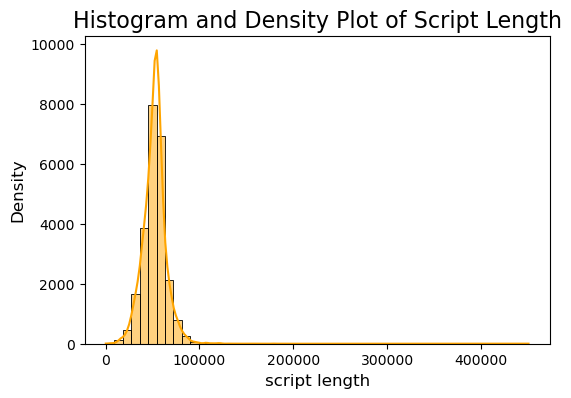

In [25]:
plt.figure(figsize=(6, 4))
sns.histplot(df['script_length'], kde=True, bins=50, color='orange')

plt.title('Histogram and Density Plot of Script Length', fontsize=16)
plt.xlabel('script length', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.show()

The distribution of script length is right-skewed. After reviewing earnings calls with over 100,000 characters, it was confirmed that these scripts are legitimate and contain substantial content.

In [26]:
df[df['script_length'] > 100000]['script'].iloc[10]

"Jonathan Vaas: Good morning and thank you for joining us. Welcome to the Adobe Q4 Earnings and 2020 Financial Analyst Meeting. I'm Jonathan Vaas, VP of Investor Relations for Adobe. You should have a copy of the press release we filed this morning as well as our investor relations datasheet. We've got a great program planned for you today, which is in many ways similar to what we've done in the past, and in a few ways different. This year marks my 10th analyst meeting at Adobe. The first was the year we had just launched Creative Cloud. And it's amazing to reflect on how that business has grown since then.  For my first nine analyst meetings, I was one of the many employees helping behind the scenes. And this year, I have the privilege of introducing the executive speakers as the head of Adobe's Investor Relations program, a role I assumed earlier this year, just after we had made the shift to working remotely.  I've really enjoyed all of the conversations with investors and analysts 

However, among the shorter scripts, some were found to be empty or lacking meaningful content, and these rows were subsequently removed.

In [27]:
df[df['script_length'] < 3000]

ticker       sector  year quarter announce_time announce_date  \
2808     CDW         tech  2021       3      13:05:31    2021-11-03   
8602     CPT  real-estate  2022       2      16:59:02    2022-07-29   
14272    CNC   healthcare  2020       3      19:08:08    2020-10-27   

                                                  script             eps_surp  \
2808   Operator: Hello, everyone, and welcome to the ...                 0.04   
8602   Kim Callahan: Good morning. And welcome to Cam...               7.2545   
14272  Operator: Good morning. Welcome to Centene Cor...  0.29760000000000003   

       script_length  word_count  mean_word_len  mean_sentence_len  
2808             293          54       4.407407          72.250000  
8602            2845         458       5.209607         141.200000  
14272            155          21       6.380952          50.666667

In [28]:
df[df['script_length'] < 3000]['script'].iloc[2]

'Operator: Good morning. Welcome to Centene Corporation Third Quarter 2020 Financial Results Conference Call. All participants will be in listen-only mode. '

In [29]:
# Removing unmeaningfule rows
df = df[df['script_length'] >= 3000]

__Distribution of the Number of Words__

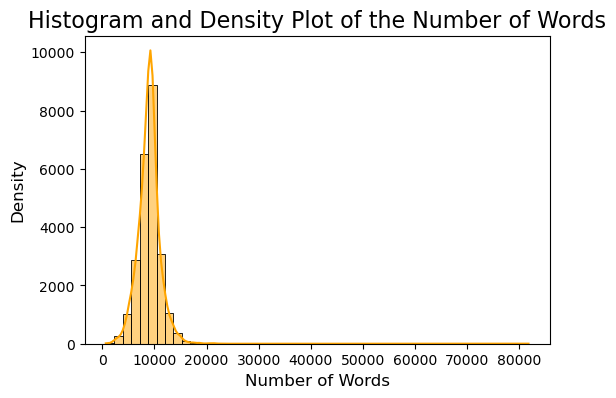

In [30]:
plt.figure(figsize=(6, 4))
sns.histplot(df['word_count'], kde=True, bins=50, color='orange')

plt.title('Histogram and Density Plot of the Number of Words', fontsize=16)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.show()

The distribution of Number of Words is also right-skewed. After reviewing earnings calls with over 20,000 words, it was confirmed that these scripts are legitimate and contain substantial content.

In [51]:
df[df['word_count'] > 20000]['script'].iloc[7]

"Michael Leskinen: Good afternoon. Since we're an airline, we're going to go with T0. And if you're late, you're late. Welcome. This is my first event as the Head of IR at United and I am excited to be the newest member of this team. It's great to see a lot of familiar faces from my 16 years on the buy side. And it'll be great to work with all of you from a different seat. Our priority is to transparently communicate our goals and we're going to work on doing more transparency, you're going to see some of that tonight, but also we want to let you hold us accountable for our financial targets and we're going to spend time focusing on that tonight as well. I think at the end of the night, you're going to see tangible evidence of a shift in that communication and I look forward to having a discussion with all of you. Before we begin today's presentation, as safety is our highest priority, we like to provide a safety briefing. In the event of an emergency, please exit out the stairwell dir

In [32]:
df[df['word_count'] < 1000]

ticker                 sector  year quarter announce_time announce_date  \
11786     CE              materials  2022       1      14:31:06    2022-04-29   
12990   ERIE              insurance  2021       1      14:49:06    2021-04-30   
15214    DVA             healthcare  2020       4      22:25:36    2021-02-11   
15719    KHC  food-beverage-tobacco  2015       1      17:00:00    2012-11-20   

                                                  script  \
11786  Operator: Greetings and welcome to the Celanes...   
12990  Operator:  …following the recording. Now I wou...   
15214  Operator: Good evening. My name is Sheila and ...   
15719  Operator: Good day, my name is Amanda, and I w...   

                   eps_surp  script_length  word_count  mean_word_len  \
11786   0.22649999999999998           4437         751       4.905459   
12990               -0.0342           5066         821       5.169306   
15214  -0.10740000000000001           4128         669       5.167414   
15719                   NaN           4898         793       5.177806   

       mean_sentence_len  
11786          78.196429  
12990         111.600000  
15214          97.238095  
15719         110.340909

In [33]:
df[df['word_count'] < 1000]['script'].iloc[2]

"Operator: Good evening. My name is Sheila and I will be your conference facilitator today. At this time, I would like to welcome everyone to the DaVita Fourth Quarter 2020 Earnings Call. All lines have been placed on mute to prevent any background noise. After the speakers' remarks, there will be a question-and-answer period.  Mr. Gustafson, you may begin your conference.\nJim Gustafson: Thank you and welcome everyone to our fourth quarter conference call. We appreciate your continued interest in our company. I'm Jim Gustafson, Vice President of Investor Relations and joining me today are Javier Rodriguez, our CEO; and Joel Ackerman, our CFO.\nJavier Rodriguez: Thanks Jim. Good afternoon and thank you for joining the call today to discuss our 2020 performance and thoughts on 2021. For DaVita, 2020 showcased our caregivers and their commitment to patients with kidney disease. COVID created challenges that we could never have imagined one year ago. These challenges clinical, operational

However, as observed above, scripts with a low word count were found to be incomplete or defective. Therefore, rows with a word count of 1,000 or less were removed.

In [34]:
df = df[df['word_count'] >= 1000]

__Distribution of Average Word Length__

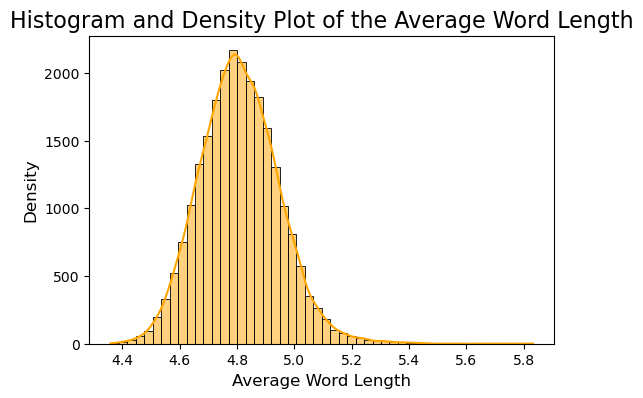

In [35]:
plt.figure(figsize=(6, 4))
sns.histplot(df['mean_word_len'], kde=True, bins=50, color='orange')

plt.title('Histogram and Density Plot of the Average Word Length', fontsize=16)
plt.xlabel('Average Word Length', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.show()

The distribution of average word length is slightly right-skewed.

In [36]:
df[df['mean_word_len'] > 5.3]

ticker              sector  year quarter announce_time announce_date  \
331        D           utilities  2019       4      17:00:00    2019-11-01   
946      AEE           utilities  2016       3      17:00:00    2016-08-05   
1022      FE           utilities  2007       3      17:00:00    2006-10-25   
1107     ATO           utilities  2018       4      17:00:00    2018-02-07   
1348      NI           utilities  2013       1      17:00:00    2013-02-19   
...      ...                 ...   ...     ...           ...           ...   
19999    WMT  consumer-retailing  2016       1      17:00:00    2012-11-15   
20001    WMT  consumer-retailing  2016       3      17:00:00    2013-05-16   
20002    WMT  consumer-retailing  2016       4      17:00:00    2013-08-15   
20003    WMT  consumer-retailing  2017       2      17:00:00    2014-02-20   
22393    LHX       capital-goods  2008       1      17:00:00    2007-08-08   

                                                  script  \
331    Operator: Ladies and gentlemen, good morning a...   
946    Operator: Greetings, and welcome to Ameren Cor...   
1022   Operator: Good afternoon, ladies and gentlemen...   
1107   Operator: Greetings, and welcome to Atmos Ener...   
1348   Operator: Good day, ladies and gentlemen, and ...   
...                                                  ...   
19999  Carol Schumacher: Welcome. This is Carol Schum...   
20001  Pauline Mohler: Welcome. This is Pauline Mohle...   
20002  Steve Schmitt: Good morning and thank you for ...   
20003  Steve Schmitt: Good morning and thank you for ...   
22393  Operator: Good afternoon, and welcome tothe Ha...   

                   eps_surp  script_length  word_count  mean_word_len  \
331    0.036000000000000004          43394        6790       5.391016   
946                  0.1845          34633        5407       5.405400   
1022    0.07400000000000001          33714        5334       5.320397   
1107                 0.2422          14978        2343       5.393086   
1348                 0.0259          18083        2851       5.343038   
...                     ...            ...         ...            ...   
19999                0.0077          57318        9062       5.325204   
20001               -0.0047          55836        8862       5.300722   
20002               -0.0016          31915        5056       5.312500   
20003                0.0079          28754        4552       5.317004   
22393                 0.034          47430        7409       5.401674   

       mean_sentence_len  
331           173.277108  
946           148.930736  
1022          117.714789  
1107          117.880952  
1348          120.369128  
...                  ...  
19999         128.388262  
20001         124.476404  
20002         134.812766  
20003         134.004695  
22393         132.233146  

[69 rows x 12 columns]

In [37]:
df[df['mean_word_len'] > 5.3]['script'].iloc[4]

"Operator: Good day, ladies and gentlemen, and welcome to the quarter 1 2013 NiSource Earnings Conference Call. My name is Patrick, and I will be your coordinator for today. [Operator Instructions] As a reminder, this conference is being recorded for replay purposes. I would now like to turn the conference over to Mr. Glen Kettering, Senior Vice President of corporate affairs. Please proceed, sir.\nGlen L. Kettering: Thank you, Patrick, and good morning, everyone. On behalf of NiSource, I'd like to welcome you to our quarterly analyst call. Joining me this morning are Bob Skaggs, President and Chief Executive Officer; Steve Smith, Executive Vice President and Chief Financial Officer; and Randy Hulen, Managing Director of Investor Relations. The focus of today's call is to review our financial performance for the first quarter of 2013 and to provide a business update. We'll then open the call to your questions. At times during the call, we will refer to the supplemental slides available

In [38]:
df[df['mean_word_len'] > 5.3].shape

(69, 12)

As seen in the text above, if the average word length exceeds 5.3, it indicates the presence of words that are concatenated without spaces - for example, 'thisadditional', which should be 'this additional'. Therefore, those rows will be removed from the dataset.

__Distribution of Average Sentence Length__

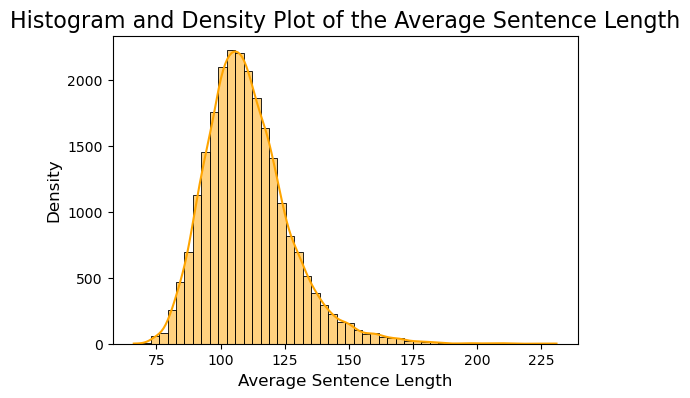

In [39]:
plt.figure(figsize=(6, 4))
sns.histplot(df['mean_sentence_len'], kde=True, bins=50, color='orange')

plt.title('Histogram and Density Plot of the Average Sentence Length', fontsize=16)
plt.xlabel('Average Sentence Length', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.show()

The distribution of average word length is also slightly right-skewed.

In [40]:
df[df['mean_sentence_len'] > 175]

ticker         sector  year quarter announce_time announce_date  \
18       NEE      utilities  2015       4      17:00:00    2015-04-29   
30       NEE      utilities  2019       3      17:00:00    2019-10-22   
31       NEE      utilities  2019       4      17:00:00    2020-01-24   
32       NEE      utilities  2020       1      17:00:00    2020-04-22   
412      VST      utilities  2019       2      17:00:00    2019-02-28   
...      ...            ...   ...     ...           ...           ...   
23577   GNRC  capital-goods  2014       4      17:00:00    2014-11-06   
23578   GNRC  capital-goods  2015       1      17:00:00    2015-02-11   
23597   GNRC  capital-goods  2019       4      17:00:00    2019-11-01   
23658    JPM          banks  2008       4      17:00:00    2009-01-21   
24113    MTB          banks  2019       2      17:00:00    2019-01-17   

                                                  script  \
18     Operator: Good day, everyone, and welcome to t...   
30     Operator: Good morning, and welcome to the Nex...   
31     Operator: Good morning everyone and welcome to...   
32     Operator: Good morning everyone and welcome to...   
412    Operator: At this time, I would like to welcom...   
...                                                  ...   
23577  Operator: Good day, ladies and gentlemen and w...   
23578  Operator: Good day, ladies and gentlemen and w...   
23597  Operator: Ladies and gentlemen, thank you for ...   
23658  Operator: Good morning ladies and gentlemen. W...   
24113  Operator: Good morning. My name is Samantha, a...   

                    eps_surp  script_length  word_count  mean_word_len  \
18       0.11460000000000001          54382        9123       4.961087   
30                    0.0455          55338        8802       5.287094   
31     -0.027000000000000003          58159        9377       5.202410   
32      0.053099999999999994          75834       12168       5.232331   
412                  -1.7371          59953       10214       4.869787   
...                      ...            ...         ...            ...   
23577                 -0.195          73147       12624       4.794360   
23578    0.26780000000000004          67234       11705       4.744126   
23597                 0.0728          71535       11938       4.992294   
23658                    NaN          49335        8844       4.578471   
24113                 0.0758          46765        8091       4.780002   

       mean_sentence_len  
18            184.607509  
30            228.622407  
31            209.724638  
32            210.829609  
412           177.434524  
...                  ...  
23577         177.409756  
23578         197.920118  
23597         179.646465  
23658         188.753846  
24113         184.579365  

[76 rows x 12 columns]

In [41]:
df[df['mean_sentence_len'] > 175]['script'].iloc[1]

"Operator: Good morning, and welcome to the NextEra Energy and NextEra Energy Partners Conference call. [Operator Instructions] Please note, today's event is being recorded.I'd now like to turn the conference over to Matt Roskot, Director of Investor Relations. Please go ahead, sir.\nMatthew Roskot: Thank you, Rocco. Good morning, everyone, and thank you for joining our third quarter 2019 combined earnings conference call for NextEra Energy and NextEra Energy Partners.With me this morning are Jim Robo, Chairman and Chief Executive Officer of NextEra Energy; Rebecca Kujawa, Executive Vice President and Chief Financial Officer of NextEra Energy; John Ketchum, President and Chief Executive Officer of NextEra Energy Resources; and Mark Hickson, Executive Vice President of NextEra Energy, all of whom are also officers of NextEra Energy Partners; as well as Eric Silagy, President and Chief Executive Officer of Florida Power & Light Company. Rebecca will provide an overview of our results and

We can't find any issues in the scripts that have an average sentence length longer than 175 characters

In [42]:
df[df['mean_sentence_len'] < 75]

ticker                   sector  year quarter announce_time  \
78        SO                utilities  2016       2      17:00:00   
800      AWK                utilities  2021       1      17:58:07   
1319     LNT                utilities  2020       4      17:00:00   
1637     UPS           transportation  2021       1      12:33:03   
2531     MSI                     tech  2018       1      17:00:00   
5538     TXN           semiconductors  2022       3      21:10:07   
5951    MPWR           semiconductors  2020       1      17:00:00   
7748     SPG              real-estate  2017       2      17:00:00   
7749     SPG              real-estate  2017       3      17:00:00   
7753     SPG              real-estate  2018       3      17:00:00   
7763     SPG              real-estate  2021       2      22:14:08   
9668     MTD  pharmaceuticals-biotech  2019       2      17:38:07   
11335    PPG                materials  2021       1      14:06:03   
11764     CE                materials  2016       2      17:00:00   
12127     CB                insurance  2019       1      17:00:00   
12135     CB                insurance  2021       1      12:30:37   
13332    CHD                household  2018       3      17:00:00   
13334    CHD                household  2019       1      17:00:00   
13346    CHD                household  2022       2      16:32:03   
14007    HCA               healthcare  2019       2      17:00:00   
14559    COO               healthcare  2021       1      23:50:58   
18593    RJF   diversified-financials  2015       1      17:00:00   
20531   GRMN        consumer-durables  2019       2      13:20:05   
21041    RSG      commercial-services  2018       1      17:00:00   
21332    ROL      commercial-services  2021       2      14:36:10   
21841     PH            capital-goods  2020       2      14:31:07   
21868    TDG            capital-goods  2015       1      17:00:00   
21885    TDG            capital-goods  2019       2      17:54:08   
21886    TDG            capital-goods  2019       3      16:29:08   
21998    MMM            capital-goods  2017       3      17:00:00   
22144   CARR            capital-goods  2020       4      14:33:04   
22757    AME            capital-goods  2015       3      17:00:00   
22777    AME            capital-goods  2020       3      20:07:08   
22936    ROK            capital-goods  2019       2      17:00:00   
22964    FTV            capital-goods  2020       3      04:43:10   
23320    PNR            capital-goods  2017       1      17:00:00   
23543    AOS            capital-goods  2016       2      17:00:00   
24423   TSLA              automobiles  2017       2      17:00:00   

      announce_date                                             script  \
78       2016-04-28  Operator: Good afternoon. My name is Sylvana, ...   
800      2021-02-25  Operator: Good morning and welcome to American...   
1319     2020-08-07  Operator: Good afternoon and welcome to Allian...   
1637     2021-04-27  Operator: Good morning. My name is Steven, and...   
2531     2018-02-02  Operator: Good afternoon and thank you for hol...   
5538     2022-10-25  Dave Pahl: Welcome to the Texas Instruments Th...   
5951     2020-02-06  Operator: Ladies and gentlemen, thank you for ...   
7748     2017-04-28  Operator: Good day, ladies and gentlemen, and ...   
7749     2017-08-01  Operator: Good morning, ladies and gentlemen, ...   
7753     2018-07-30  Operator: Good day, ladies and gentlemen, and ...   
7763     2021-08-02  Operator: Thank you for standing by, and welco...   
9668     2019-08-02  Operator: Good day, ladies and gentlemen, and ...   
11335    2021-04-16  Operator: Good morning. My name is Jerome and ...   
11764    2016-04-19  Operator: Good morning, and welcome to the Cel...   
12127    2019-02-06  Operator: Good day and welcome to the Chubb Li...   
12135    2021-02-03  Operator: Please standby, we are about to begi...   
13332    2018-08-02  Operator: Good morning, ladies and 

In [43]:
df[df['mean_sentence_len'] < 75]['script'].iloc[5]

'Dave Pahl: Welcome to the Texas Instruments Third Quarter 2022 Earnings Release Conference Call. I am Dave Pahl, Head of Investor Relations and I am joined by our Chief Financial Officer, Rafael Lizardi. For any of you who missed the release, you can find it on our website at ti.com/ir. This call is being broadcast live over the web and can be accessed through our website. In addition, todayâ\x80\x99s call is being recorded and you will be able to get it via replay on our website. This call will include forward-looking statements that involve risks and uncertainties that could cause TIâ\x80\x99s results to differ materially from managementâ\x80\x99s current expectations. We encourage you to review the notice regarding forward-looking statements contained in the earnings release published today as well as TIâ\x80\x99s most recent SEC filings for a more complete description. Today, we will provide the following updates. First, I will start with a quick overview of the quarter. Next, I w

Several issues were identified, including the presence of misencoded characters (such as â\x80\x99 representing an apostrophe) and extraneous backslashes. To address these issues, we will implement the following cleaning steps:

1) Remove backslashes from the scripts.
2) Replace newline characters (\n) with spaces.
3) Correct misencoded representations of common characters, including misencoded apostrophes and curly apostrophes.

In [44]:
def clean_script(text):
    text = text.encode('utf-8', 'ignore').decode('utf-8')  # Correct potential encoding issues
    text = re.sub(r"\\ '", "'", text)  # Remove backslashes before apostrophes
    text = text.replace('\n', ' ')  # Replace newline characters with spaces
    text = text.replace("'", "'")  # Normalize apostrophes if needed

    # Replace common misencoded characters
    text = text.replace("â\x80\x99", "'")  # Correct misencoded apostrophe
    text = text.replace("â", "a")          # Correct misencoded character
    text = text.replace("’", "'")          # Replace curly apostrophe

    # Remove any other unwanted characters or multiple spaces
    text = re.sub(r'\s+', ' ', text)       # Replace multiple spaces with a single space
    text = text.strip()                    # Remove leading and trailing spaces

    return text

In [45]:
df['script'] = df['script'].apply(clean_script)

In [52]:
df[df['mean_sentence_len'] < 75]['script'].iloc[5]

"Dave Pahl: Welcome to the Texas Instruments Third Quarter 2022 Earnings Release Conference Call. I am Dave Pahl, Head of Investor Relations and I am joined by our Chief Financial Officer, Rafael Lizardi. For any of you who missed the release, you can find it on our website at ti.com/ir. This call is being broadcast live over the web and can be accessed through our website. In addition, today's call is being recorded and you will be able to get it via replay on our website. This call will include forward-looking statements that involve risks and uncertainties that could cause TI's results to differ materially from management's current expectations. We encourage you to review the notice regarding forward-looking statements contained in the earnings release published today as well as TI's most recent SEC filings for a more complete description. Today, we will provide the following updates. First, I will start with a quick overview of the quarter. Next, I will provide insight into third q